In [1]:
import os
import tqdm
import copy
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from alignment_helper_fns import *
from gop_helper_fns import *
from mfa_evaluation_utils import *
from g2p_en import G2p
g2p = G2p()

/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/Bio/pairwise2.py:283: BiopythonDeprecationWarning: Bio.pairwise2 has been d

In [2]:
satdf = pd.read_csv('./results_sat/results.csv').set_index('Unnamed: 0')
xsatdf = pd.read_csv('./results_sat_xvector/results_xvector_proj.csv')
xsatdf = xsatdf.rename(columns={'Unnamed: 0': 'Speaker'})


results_dir_frame = './results_frame_10epochs'
results_dir_ivec = './results_sat'
# results_dir_xvec = './results_sat_xvector'
results_dir_xvec = './phone_matched_xvec_proj_textgrids'

In [3]:
%%capture
speaker_tgs = {}

nmanual = 0
nframe = 0
nivec = 0
nxvec = 0
for speakerid in list(satdf.index):
    tg_dct = {}
    
    tg_dct['Manual'] = get_all_textgrids_in_directory(os.path.join('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/', speakerid))
    tg_dct['Frame'] = get_all_textgrids_in_directory(os.path.join('./results_frame_10epochs', speakerid))
    tg_dct['MFA'] = get_all_textgrids_in_directory(os.path.join('./results_mfa_adapted', speakerid))
    tg_dct['xvector'] = get_all_textgrids_in_directory(os.path.join('./phone_matched_xvec_proj_textgrids', speakerid))
    tg_dct['ivector'] = get_all_textgrids_in_directory(os.path.join('./results_mfa_adapted', speakerid))

    nmanual += len(tg_dct['Manual'])
    nframe += len(tg_dct['Frame'])
    nivec += len(tg_dct['ivector'])
    nxvec += len(tg_dct['xvector'])
    
    speaker_tgs[speakerid] = tg_dct
    


In [4]:
EXCLUDE_FILES = ['0505_M_EKs4T10', '0411_M_LMwT32']

allmanual_tgs = [pth for pth in get_all_textgrids_in_directory('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/') if '.TextGrid' in pth]
allmanual_tgs = [tg for tg in allmanual_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

ivector_tgs =[pth for pth in get_all_textgrids_in_directory('./results_sat') if '.TextGrid' in pth]
ivector_tgs = [tg for tg in ivector_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]


xvector_tgs =[pth for pth in get_all_textgrids_in_directory('./phone_matched_xvec_proj_textgrids') if '.TextGrid' in pth]
# xvector_tgs =[pth for pth in get_all_textgrids_in_directory('./results_xvector_reevaluated') if '.TextGrid' in pth]
xvector_tgs = [tg for tg in xvector_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

mfa_tgs = [pth for pth in get_all_textgrids_in_directory('./results_mfa_adapted') if '.TextGrid' in pth]
mfa_tgs = [tg for tg in mfa_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

print('Num Mismatched:\t', sum([f1.split('/')[-1].split('.')[0]!=f2.split('/')[-1].split('.')[0] for f1, f2 in zip(allmanual_tgs, xvector_tgs)]))

print(len(allmanual_tgs))
print(len(ivector_tgs))
print(len(xvector_tgs))
print(len(mfa_tgs))

Extracting all textgrids in directory:	 /home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/


43it [00:00, 6980.23it/s]


Extracting all textgrids in directory:	 ./results_sat


43it [00:00, 7238.23it/s]


Extracting all textgrids in directory:	 ./phone_matched_xvec_proj_textgrids


43it [00:00, 7312.48it/s]


Extracting all textgrids in directory:	 ./results_mfa_adapted


43it [00:00, 7460.09it/s]

Num Mismatched:	 0
3762
3762
3762
3762


In [5]:
'''
1. loop through the textgrids and find the cases where the phoneme sequence from g2p does not match the phoneme sequence in hand alignment
2. loop through the textgrids and find the cases where the phoneme sequence from g2p does not match the predicted
'''
def get_audiopath_from_tgfile(tgfilepath, datapath = '/home/prad/datasets/ChildSpeechDataset/child_speech_16_khz'):    
    ''' given a textgrid file will generate the path to the audio for that textgrid'''
    speaker_id = tgfilepath.split('/')[-2]
    wavfname = tgfilepath.split('/')[-1].split('.')[-2] + '.wav'
    wavfpath = os.path.join(datapath, speaker_id, wavfname)
    return wavfpath

def remove_sil_from_phonelist(phonelist):
    '''
    given a list of phonemes from a textgrid, will return the phonemes in the list without silence
    example
    INPUT:
        phonelist: ['[SIL]', 'B', 'IY', 'D', '[SIL]']
    output
        res: ['B', 'IY', 'D']
    '''
    res = list(filter(('[SIL]').__ne__, phonelist))
    res = list(filter(('sil').__ne__, phonelist))

    return res

def get_transcript_from_tgfile(tgfilepath, datapath = '/home/prad/datasets/ChildSpeechDataset/child_speech_16_khz'):
    '''
    for the input textgrid file, find the corresponding transcript .lab file and laod the transcript
    '''
    try:
        speaker_id = tgfilepath.split('/')[-2]
    except:
        print(tgfilepath)
    scriptfname = tgfilepath.split('/')[-1].split('.')[-2] + '.lab'
    scriptfpath = os.path.join(datapath,  speaker_id, scriptfname)
    f = open(scriptfpath)
    transcript = f.read().replace('\n', ' ')
    f.close()
    return transcript



In [6]:
from evaluation_utils import *

In [7]:
'''

functions to remove the short phoneme problem

'''

# def is_start_phone(phn, phonelist):
#     '''
#         each phoneme is associated with words in the transcript
#         This function returns which phonemes in the textgrid occur at the start of a word
        
#         Example:
        
#         transcript - 'good day'
#         phonelist = ['G', 'UH', 'D', ' ', 'D', 'AE', 'Y']
        
#         1. the first phoneme at [0] is a start phone
#         2a. find the locations of the spaces ' '
#         2b. any phonemes occuring after a space are also start phones
        
#     '''
#     space_locs = np.argwhere(phonelist==' ').ravel()
#     start_idxs = np.concatenate(([0], space_locs+1))    
#     phn_idx = np.argwhere(phonelist==phn)
#     return any([_idx in start_idxs for _idx in phn_idx])

# def is_end_phone(phn, phonelist):
#     '''
#     find the location of end phonemes
#     does nearly the same thing as the is_start_phone function, except for end phones
#     '''
    
#     space_locs = np.argwhere(phonelist==' ').ravel()
#     end_idxs = np.concatenate((space_locs-1, [len(phonelist)]))
#     phn_idx = np.argwhere(phonelist==phn)
#     return any([_idx in start_idxs for _idx in phn_idx])


# def collapse_repeated_phones(input_df, phonekey='phone'):
#     '''
#     input:
#         input_df - the input textgrid
        
#     logic:
#         - just concatenates consecutive identical phonemes
    
#         for each line in the input textgrid df, check if the next phoneme is the same as the current phoneme
#         if they are, simply 
    
#     '''
#     inp_df = copy.deepcopy(input_df)
#     ii=0
    
#     while ii<len(inp_df)-1:
#         if inp_df.at[ii, phonekey]==inp_df.at[ii+1, phonekey]:
#             newend = inp_df.at[ii+1, 'end']
#             inp_df.at[ii, 'end'] = newend
#             inp_df = inp_df.drop(ii+1, axis=0).reset_index(drop=True)
#         else:
#             ii+=1
            
#     return inp_df

# commented out because it's in alignment helper functions now
# def process_silences(inp_df, transcript, silphone='sil'): 
#     phonelist = g2p(transcript)
#     tgdf = copy.deepcopy(inp_df)
#     ''' flag silences in the middle of a word with nan'''
#     for ii in range(len(tgdf)):
#         if ii<len(tgdf)-1 and ii>0:
#             # print(tgdf[phonekey][ii])
#             if tgdf['phone'][ii]=='sil':
#                 prevphone = tgdf['phone'].iloc[ii-1]
#                 nextphone = tgdf['phone'].iloc[ii+1]

#                 if prevphone==nextphone and not(is_end_phone(prevphone, phonelist) and is_start_phone(nextphone, phonelist)):
#                     tgdf.at[ii, 'phone'] = np.nan
                    
#     ''' remove the silences'''
#     # tgdf = tgdf[~pd.isna(tgdf[phonekey])].reset_index(drop=True).drop(columns=['index'])
#     tgdf = tgdf[~pd.isna(tgdf['phone'])].reset_index(drop=True)
#     ''' collapse the repeated phonemes '''
#     return collapse_repeated_phones(tgdf, phonekey='phone')


# def get_phone_by_word(transcript):
#     words = transcript.split(' ')
#     phonelist = [[re.sub(r'[0-9]+', '', _w) for _w in g2p(_word)] for _word in words]
#     return phonelist
    
# def process_silence(tgpath, transcript, phone_key='phones'):
#     phonelist = get_phone_by_word(transcript)
#     textgridpath_to_phonedf(tgpath, phone_key=phone_key)
    
# for ii in range(len(_df)):
#     if ii<len(_df)-1 and ii>0:
#         print(_df['phone'][ii])
#         if _df['phone'][ii]=='sil':
#             prevphone = _df['phone'].iloc[ii-1]
#             nextphone = _df['phone'].iloc[ii+1]
            
#             if prevphone==nextphone and not(is_end(prevphone, phonelist) and is_start_phone(nextphone, phonelist)):
#                 _df.at[ii, 'phone'] = np.nan

'\n\nfunctions to remove the short phoneme problem\n\n'

In [ ]:
def contains_same_phones(phone_list1, phone_list2):
    '''
        simply checks that two phoneme lists are the same
        for example that a ground truth textgrid and an estimated textgrid have the same list of phonemes
    '''
    return np.logical_and.reduce(np.unique(phone_list1)==np.unique(phone_list2))
    
phonecounts = {}
phonecounts_man = {}

phonewise_te = {}

phonewise_gops_man = {}
phonewise_gops_xvec = {}

phonedurations_man = {}
phonedurations = {}

# loop to initialize the results dictionaries
for phone in ENGLISH_PHONEME_LIST:
    phonewise_gops_man[phone] = []
    phonewise_gops_xvec[phone] = []
    
    phonewise_te[phone] = []
    
    phonecounts_man[phone] = 0
    phonecounts[phone] = 0
    
    phonedurations_man[phone] = []
    phonedurations[phone] = []

def get_df_row_as_tuples(inpdf):
    [tuple(row[1].values) for row in inpdf.iterrows()]
    
    
def provide_display(transcript, filepath, tgpath, tg1df, tg2df, tg3df=None):
    p1 = np.array(remove_sil_from_phonelist(tg1df.phone.values))
    p2 = np.array(remove_sil_from_phonelist(tg2df.phone.values))
    print('------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------')
    print(tgpath)
    print(transcript)
    print('------------------------------------------------------------------------------------------------')
    print('File:\t', filepath)
    # print('------', ii)
    print('Transcript:\t', transcript)
    _g2p = g2p(transcript)

    if ' ' in _g2p:
        _g2p.remove(' ')

    print('g2p:\t\t\t', _g2p)
    print('------')
    print('Predicted Phone Sequence:\t', p2)
    print('ManualPhones:\t\t', p1)

    print('------ Manual Textgrid')
    print(tg1df)
    print('------ Aligned Textgrid')
    print(tg2df)
    if tg3df is not None:
        print('---------- Fixed Aligned TG')
        print(tg3df)
ii=0
nmiss_tot = 0
g2p_mismatch = 0
len_mismatch = 0
shortcount = 0

allphones = []
DISPLAY_MISMATCHES = False
DISPLAY_SHORTPHONES = True
sameseq_diff_len = 0
phone_error_rates = []
alignment_scores = []
short_tgs = []
short_transcripts = []
manual_for_short_tgs = []
nerr = 0
for f1, f2 in tqdm.tqdm(zip(allmanual_tgs, xvector_tgs)):
    mismatch = False
    wavfpath = get_audiopath_from_tgfile(f1)
    transcript = get_transcript_from_tgfile(f1)
    tg1 = textgridpath_to_phonedf(f1, phone_key='ha phones', remove_numbers=True)
    tg2 = textgridpath_to_phonedf(f2, phone_key='phones', remove_numbers=True)
    # tg2_orig = copy.deepcopy(tg2)
    # tg2 = process_silences(tg2, transcript)
    
    tg1rows = [tuple(row[1]) for row in tg1.iterrows()]
    tg2rows = [tuple(row[1]) for row in tg2.iterrows()]
    
    # outputsmanual = calculate_GOP_e2e(wavfpath, transcript=transcript, textgrid_alignment=tg1)
    # outputsxvec = calculate_GOP_e2e(wavfpath, transcript=transcript, textgrid_alignment=tg2)
    tg1['duration'] = tg1['end'] - tg1['start']
    tg2['duration'] = tg2['end'] - tg2['start']
    p1 = np.array(remove_sil_from_phonelist(tg1.phone.values))
    p2 = np.array(remove_sil_from_phonelist(tg2.phone.values))
    
    durations = tg2['end'] - tg2['start']

    show = False
    for jj in range(tg1.shape[0]):
        phone = tg1.iloc[jj]['phone']
        if not phone=='[SIL]' and phone in ENGLISH_PHONEME_LIST:
            phonedurations_man[phone].append((tg1.iloc[jj, 1] - tg1.iloc[jj, 0])*1000)
            phonecounts_man[phone] += 1
        
    for jj in range(tg2.shape[0]):
        phone = tg2.iloc[jj]['phone']
        if not phone=='[SIL]' and phone in ENGLISH_PHONEME_LIST:
            phonedurations[phone].append((tg2.iloc[jj, 1] - tg2.iloc[jj, 0])*1000)
            phonecounts[phone] += 1
            
    _phone='IY'
    if _phone in p2:
        pdur = tg2['duration'][tg2['phone']==_phone].values
        if any(pdur<.1):
            if DISPLAY_SHORTPHONES:
                provide_display(transcript, wavfpath, f2, tg1, tg2)
                short_tgs.append(tg2)
                short_transcripts.append(transcript)
                manual_for_short_tgs.append(tg1)
                print()
            shortcount +=  1
            
    # if any(durations<.04):
        # provide_display(transcript, wavfpath, f2, tg1, tg2)
        # shortcount +=  1
    rslts = calc_alignment_cost(get_df_rows_as_tuples(tg1), get_df_rows_as_tuples(tg2), return_all_metrics=True)
    alignment_scores.append(rslts['AlignmentScore'])
    phone_error_rates.append(rslts['PhoneErrorRate'])
    if len(p1)!=len(p2):
        len_mismatch += 1
        provide_display(transcript, wavfpath, f2, tg1, tg2)
        mismatch=True
    elif not all(p1==p2):
        # g2p_mismatch += 1
        mismatch=True
        
    else:
#         outputsmanual = calculate_GOP_e2e(wavfpath, transcript=transcript, textgrid_alignment=tg1)[0]
#         outputsxvec = calculate_GOP_e2e(wavfpath, transcript=transcript, textgrid_alignment=tg2)[0]
        
#         for phone in p1:
#             manual_gop = outputsmanual[outputsmanual['Phone']==phone]['GOP'].iloc[0]
#             xvec_gop = outputsxvec[outputsxvec['Phone']==phone]['GOP'].iloc[0]
            

            
#             phonewise_gops_man[phone].append(manual_gop)
#             phonewise_gops_xvec[phone].append(xvec_gop)
            
        for kk in range(tg1.shape[0]):
            phone = tg1.loc[kk, 'phone']
            if phone=='sil' or phone=='[UNK]' or phone=='[SIL]':
                continue
            else:
                onset_gt = tg1.loc[kk, 'start']
                offset_gt = tg1.loc[kk, 'end']

                onset_xvec = tg2.loc[kk, 'start']
                offset_xvec = tg2.loc[kk, 'end']

                te = (np.abs(onset_gt - onset_xvec) - np.abs(offset_gt - offset_xvec))/2
                phonewise_te[phone].append(te)
        pass
            
    allphones.extend(p1)
    
    if mismatch==True:
        nmiss_tot += 1

        # print(p1)
        # print(p2)
        if len(p1) != len(p2):
            if len(np.unique(p1))==len(np.unique(p2)):
                # if contains_same_phones(p1, p2):
                sameseq_diff_len+=1
                if DISPLAY_MISMATCHES:
                    provide_display(transcript, wavfpath, f2, tg1, tg2)
        else:
            if len(np.unique(p1))==len(np.unique(p2)):
                g2p_mismatch += 1
    # ii+=1
    # if ii>1000:
    #     break
print('Num Total Mismatch:\t', nmiss_tot)
print('Num Length Mismatch:\t', len_mismatch)
print('Num G2p Mismatch:\t', g2p_mismatch)
print('Shortcount', shortcount)

In [10]:
print('Num Total Mismatch:\t', nmiss_tot, 100*nmiss_tot/len(allmanual_tgs))
print('Num Length Mismatch:\t', len_mismatch,  100*len_mismatch/len(allmanual_tgs))
print('Num G2p Mismatch:\t', g2p_mismatch, 100*g2p_mismatch/len(allmanual_tgs))
print('Num G2p Mismatch:\t', shortcount, 100*shortcount/len(allmanual_tgs))
print('Average Alignment Score:\t', np.mean(alignment_scores))
print('Phone Error Rate:\t', np.mean(phone_error_rates))

Num Total Mismatch:	 264 7.017543859649122
Num Length Mismatch:	 257 6.831472620946305
Num G2p Mismatch:	 6 0.1594896331738437
Num G2p Mismatch:	 200 5.31632110579479
Average Alignment Score:	 nan
Phone Error Rate:	 1.482702744556338


In [11]:
print('Num Total Mismatch:\t', nmiss_tot, 100*nmiss_tot/len(allmanual_tgs))
print('Num Length Mismatch:\t', len_mismatch,  100*len_mismatch/len(allmanual_tgs))
print('Num G2p Mismatch:\t', g2p_mismatch, 100*g2p_mismatch/len(allmanual_tgs))
print('Num with short:\t', shortcount, 100*shortcount/len(allmanual_tgs))
print('Average Alignment Score:\t', np.mean(alignment_scores))
print('Phone Error Rate:\t', np.mean(phone_error_rates))

Num Total Mismatch:	 264 7.017543859649122
Num Length Mismatch:	 257 6.831472620946305
Num G2p Mismatch:	 6 0.1594896331738437
Num with short:	 200 5.31632110579479
Average Alignment Score:	 nan
Phone Error Rate:	 1.482702744556338


In [12]:
print('Num Total Mismatch:\t', nmiss_tot, 100*nmiss_tot/len(allmanual_tgs))
print('Num Length Mismatch:\t', len_mismatch,  100*len_mismatch/len(allmanual_tgs))
print('Num G2p Mismatch:\t', g2p_mismatch, 100*g2p_mismatch/len(allmanual_tgs))
print('Num with short:\t', shortcount, 100*shortcount/len(allmanual_tgs))
print('Average Alignment Score:\t', np.mean(alignment_scores))
print('Phone Error Rate:\t', np.mean(phone_error_rates))

Num Total Mismatch:	 264 7.017543859649122
Num Length Mismatch:	 257 6.831472620946305
Num G2p Mismatch:	 6 0.1594896331738437
Num with short:	 200 5.31632110579479
Average Alignment Score:	 nan
Phone Error Rate:	 1.482702744556338


In [ ]:
from Bio import pairwise2
import functools

MATCH_SCORE = 0
MISMATCH_SCORE = 2

def _silence_check(phone):
    return phone in {'sp', '<p:>', '', 'sil', None}

def _compare_labels(ref, test):
    if ref == test:
        return MATCH_SCORE
    ref = ref.lower()
    test = test.lower()
    if ref == test:
        return MATCH_SCORE
    return MISMATCH_SCORE

def _overlap_scoring(firstElement, secondElement):
    # print(firstElement)
    # print(secondElement)
    if firstElement==['-'] or secondElement ==['']:
        begin_diff = abs(firstElement[0] - secondElement[0])
        end_diff = abs(firstElement[1] - secondElement[1])
        label_diff = _compare_labels(firstElement[2], secondElement[2])
        return -1 * (begin_diff + end_diff + label_diff)
    else:
        return -2


score_func = functools.partial(_overlap_scoring)

In [14]:
def calc_alignment_cost(alignment):
    overlap_count = 0
    overlap_sum = 0
    num_insertions = 0
    num_deletions = 0
    for a in alignments:
        for i, sa in enumerate(a.seqA):
            sb = a.seqB[i]
            print(sb, sa)
            if sa == '-':
                if not silence_check(sb[2]):
                    num_insertions += 1
                else:
                    continue
            elif sb == '-':
                if not _silence_check(sb[2]):
                    num_deletions += 1
                else:
                    continue
            else:
                overlap_sum += abs(sa[0] - sb[0]) + abs(sa[1] - sb[1])
                overlap_count += 1
        return overlap_sum/overlap_count, num_insertions, num_deletions


0.25213675213675213
0.6617826617826618


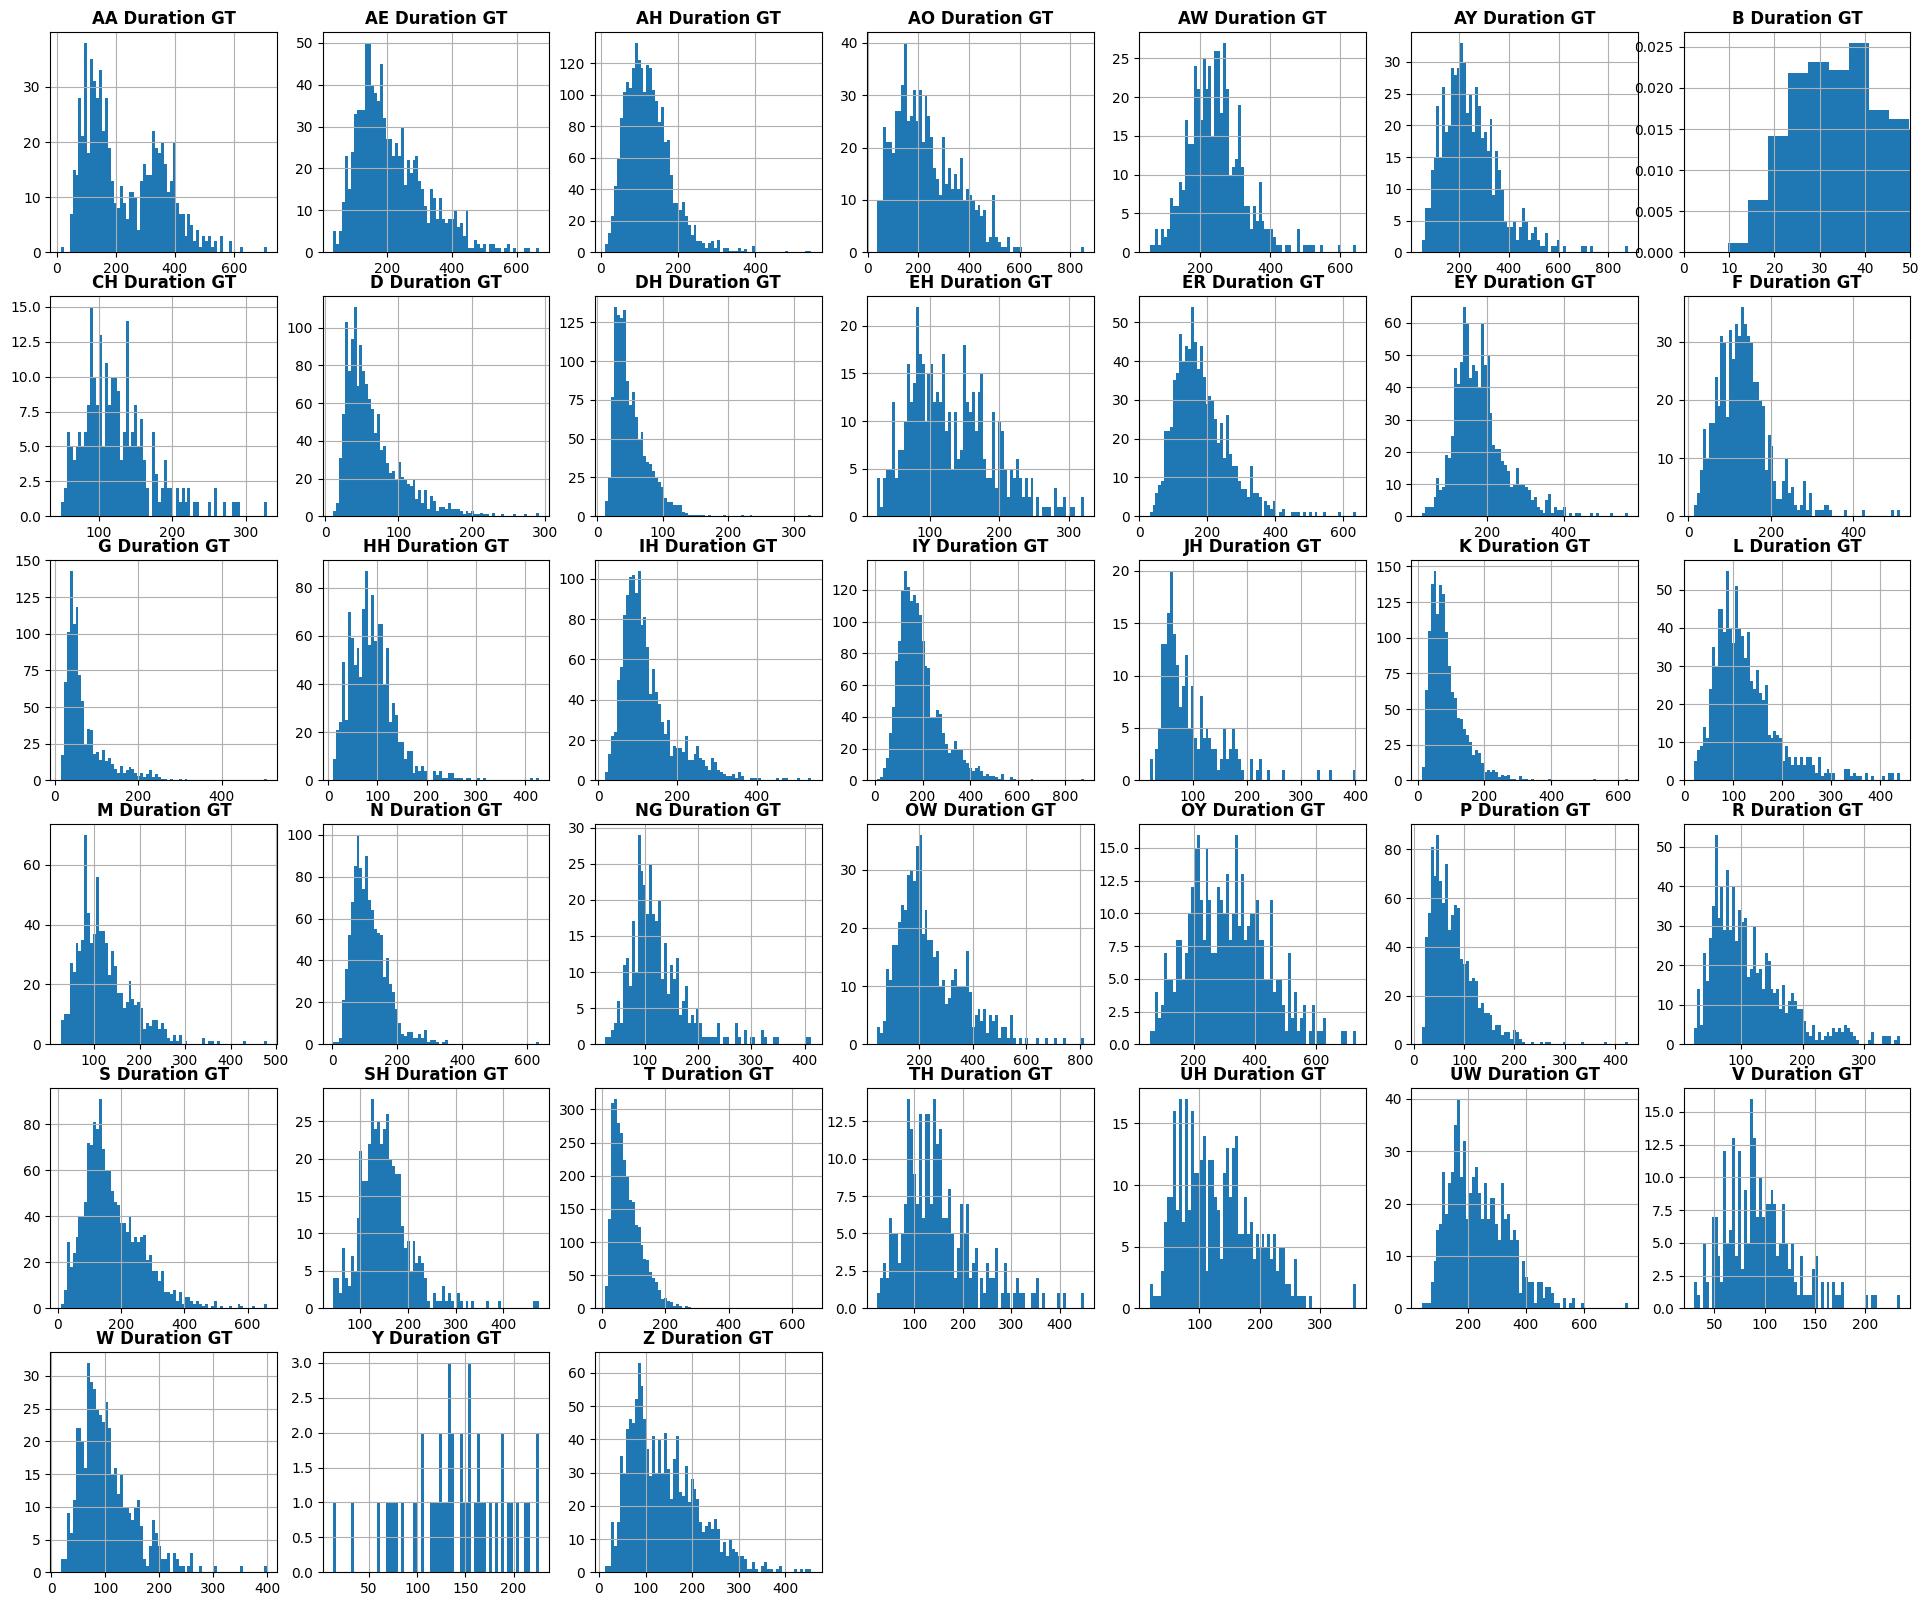

In [32]:
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    plt.subplot(6, 7, ii+1)
    if phone=='B':
        plt.xlim([0, 50])
        plt.hist(phonedurations_man[phone], bins=70, density=True)    
        noccur = len(phonedurations_man[phone])
        print(sum(np.array(phonedurations_man[phone])<30)/noccur)
        print(sum(np.array(phonedurations_man[phone])<50)/noccur)
    else:
        plt.hist(phonedurations_man[phone], bins=70)    
    
    plt.grid()
    plt.title('%s Duration GT' % phone, fontweight='bold')

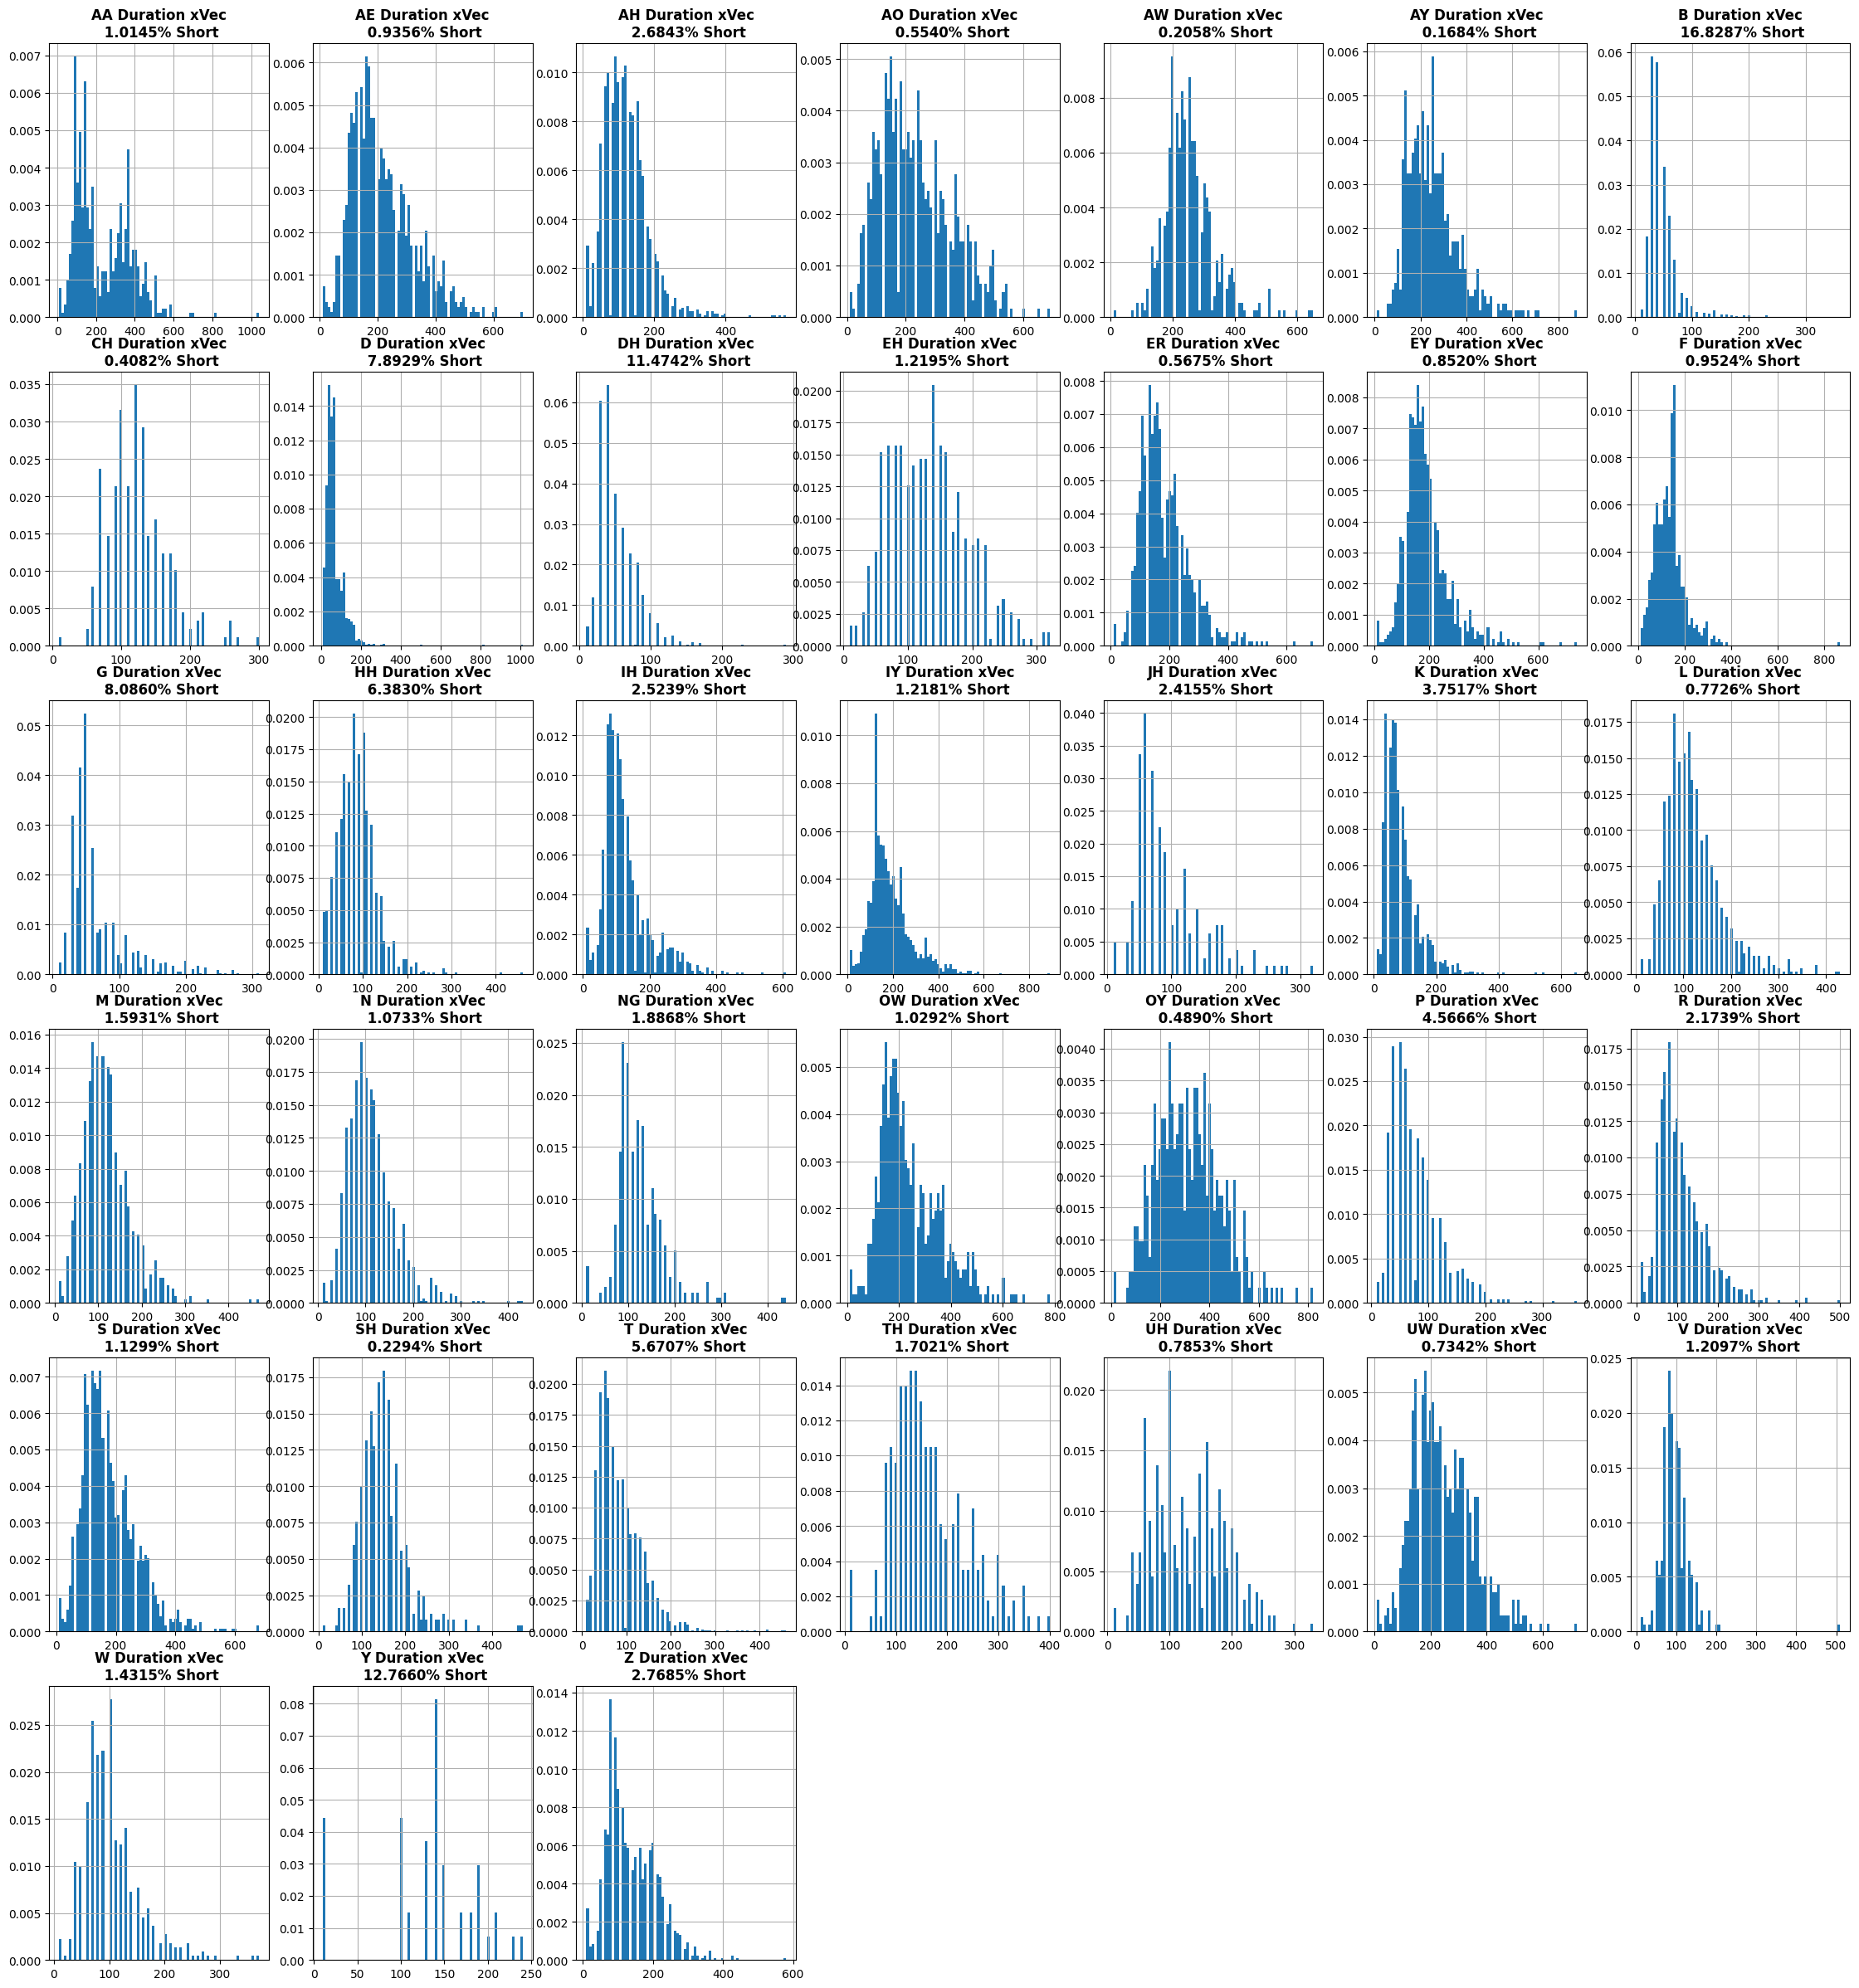

In [12]:
plt.figure(figsize=(28, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(phonedurations[phone], bins=80, density=True)
    # plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(phonedurations[phone])<30)/len(phonedurations[phone])
    plt.title(f"{phone} Duration xVec\n {pct_short:.4f}% Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

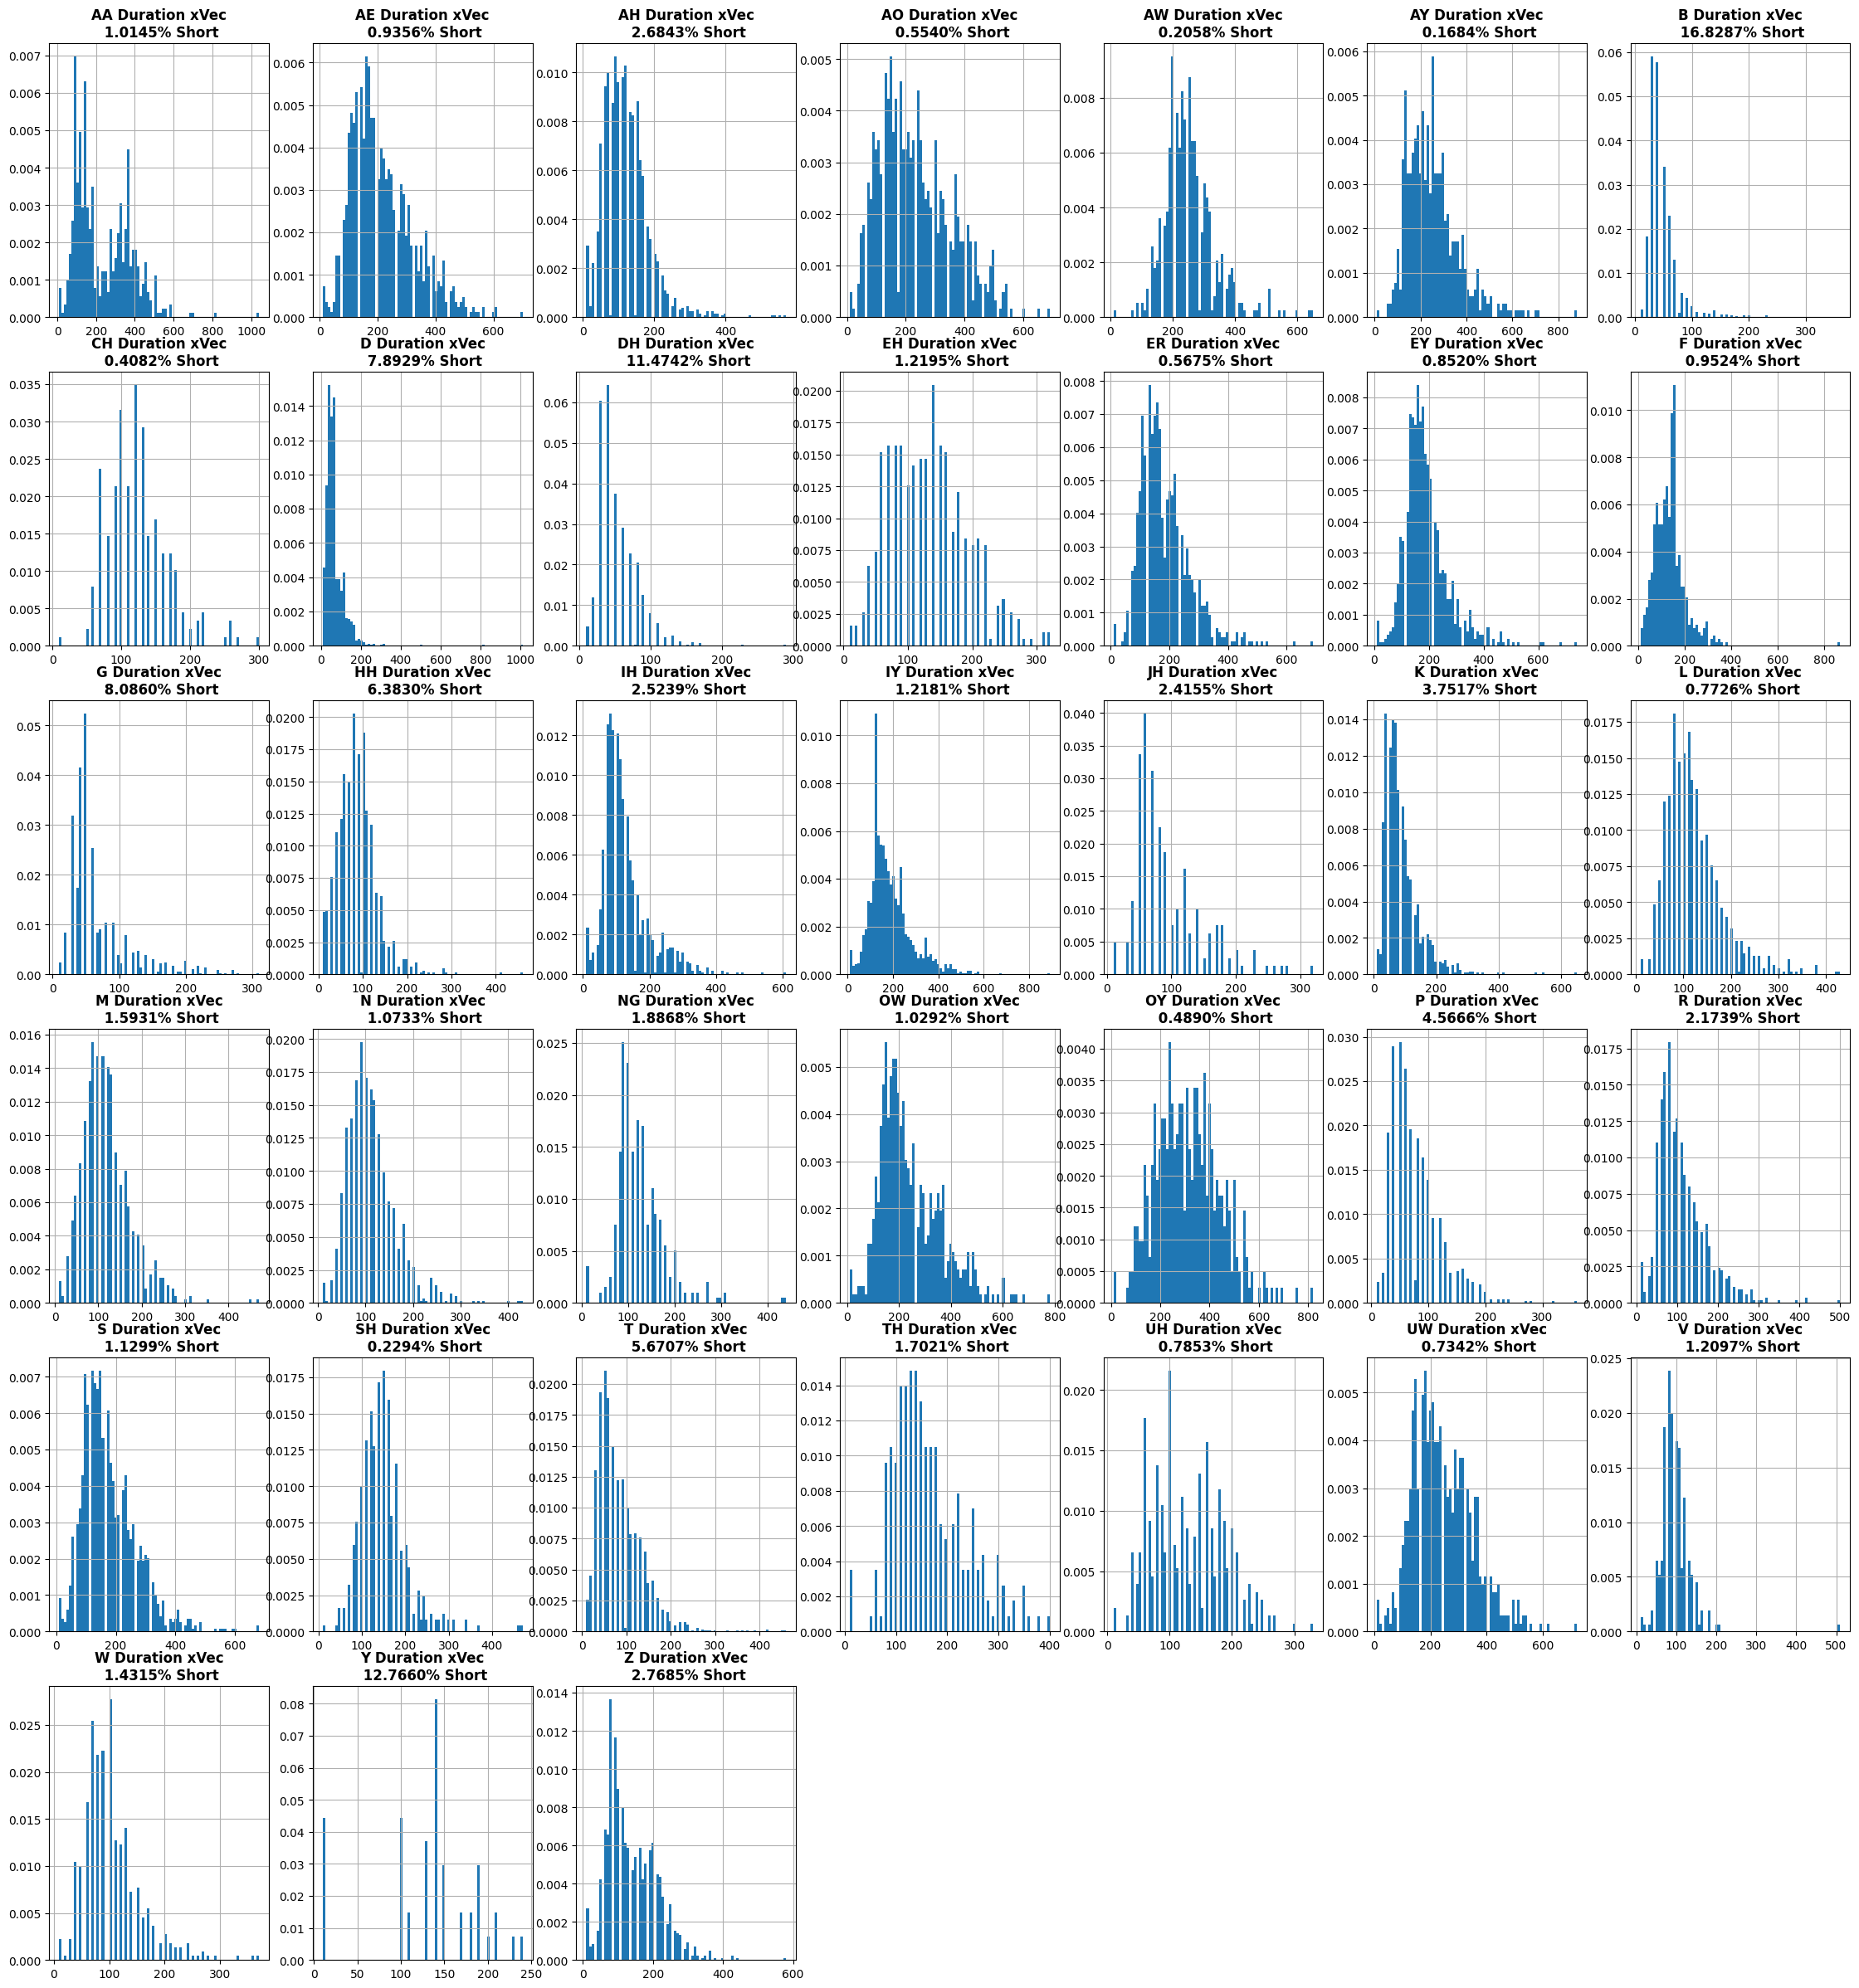

In [13]:
plt.figure(figsize=(28, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(phonedurations[phone], bins=80, density=True)
    # plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(phonedurations[phone])<30)/len(phonedurations[phone])
    plt.title(f"{phone} Duration xVec\n {pct_short:.4f}% Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [ ]:
plt.figure(figsize=(36, 40))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(8, 6, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(phonedurations[phone], bins=80)
    # plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(phonedurations[phone])<30)/len(phonedurations[phone])
    plt.title(f"{phone} Duration xVec\n {pct_short:.4f}% Short", fontweight='bold')
plt.savefig('./phoneduration_lists.png', bbox_inches='tight')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [ ]:
plt.figure(figsize=(30, 28))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(phonedurations[phone], bins=80)
    plt.xlim([0, 50])
    plt.grid()
    numshort = sum(np.array(phonedurations[phone])<30)
    plt.title(f"{phone} Duration xVec\n{numshort:d} Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [13]:
pctile_1st = {}

for phone in ENGLISH_PHONEME_LIST:
    pctile_1st[phone] = np.percentile(phonedurations_man[phone], 0.2)

In [195]:
# 'phone': [phone] * len(durations_gt['frame']), 'duration_gt': durations_gt['frame'], 'duration_est':durations_est['frame'], 
# 'onset_err_frame': onset_err['frame'], 'offset_err_frame': offset_err['frame']
# print(len(durations_gt['frame']))
print(len(durations_est['frame']))
print(len(onset_err['frame']))
print(len(offset_err['frame']))
    

17
17
17


In [ ]:
''' 
TODO:



Create an evaluator class
inputs: 
- manual tg list
- dict of a list of tgs {"aligner_method_name1": tg_list, "aligner_method_name2": tg_list2, ...}



'''


In [146]:
def evaluate_tg_results(method, phone, tglist, tgs_manual, durations_est, onset_err, offset_err, phone_key='phones'):
    est_dur = []
    off_err = []
    on_err = []
    nerr = 0
    on_err_pct = []
    off_err_pct = []
    for tgpath in tglist:
        transcript = get_transcript_from_tgfile(tgpath)
        tg = textgridpath_to_phonedf(tgpath, phone_key=phone_key, remove_numbers=True)
        if not method=='mfa':
            tg = process_silences(tg, transcript)
        tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)

        if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
            metrics = tg_error(tg_gt, tg, phone)
            # print('here')
            # print(metrics)
            # durations_est[method].extend(list(metrics['durations_est'] * 1000))
            # onset_err[method].extend(list(metrics['onset_error'] * 1000))
            # offset_err[method].extend(list(metrics['offset_error'] * 1000))
            on_err_pct.extend(list(100*metrics['onset_error']/metrics['durations_gt']))
            off_err_pct.extend(list(100*metrics['offset_error']/metrics['durations_gt']))
            est_dur.extend(list(metrics['durations_est'] * 1000))
            on_err.extend(list(metrics['onset_error'] * 1000))
            off_err.extend(list(metrics['offset_error'] * 1000))
            
            if any(np.isnan(metrics['onset_error'])):                
                # nfiles_error['frame']+=1
                nerr += 1
            # print(on_err_pct)
            # print(on_err)
    return est_dur, on_err, on_err_pct, off_err, off_err_pct, nerr


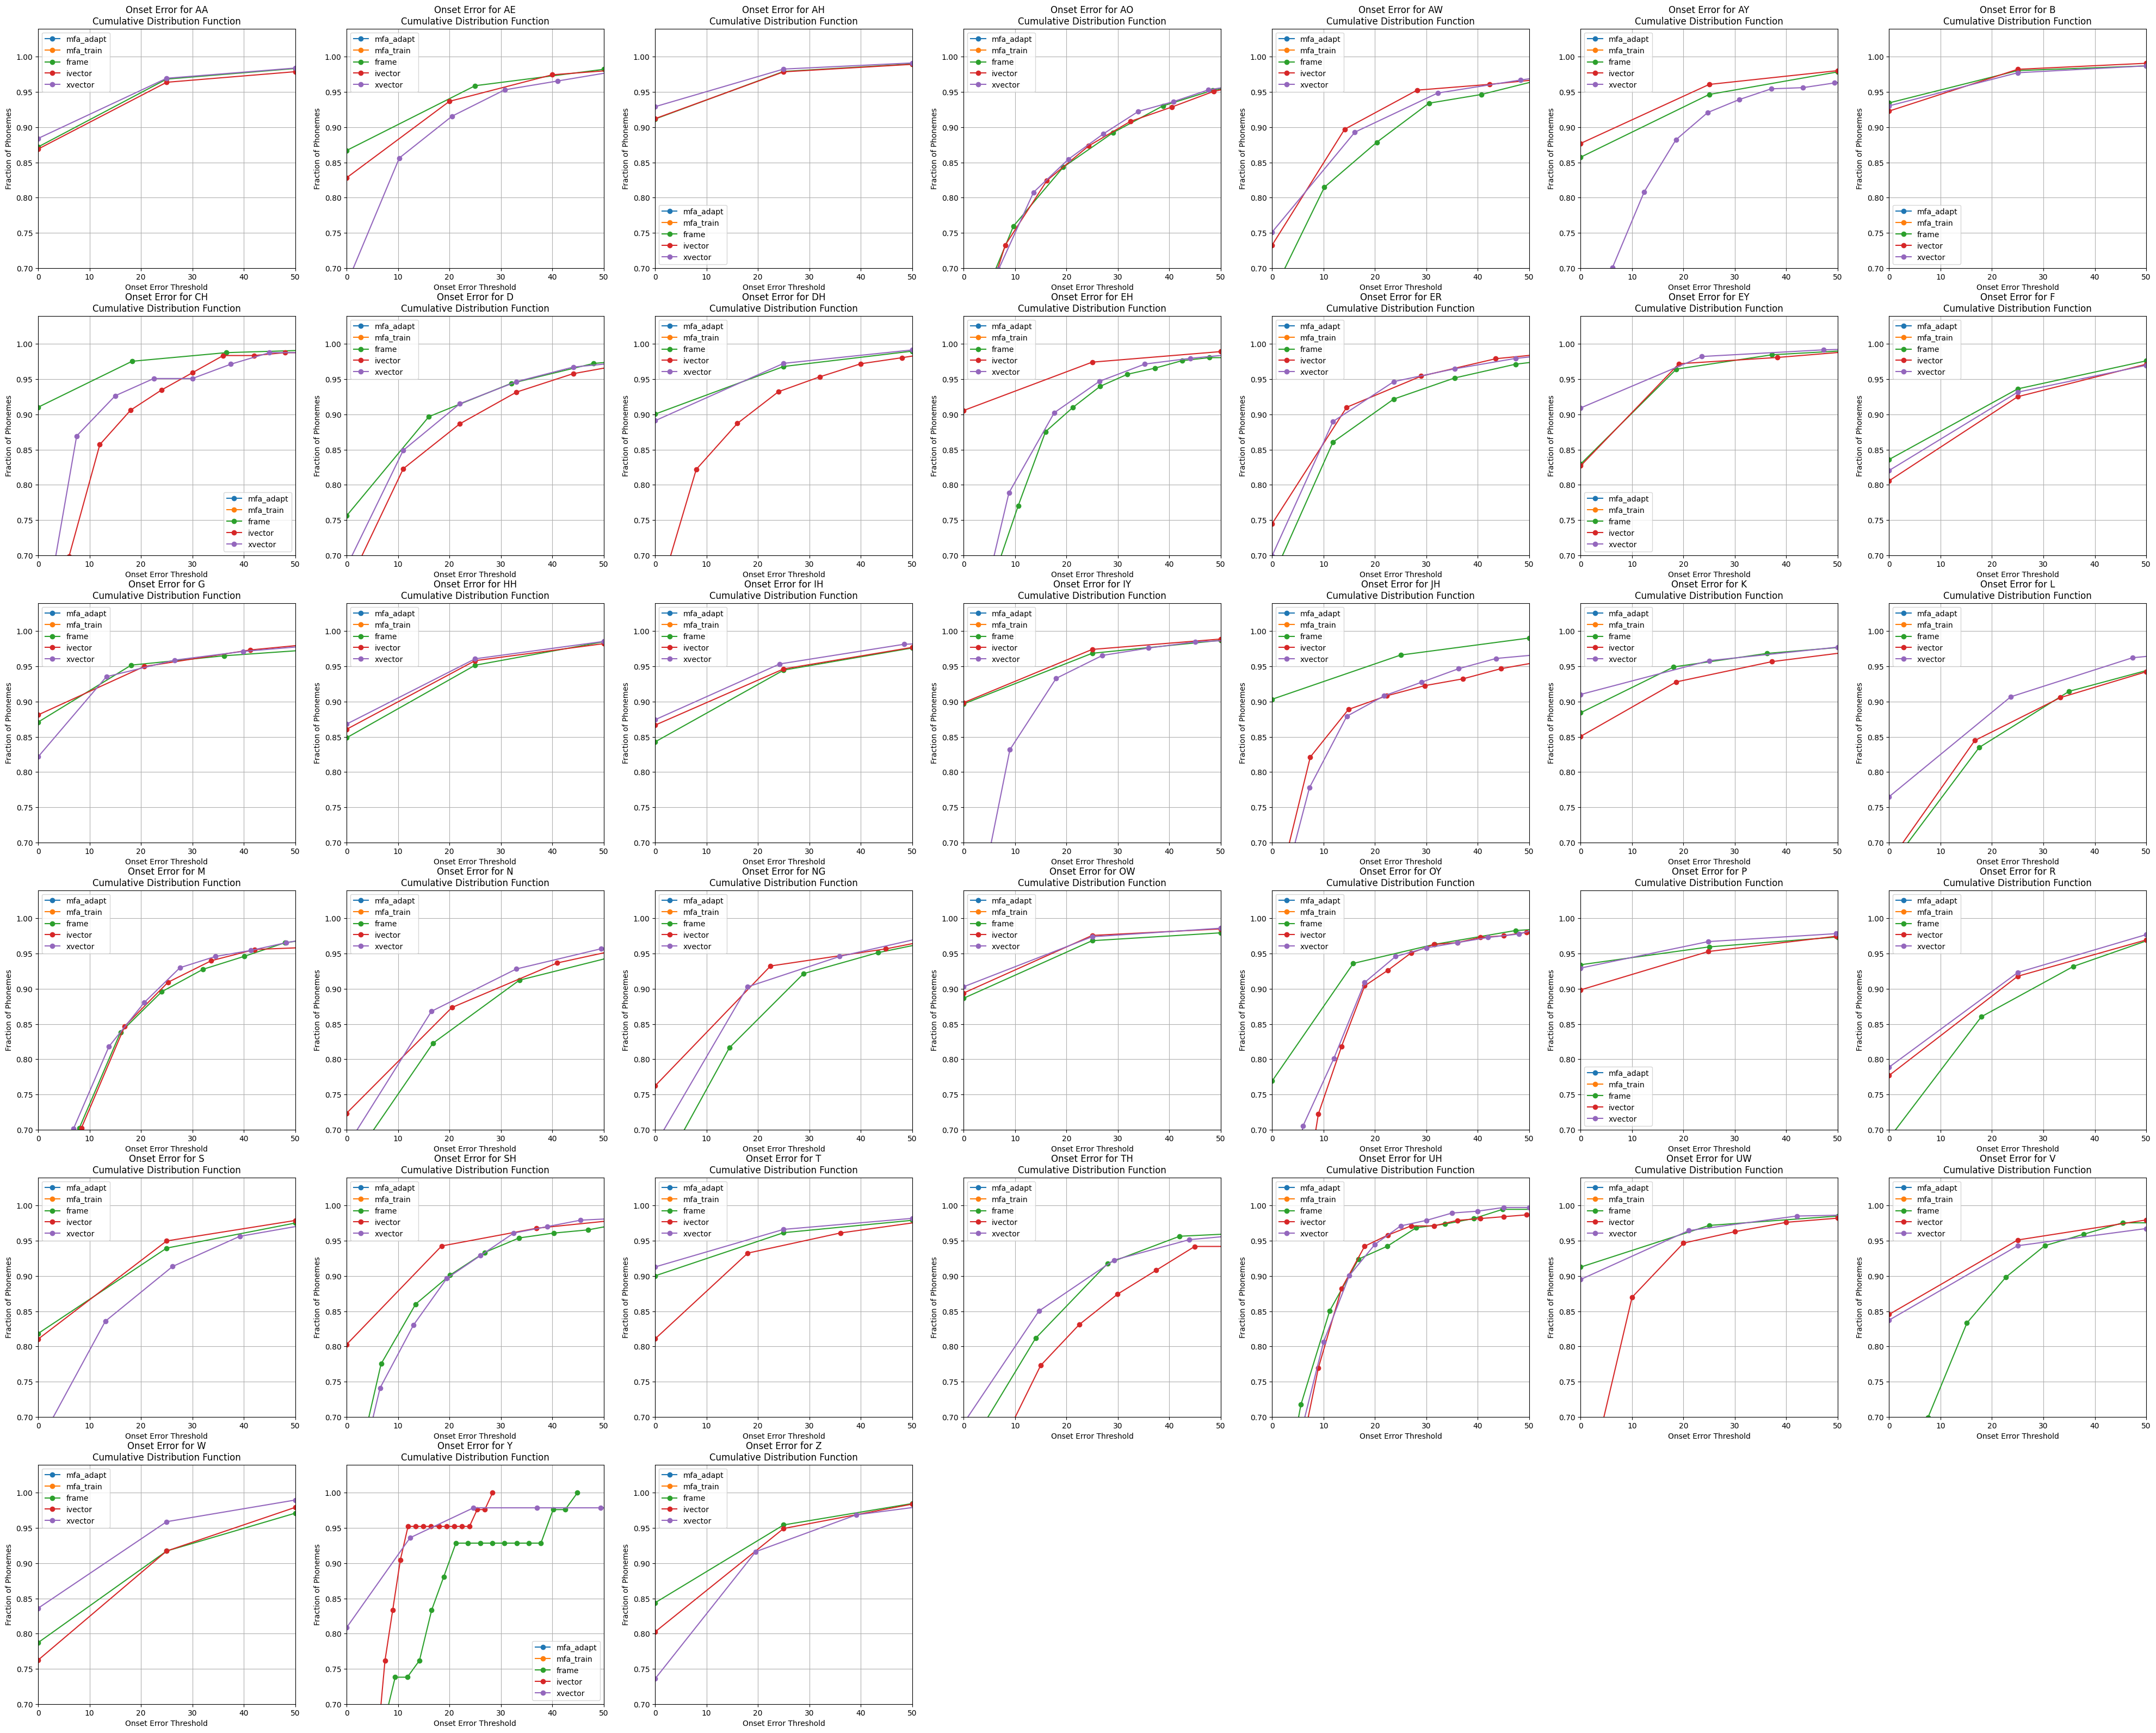

In [339]:
'''

Per phoneme CDF of onset error

'''

import seaborn as sns
idx = 0

plt.figure(figsize=(50, 40))
pct_short_gt = []
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    plt.subplot(6, 7, ii+1)
    for method in methodnames:
        # values = np.abs(np.clip(phone_dfs[ENGLISH_PHONEME_LIST[idx]][method][f'onset_err_pct_{method}'].values, 0, 100))    
        values = np.abs(np.clip(phone_dfs[phone][method][f'onset_err_{method}'].values, 0, 500))    
        values = values[~np.isnan(values)]
        histvals,  bin_edges = np.histogram(values, density=True, bins=20)
        bin_width = bin_edges[1] - bin_edges[0]
        cdf = np.cumsum(histvals)*bin_width

        plt.plot(bin_edges[:-1], cdf, '-o', label=method)
        plt.ylim([.7, 1.04])
        plt.xlim([0, 50])
        plt.grid(True)
        
    plt.title(f'Onset Error for {phone}\nCumulative Distribution Function')
    plt.ylabel('Fraction of Phonemes')
    plt.xlabel('Onset Error Threshold')
    plt.legend()

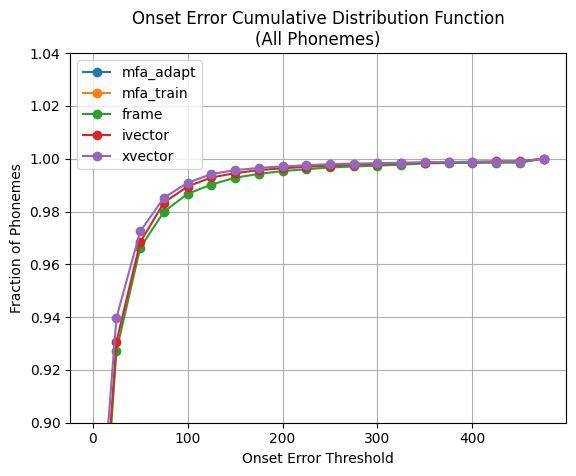

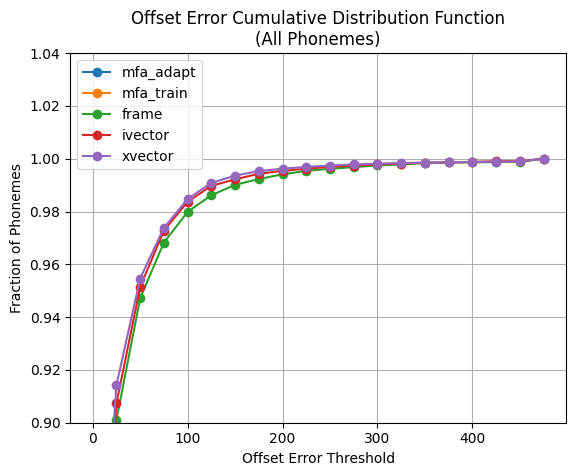

In [338]:
'''

Onset Error CDF (Total)

'''

import seaborn as sns

onset_errors = {}
offset_errors = {}

for method in methodnames:
    onset_errors[method] = []
    offset_errors[method] = []
    
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    for method in methodnames:
        values_on = np.abs(phone_dfs[phone][method][f'onset_err_{method}'].values)    
        values_on = values_on[~np.isnan(values_on)]
        onset_errors[method].extend(values_on)
        
        values_off = np.abs(phone_dfs[phone][method][f'offset_err_{method}'].values)
        values_off = values_off[~np.isnan(values_off)]
        offset_errors[method].extend(values_off)
        
        
        
plt.figure()
for method in methodnames:
    _values = onset_errors[method]
    _values = np.clip(_values, 0, 500)
    histvals,  bin_edges = np.histogram(_values, density=True, bins=20)
    bin_width = bin_edges[1] - bin_edges[0]
    cdf = np.cumsum(histvals) * bin_width
    
    plt.plot(bin_edges[:-1], cdf, '-o', label=method)
    plt.ylim([.9, 1.04])
    plt.grid(True)
        
    plt.title('Onset Error Cumulative Distribution Function\n(All Phonemes)')
    plt.ylabel('Fraction of Phonemes')
    plt.xlabel('Onset Error Threshold')
    plt.legend()

plt.figure()
for method in methodnames:
    _values = offset_errors[method]
    _values = np.clip(_values, 0, 500)
    histvals,  bin_edges = np.histogram(_values, density=True, bins=20)
    bin_width = bin_edges[1] - bin_edges[0]
    cdf = np.cumsum(histvals) * bin_width
    
    plt.plot(bin_edges[:-1], cdf, '-o', label=method)
    plt.ylim([.9, 1.04])
    plt.grid(True)
        
    plt.title('Offset Error Cumulative Distribution Function\n(All Phonemes)')
    plt.ylabel('Fraction of Phonemes')
    plt.xlabel('Offset Error Threshold')
    plt.legend()

In [351]:
print('Onset Error')
for method in methodnames:
    print(f'Method {method}:\t {np.mean(onset_errors[method]):.2f}, Std: {np.std(onset_errors[method]):.2f}')
    print()

print('Offset Error')
for method in methodnames:
    print(f'Method {method}:\t {np.mean(offset_errors[method]):.2f}, Std: {np.std(offset_errors[method]):.2f}')
    print()


Onset Error
Method mfa_adapt:	 nan, Std: nan

Method mfa_train:	 nan, Std: nan

Method frame:	 19.39, Std: 41.08

Method ivector:	 18.64, Std: 38.02

Method xvector:	 17.51, Std: 36.33

Offset Error
Method mfa_adapt:	 nan, Std: nan

Method mfa_train:	 nan, Std: nan

Method frame:	 22.58, Std: 42.46

Method ivector:	 21.65, Std: 38.86

Method xvector:	 20.70, Std: 39.22



/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [316]:
'''
Figure 2:

Age vs Alignment Error
- generate per phoneme
- generate aggregated across all phonemes

'''


'\nFigure 2:\n\nAge vs Alignment Error\n- generate per phoneme\n- generate aggregated across all phonemes\n\n'

In [343]:
                tgs_method = get_all_textgrids_in_directory(os.path.join('./results_mfa_train', speakerid), verbose=False)


In [335]:
# if not (os.path.exists('./outputs/gt_dfs.pkl') and os.path.exists('./outputs/phone_accuracy_dfs.pkl')):
    
methodnames = ['mfa_adapt', 'mfa_train', 'frame', 'ivector', 'xvector']
phone_durations = {}
phone_onset_err = {}
phone_offset_err = {}
phone_ids = {}
age = {}
nexclude_per = {}
phone_dfs = {}

for method in methodnames:
    phone_dfs[method] = {}

finish=False
gt_dfs = {}

for phone in tqdm.tqdm(ENGLISH_PHONEME_LIST):
    print('Calculating error for phone:\t', phone)
    durations_gt = {}
    durations_est = {}
    onset_err = {}
    offset_err = {}
    
    onset_err_pct = {}
    offset_err_pct = {}
    
    nfiles_error = {}

    phone_dfs[phone] = {}

    for method in methodnames:
        phone_ids[method] = []
        durations_est[method] = []
        durations_gt[method] = []
        
        onset_err[method] = []
        offset_err[method] = []    
        
        onset_err_pct[method] = []
        offset_err_pct[method] = []
        
        nfiles_error[method] = 0

        start_gt = []
        end_gt = []
        speaker_id_list_manual = []
        speaker_id_list_method = []

        for speakerid in list(satdf.index):

            tgs_manual = get_all_textgrids_in_directory(os.path.join('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/', speakerid), verbose=False)
            if method=='frame':
                tgs_method = get_all_textgrids_in_directory(os.path.join('./results_frame_10epochs', speakerid), verbose=False) 
            elif method=='xvector':
                tgs_method = get_all_textgrids_in_directory(os.path.join('./phone_matched_xvec_proj_textgrids', speakerid), verbose=False)
            elif method=='ivector':
                tgs_method = get_all_textgrids_in_directory(os.path.join('./results_sat', speakerid), verbose=False)
            elif method=='mfa_train':
                tgs_method = get_all_textgrids_in_directory(os.path.join('./results_mfa_train', speakerid), verbose=False)
            elif method=='mfa_adapt':
                tgs_method = get_all_textgrids_in_directory(os.path.join('./results_mfa_adapted', speakerid), verbose=False)

            for manual_tgpath in tgs_manual:
                manual_tg = textgridpath_to_phonedf(manual_tgpath, phone_key='ha phones', remove_numbers=True)
                gtstart, gtend = get_phone_startend(manual_tg, phone, loc=2)
                durations_gt[method].extend(list((gtend - gtstart) * 1000))
                speaker_id_list_manual.extend([speakerid] * len(gtstart))
                start_gt.extend(list(gtstart * 1000))
                end_gt.extend(list(gtend * 1000))
            
            est_dur, on_err, on_err_pct, off_err, off_err_pct, nerr = evaluate_tg_results(method, phone, tgs_method, tgs_manual, durations_est, onset_err, offset_err)
            onset_err[method].extend(on_err)
            offset_err[method].extend(off_err)
            onset_err_pct[method].extend(on_err_pct)
            offset_err_pct[method].extend(off_err_pct)
            durations_est[method].extend(est_dur)
            nfiles_error[method] += nerr    
            speaker_id_list_method.extend([speakerid] * len(est_dur))
        df_gt = pd.DataFrame.from_dict({'phone': [phone]* len(durations_gt[method]), 'speakerid': speaker_id_list_manual,
                                        'start_time': start_gt, 'end_time': end_gt})
        df_method = pd.DataFrame.from_dict({'phone':[phone]*len(durations_est[method]), 'speakerid':speaker_id_list_method,
                                            f'durations_est_{method}':durations_est[method], 
                                            f'onset_err_{method}': onset_err[method], 
                                            f'offset_err_{method}': offset_err[method], 
                                            f'onset_err_pct_{method}':onset_err_pct[method], 
                                            f'offset_err_pct_{method}':offset_err_pct[method]})

        gt_dfs[phone] = df_gt
        phone_dfs[phone][method] = df_method

  0%|                                                                                                                                                                                                                               | 0/38 [00:00<?, ?it/s]

Calculating error for phone:	 AA


  3%|█████▋                                                                                                                                                                                                                 | 1/38 [01:30<55:54, 90.66s/it]

Calculating error for phone:	 AE


  5%|███████████▎                                                                                                                                                                                                           | 2/38 [03:02<54:58, 91.63s/it]

Calculating error for phone:	 AH


  8%|████████████████▉                                                                                                                                                                                                      | 3/38 [04:36<53:52, 92.37s/it]

Calculating error for phone:	 AO


 11%|██████████████████████▋                                                                                                                                                                                                | 4/38 [06:08<52:15, 92.22s/it]

Calculating error for phone:	 AW


 13%|████████████████████████████▎                                                                                                                                                                                          | 5/38 [07:39<50:37, 92.06s/it]

Calculating error for phone:	 AY


 16%|█████████████████████████████████▉                                                                                                                                                                                     | 6/38 [09:11<49:03, 91.98s/it]

Calculating error for phone:	 B


 18%|███████████████████████████████████████▌                                                                                                                                                                               | 7/38 [10:43<47:33, 92.04s/it]

Calculating error for phone:	 CH


 21%|█████████████████████████████████████████████▎                                                                                                                                                                         | 8/38 [12:13<45:37, 91.24s/it]

Calculating error for phone:	 D


 24%|██████████████████████████████████████████████████▉                                                                                                                                                                    | 9/38 [13:45<44:15, 91.57s/it]

Calculating error for phone:	 DH


 26%|████████████████████████████████████████████████████████▎                                                                                                                                                             | 10/38 [15:18<42:50, 91.79s/it]

Calculating error for phone:	 EH


 29%|█████████████████████████████████████████████████████████████▉                                                                                                                                                        | 11/38 [16:47<41:02, 91.19s/it]

Calculating error for phone:	 ER


 32%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 12/38 [18:16<39:12, 90.48s/it]

Calculating error for phone:	 EY


 34%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 13/38 [19:45<37:25, 89.83s/it]

Calculating error for phone:	 F


 37%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 14/38 [21:16<36:06, 90.26s/it]

Calculating error for phone:	 G


 39%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 15/38 [22:50<35:02, 91.41s/it]

Calculating error for phone:	 HH


 42%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 16/38 [24:22<33:36, 91.67s/it]

Calculating error for phone:	 IH


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 17/38 [25:54<32:03, 91.61s/it]

Calculating error for phone:	 IY


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 18/38 [27:25<30:31, 91.56s/it]

Calculating error for phone:	 JH


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 19/38 [28:56<28:55, 91.32s/it]

Calculating error for phone:	 K


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 20/38 [30:27<27:23, 91.31s/it]

Calculating error for phone:	 L


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 21/38 [32:02<26:11, 92.46s/it]

Calculating error for phone:	 M


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 22/38 [33:34<24:35, 92.22s/it]

Calculating error for phone:	 N


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 23/38 [35:06<23:02, 92.20s/it]

Calculating error for phone:	 NG


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 24/38 [36:38<21:29, 92.11s/it]

Calculating error for phone:	 OW


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 25/38 [38:09<19:53, 91.81s/it]

Calculating error for phone:	 OY


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/38 [39:40<18:19, 91.59s/it]

Calculating error for phone:	 P


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 27/38 [41:13<16:50, 91.85s/it]

Calculating error for phone:	 R


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 28/38 [42:44<15:17, 91.71s/it]

Calculating error for phone:	 S


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 29/38 [44:16<13:47, 91.93s/it]

Calculating error for phone:	 SH


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 30/38 [45:47<12:11, 91.45s/it]

Calculating error for phone:	 T


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 31/38 [47:21<10:44, 92.14s/it]

Calculating error for phone:	 TH


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 32/38 [48:52<09:10, 91.82s/it]

Calculating error for phone:	 UH


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 33/38 [50:23<07:38, 91.66s/it]

Calculating error for phone:	 UW


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 34/38 [51:54<06:06, 91.60s/it]

Calculating error for phone:	 V


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 35/38 [53:24<04:33, 91.06s/it]

Calculating error for phone:	 W


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 36/38 [54:55<03:02, 91.06s/it]

Calculating error for phone:	 Y


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 37/38 [56:24<01:30, 90.35s/it]

Calculating error for phone:	 Z


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [57:56<00:00, 91.49s/it]


In [336]:
pkl.dump(phone_dfs, open('./outputs/phone_accuracy_dfs_mfa_train_adapt_included.pkl', 'wb'))

In [ ]:
if not (os.path.exists('./outputs/gt_dfs.pkl') and os.path.exists('./outputs/phone_accuracy_dfs.pkl')):
    phone_durations = {}
    phone_onset_err = {}
    phone_offset_err = {}
    phone_ids = {}
    age = {}
    nexclude_per = {}

    phone_dfs = {'frame': {}, 'ivector': {}, 'xvector': {}}
    finish = False

    gt_dfs = {}
    for phone in tqdm.tqdm(ENGLISH_PHONEME_LIST):
        print('Calculating error for phone: \t ', phone)
        durations_gt = {}
        durations_est = {}
        onset_err = {}
        offset_err = {}

        nfiles_error = {}

        phone_dfs[phone] = {}

        phone_ids['frame'] = []
        phone_ids['ivector'] = []
        phone_ids['xvector'] = []
        phone_ids['mfa'] = []
        
        durations_est['frame'] = []
        durations_est['ivector'] = []
        durations_est['xvector'] = []
        durations_est['mfa'] = []
        

        durations_gt['frame'] = []
        durations_gt['ivector'] = []
        durations_gt['xvector'] = []
        durations_gt['mfa'] = []
        
        onset_err['frame'] = []
        onset_err['ivector'] = []
        onset_err['xvector'] = []
        onset_err['mfa'] = []
        
        offset_err['frame'] = []    
        offset_err['ivector'] = []
        offset_err['xvector'] = []
        offset_err['mfa'] = []
        
        nfiles_error['frame'] = 0
        nfiles_error['ivector'] = 0
        nfiles_error['xvector'] = 0 
        nfiles_error['mfa'] = 0

        start_gt = []
        end_gt = []
        durations_gt = []
        speaker_id = []
        #iterate over speakers
        for speakerid in list(satdf.index):
            # print('Analyzing speaker:    ', speakerid)
            # print(speakerid)
            tgs_manual = get_all_textgrids_in_directory(os.path.join('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/', speakerid), verbose=False)
            tgs_frame = get_all_textgrids_in_directory(os.path.join('./results_frame_10epochs', speakerid), verbose=False)
            tgs_xv = get_all_textgrids_in_directory(os.path.join('./phone_matched_xvec_proj_textgrids', speakerid), verbose=False)
            tgs_iv = get_all_textgrids_in_directory(os.path.join('./results_sat', speakerid), verbose=False)
            tgs_mfa = get_all_textgrids_in_directory(os.path.join('./results_mfa_adapted', speakerid), verbose=False)

            for manual_tgpath in tgs_manual:
                manual_tg = textgridpath_to_phonedf(manual_tgpath, phone_key='ha phones', remove_numbers=True)
                gtstart, gtend = get_phone_startend(manual_tg, phone, loc=2)
                durations_gt.extend(list((gtend - gtstart) * 1000))
                speaker_id.extend([speakerid] * len(gtstart * 1000))
                start_gt.extend(list(gtstart * 1000))
                end_gt.extend(list(gtend * 1000))
                
            
            
            est_dur, on_err, off_err, nerr = evaluate_tg_results('frame', phone, tgs_frame, tgs_manual, durations_est, onset_err, offset_err)
            onset_err['frame'].extend(on_err)
            offset_err['frame'].extend(off_err)
            durations_est['frame'].extend(est_dur)
            nfiles_error['frame'] += nerr
            est_dur, on_err, off_err, nerr = evaluate_tg_results('ivector', phone, tgs_iv, tgs_manual, durations_est, onset_err, offset_err)
            onset_err['ivector'].extend(on_err)
            offset_err['ivector'].extend(off_err)
            durations_est['ivector'].extend(est_dur)
            nfiles_error['ivector'] += nerr
            est_dur, on_err, off_err, nerr = evaluate_tg_results('xvector', phone, tgs_xv, tgs_manual, durations_est, onset_err, offset_err)
            onset_err['xvector'].extend(on_err)
            offset_err['xvector'].extend(off_err)
            durations_est['xvector'].extend(est_dur)
            nfiles_error['xvector'] += nerr
            est_dur, on_err, off_err, nerr = evaluate_tg_results('mfa', phone, tgs_mfa, tgs_manual, durations_est, onset_err, offset_err)
            onset_err['mfa'].extend(on_err)
            offset_err['mfa'].extend(off_err)
            durations_est['mfa'].extend(est_dur)
            nfiles_error['mfa'] += nerr

#             for tgpath in tgs_frame:
#                 transcript = get_transcript_from_tgfile(tgpath)
#                 tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
#                 # tg = process_silence(tg, transcript)
                
#                 tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)
                
#                 if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
#                     metrics = tg_error(tg_gt, tg, phone)
#                     # print('-----------')
#                     durations_est['frame'].extend(list(metrics['durations_est'] * 1000))
#                     onset_err['frame'].extend(list(metrics['onset_error'] * 1000))
#                     offset_err['frame'].extend(list(metrics['offset_error'] * 1000))

#                     if any(np.isnan(metrics['onset_error'])):                
#                         nfiles_error['frame']+=1
#                         # print(tgpath)


#             for tgpath in tgs_iv:
#                 transcript = get_transcript_from_tgfile(tgpath)
#                 tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
#                 # tg = process_silence(tg, transcript)
                
#                 tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)

#                 if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
#                     metrics = tg_error(tg_gt, tg, phone)
#                     # print('-----------')
#                     durations_est['ivector'].extend(list(metrics['durations_est'] * 1000))
#                     onset_err['ivector'].extend(list(metrics['onset_error'] * 1000))
#                     offset_err['ivector'].extend(list(metrics['offset_error'] * 1000))

#                     if any(np.isnan(metrics['onset_error'])):                
#                         nfiles_error['ivector'] += 1

#             finished = False
#             for tgpath in tgs_xv:
#                 transcript = get_transcript_from_tgfile(tgpath)
#                 tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
#                 # tg = process_silence(tg, transcript)
                
#                 tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)

#                 if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
#                     metrics = tg_error(tg_gt, tg, phone)
#                     # print('-----------')
#                     durations_est['xvector'].extend(list(metrics['durations_est'] * 1000))
#                     onset_err['xvector'].extend(list(metrics['onset_error'] * 1000))
#                     offset_err['xvector'].extend(list(metrics['offset_error'] * 1000))

#                     if any(np.isnan(metrics['onset_error'])):
#                         nfiles_error['xvector'] += 1
            # if finished:
                # break

        # if finished:
            # break
        df_gt = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt), 'speakerid': speaker_id, 'start_time': start_gt, 'end_time': end_gt})
        # df_frame = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['frame']), 'duration_gt': durations_gt['frame'], 'duration_est':durations_est['frame'], 
        df_frame = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['frame']), 'duration_est':durations_est['frame'], 'onset_err_frame': onset_err['frame'], 'offset_err_frame': offset_err['frame']})

        # df_ivec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['ivector']), 'durations_gt':durations_gt['ivector'], 'duration_est_ivector': durations_est['ivector'], 
        df_ivec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['ivector']), 'duration_est_ivector': durations_est['ivector'], 
                                          'onset_err_ivector': onset_err['ivector'], 'offset_err_ivector': offset_err['ivector']})

        # df_xvec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['xvector']), 'durations_gt':durations_gt['xvector'], 'durations_est_xvector': durations_est['xvector'], 
        df_xvec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['xvector']), 'duration_est_xvector': durations_est['xvector'], 
                                          'onset_err_xvector': onset_err['xvector'], 'offset_err_xvector': offset_err['xvector']})

        df_mfa = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['mfa']), 'duration_est_mfa': durations_est['mfa'], 
                                  'onset_err_mfa': onset_err['mfa'], 'offset_err_mfa': offset_err['mfa']})
            
        gt_dfs[phone] = df_gt
        phone_dfs[phone]['frame'] = df_frame
        phone_dfs[phone]['ivector'] = df_ivec
        phone_dfs[phone]['xvector'] = df_xvec
        phone_dfs[phone]['mfa'] = df_mfa
else:
    gt_dfs = pkl.load(open('./outputs/gt_dfs.pkl', 'rb'))

    phone_dfs = pkl.load(open('./outputs/phone_accuracy_dfs.pkl', 'rb'))

In [88]:
# pct_short_ivec = []
pct_short_dct = {}
methods = ['gt', 'mfa', 'frame', 'ivector', 'xvector']

for method in methods:
    pct_short_dct[method] = {}
    for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
        if method=='gt':
            durations = gt_dfs[phone]['duration'].values
        else:
            if method=='frame':
                durations = phone_dfs[phone][method][f'duration_est'].values
            else:
                durations = phone_dfs[phone][method][f'duration_est_{method}'].values
            
        durations = durations[~np.isnan(durations)]
        pct_short = 100*sum(np.array(durations<=35))/sum(~np.isnan(durations))
        pct_short_dct[method][phone] = pct_short
        
pct_short_df = pd.DataFrame.from_dict(pct_short_dct)
pct_short_df.to_csv('./outputs/pct_short_df.csv')

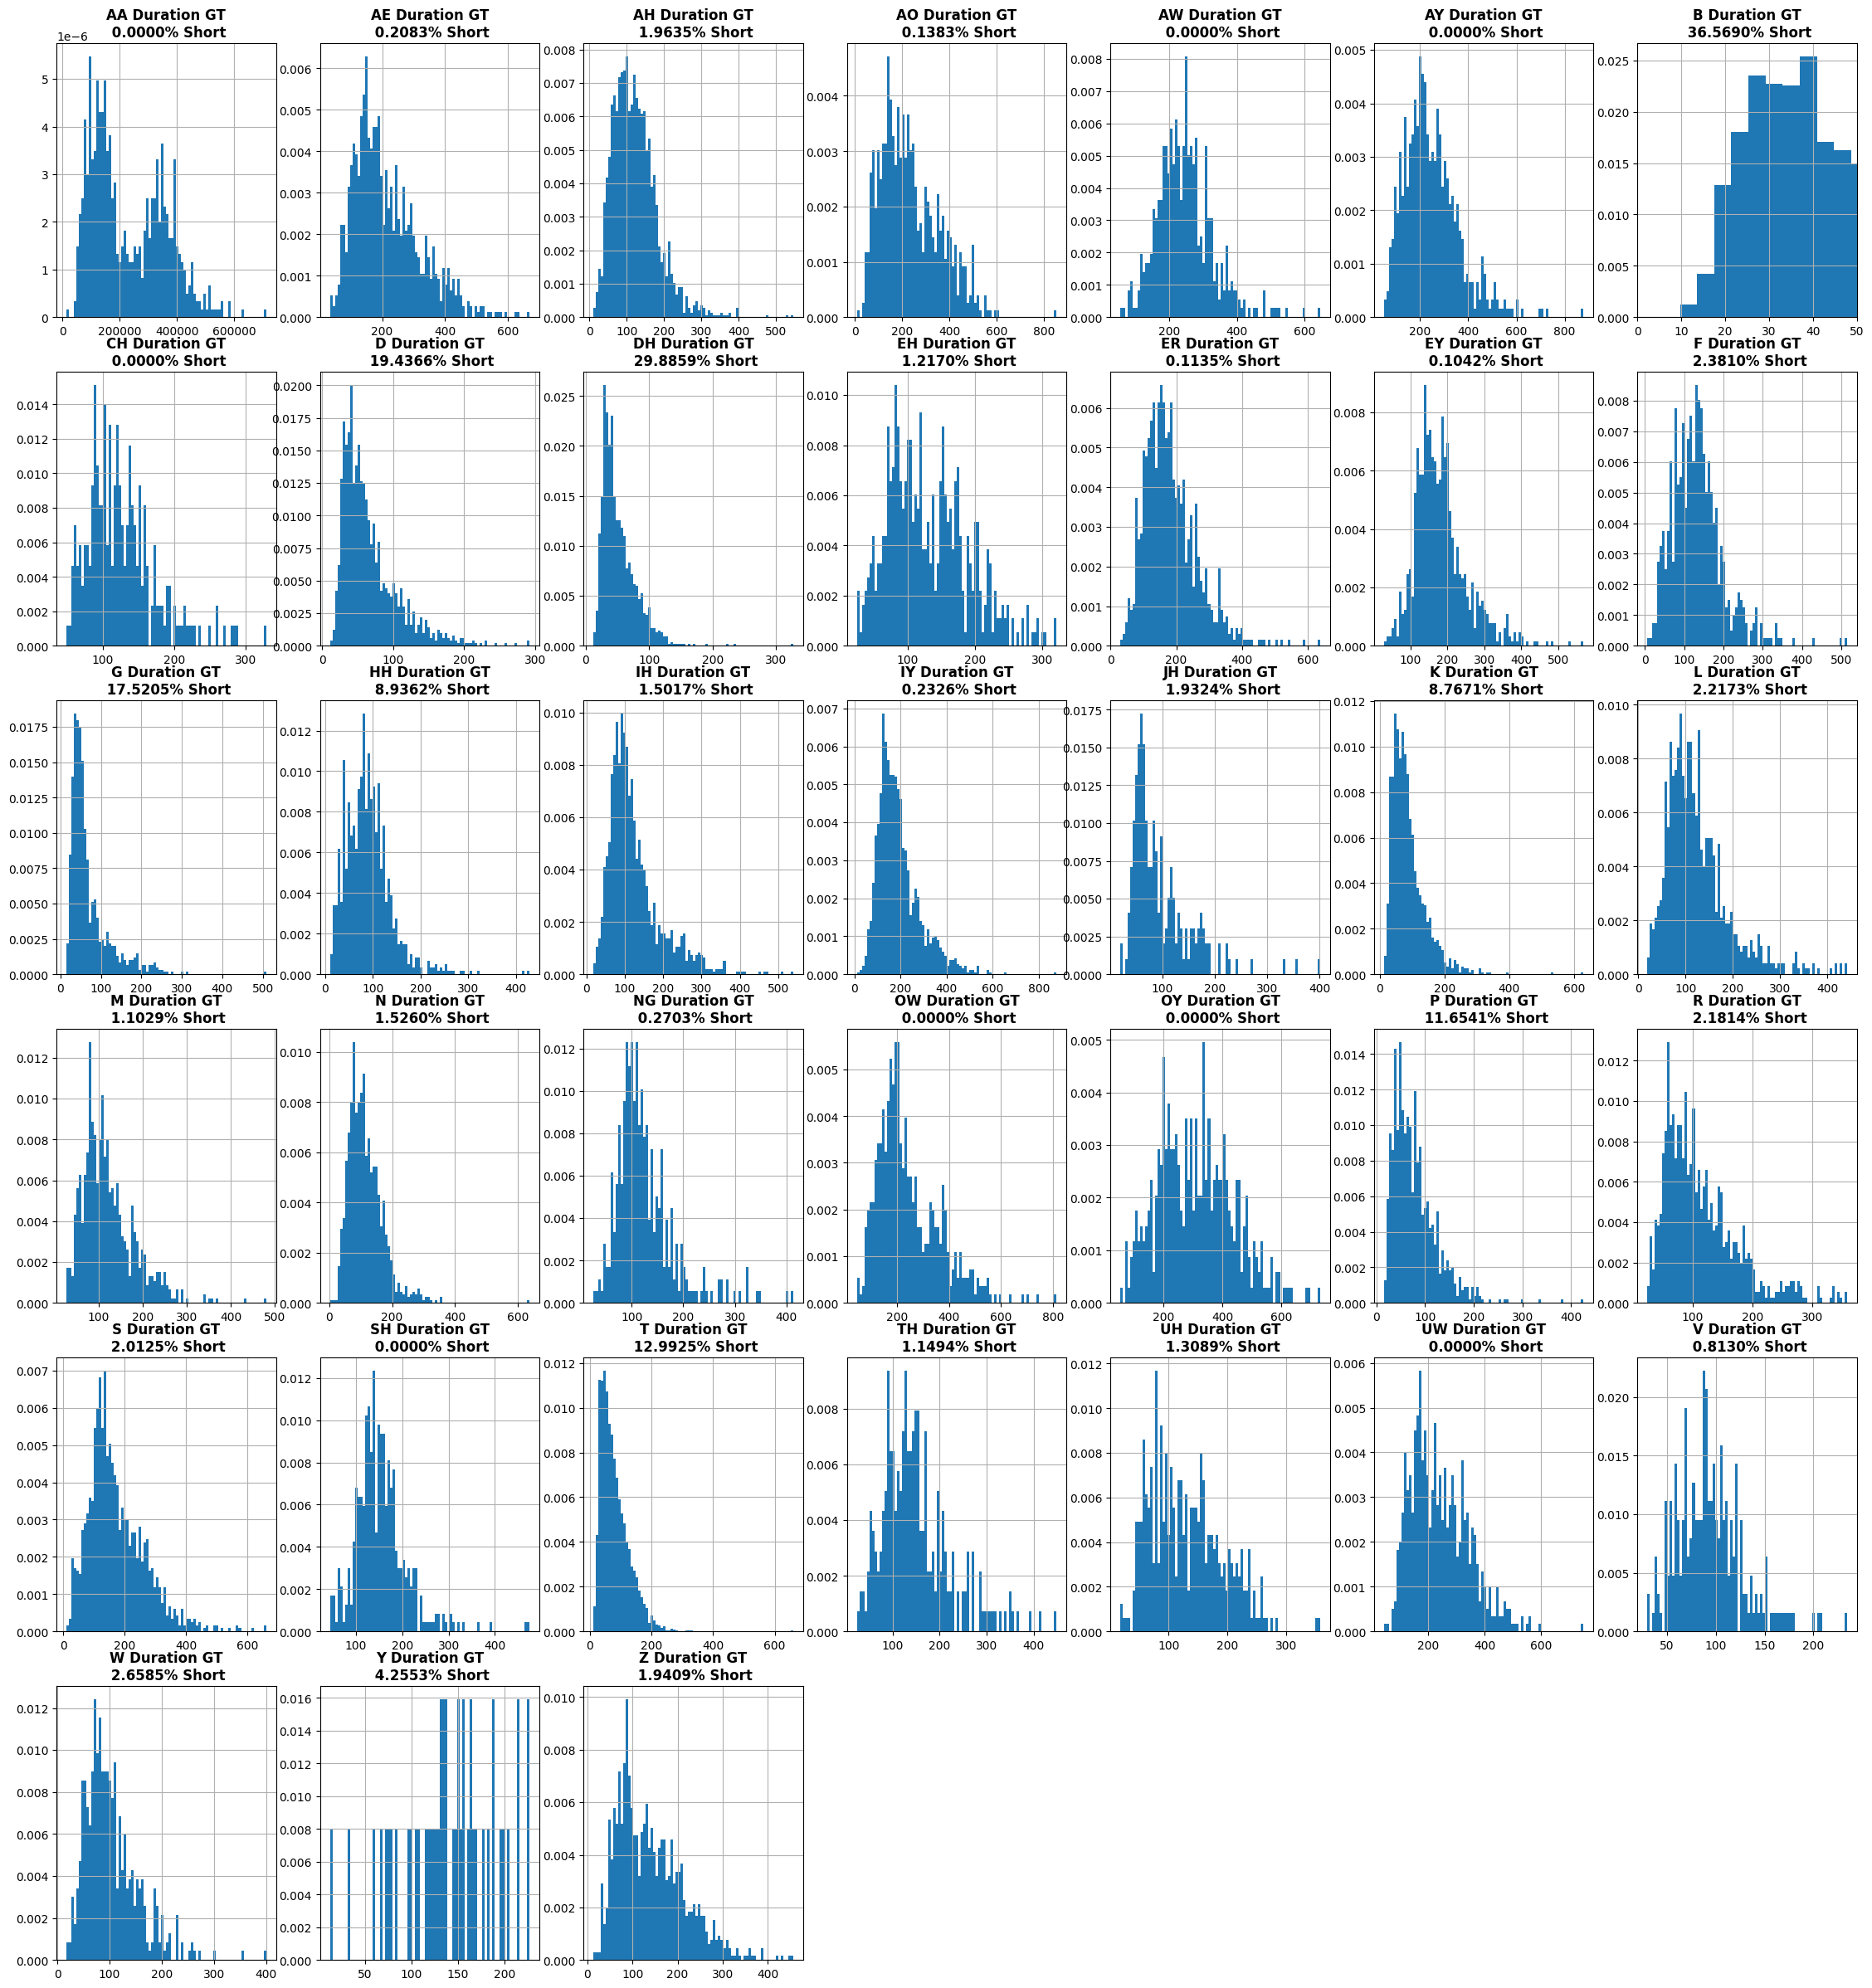

In [63]:
plt.figure(figsize=(28, 30))
pct_short_gt = []
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    durations = gt_dfs[phone]['duration'].values
    durations = durations[~np.isnan(durations)]
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(durations, bins=80, density=True)
    if phone=='B':
        plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(durations<=35))/sum(~np.isnan(durations))
    pct_short_gt.append(pct_short)
    plt.title(f"{phone} Duration GT\n {pct_short:.4f}% Short", fontweight='bold')
plt.show()

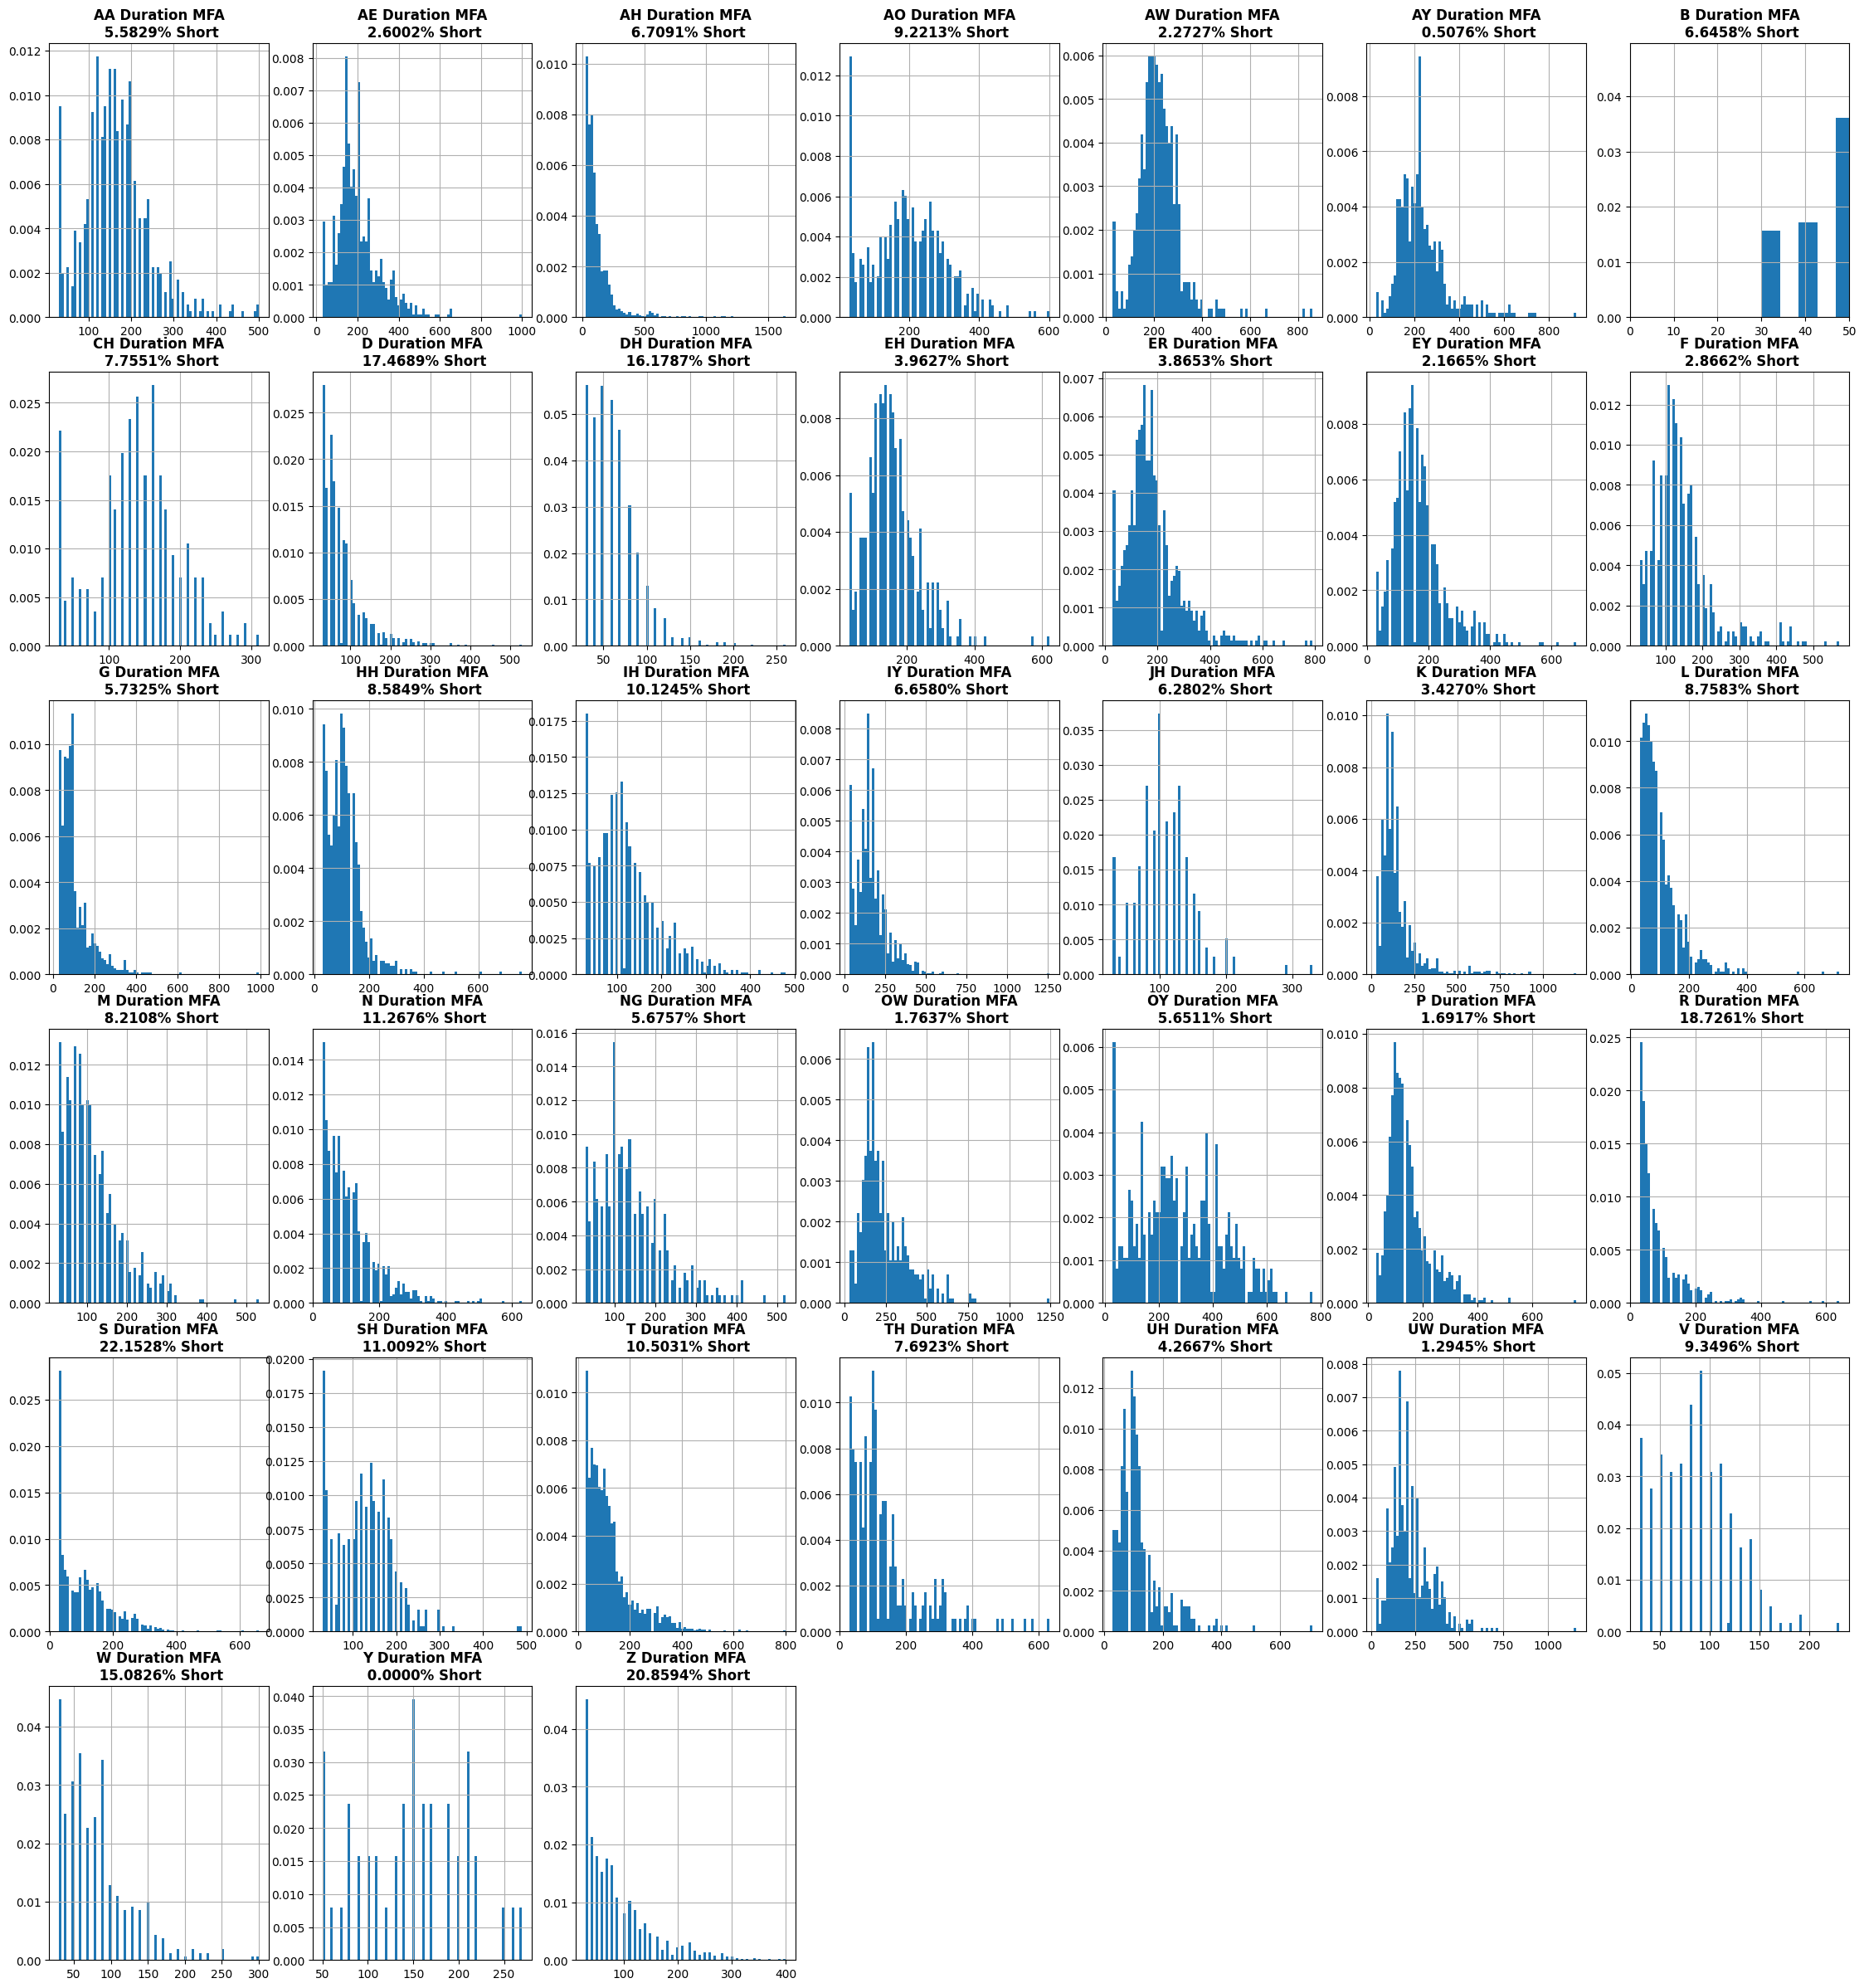

In [64]:
pct_short_mfa = []
plt.figure(figsize=(28, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    durations = phone_dfs[phone]['mfa']['duration_est_mfa'].values
    durations = durations[~np.isnan(durations)]
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(durations, bins=80, density=True)
    if phone=='B':
        plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(durations<=35))/sum(~np.isnan(durations))
    plt.title(f"{phone} Duration MFA\n {pct_short:.4f}% Short", fontweight='bold')
    pct_short_mfa.append(pct_short)
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

0.1684981684981685
0.663003663003663


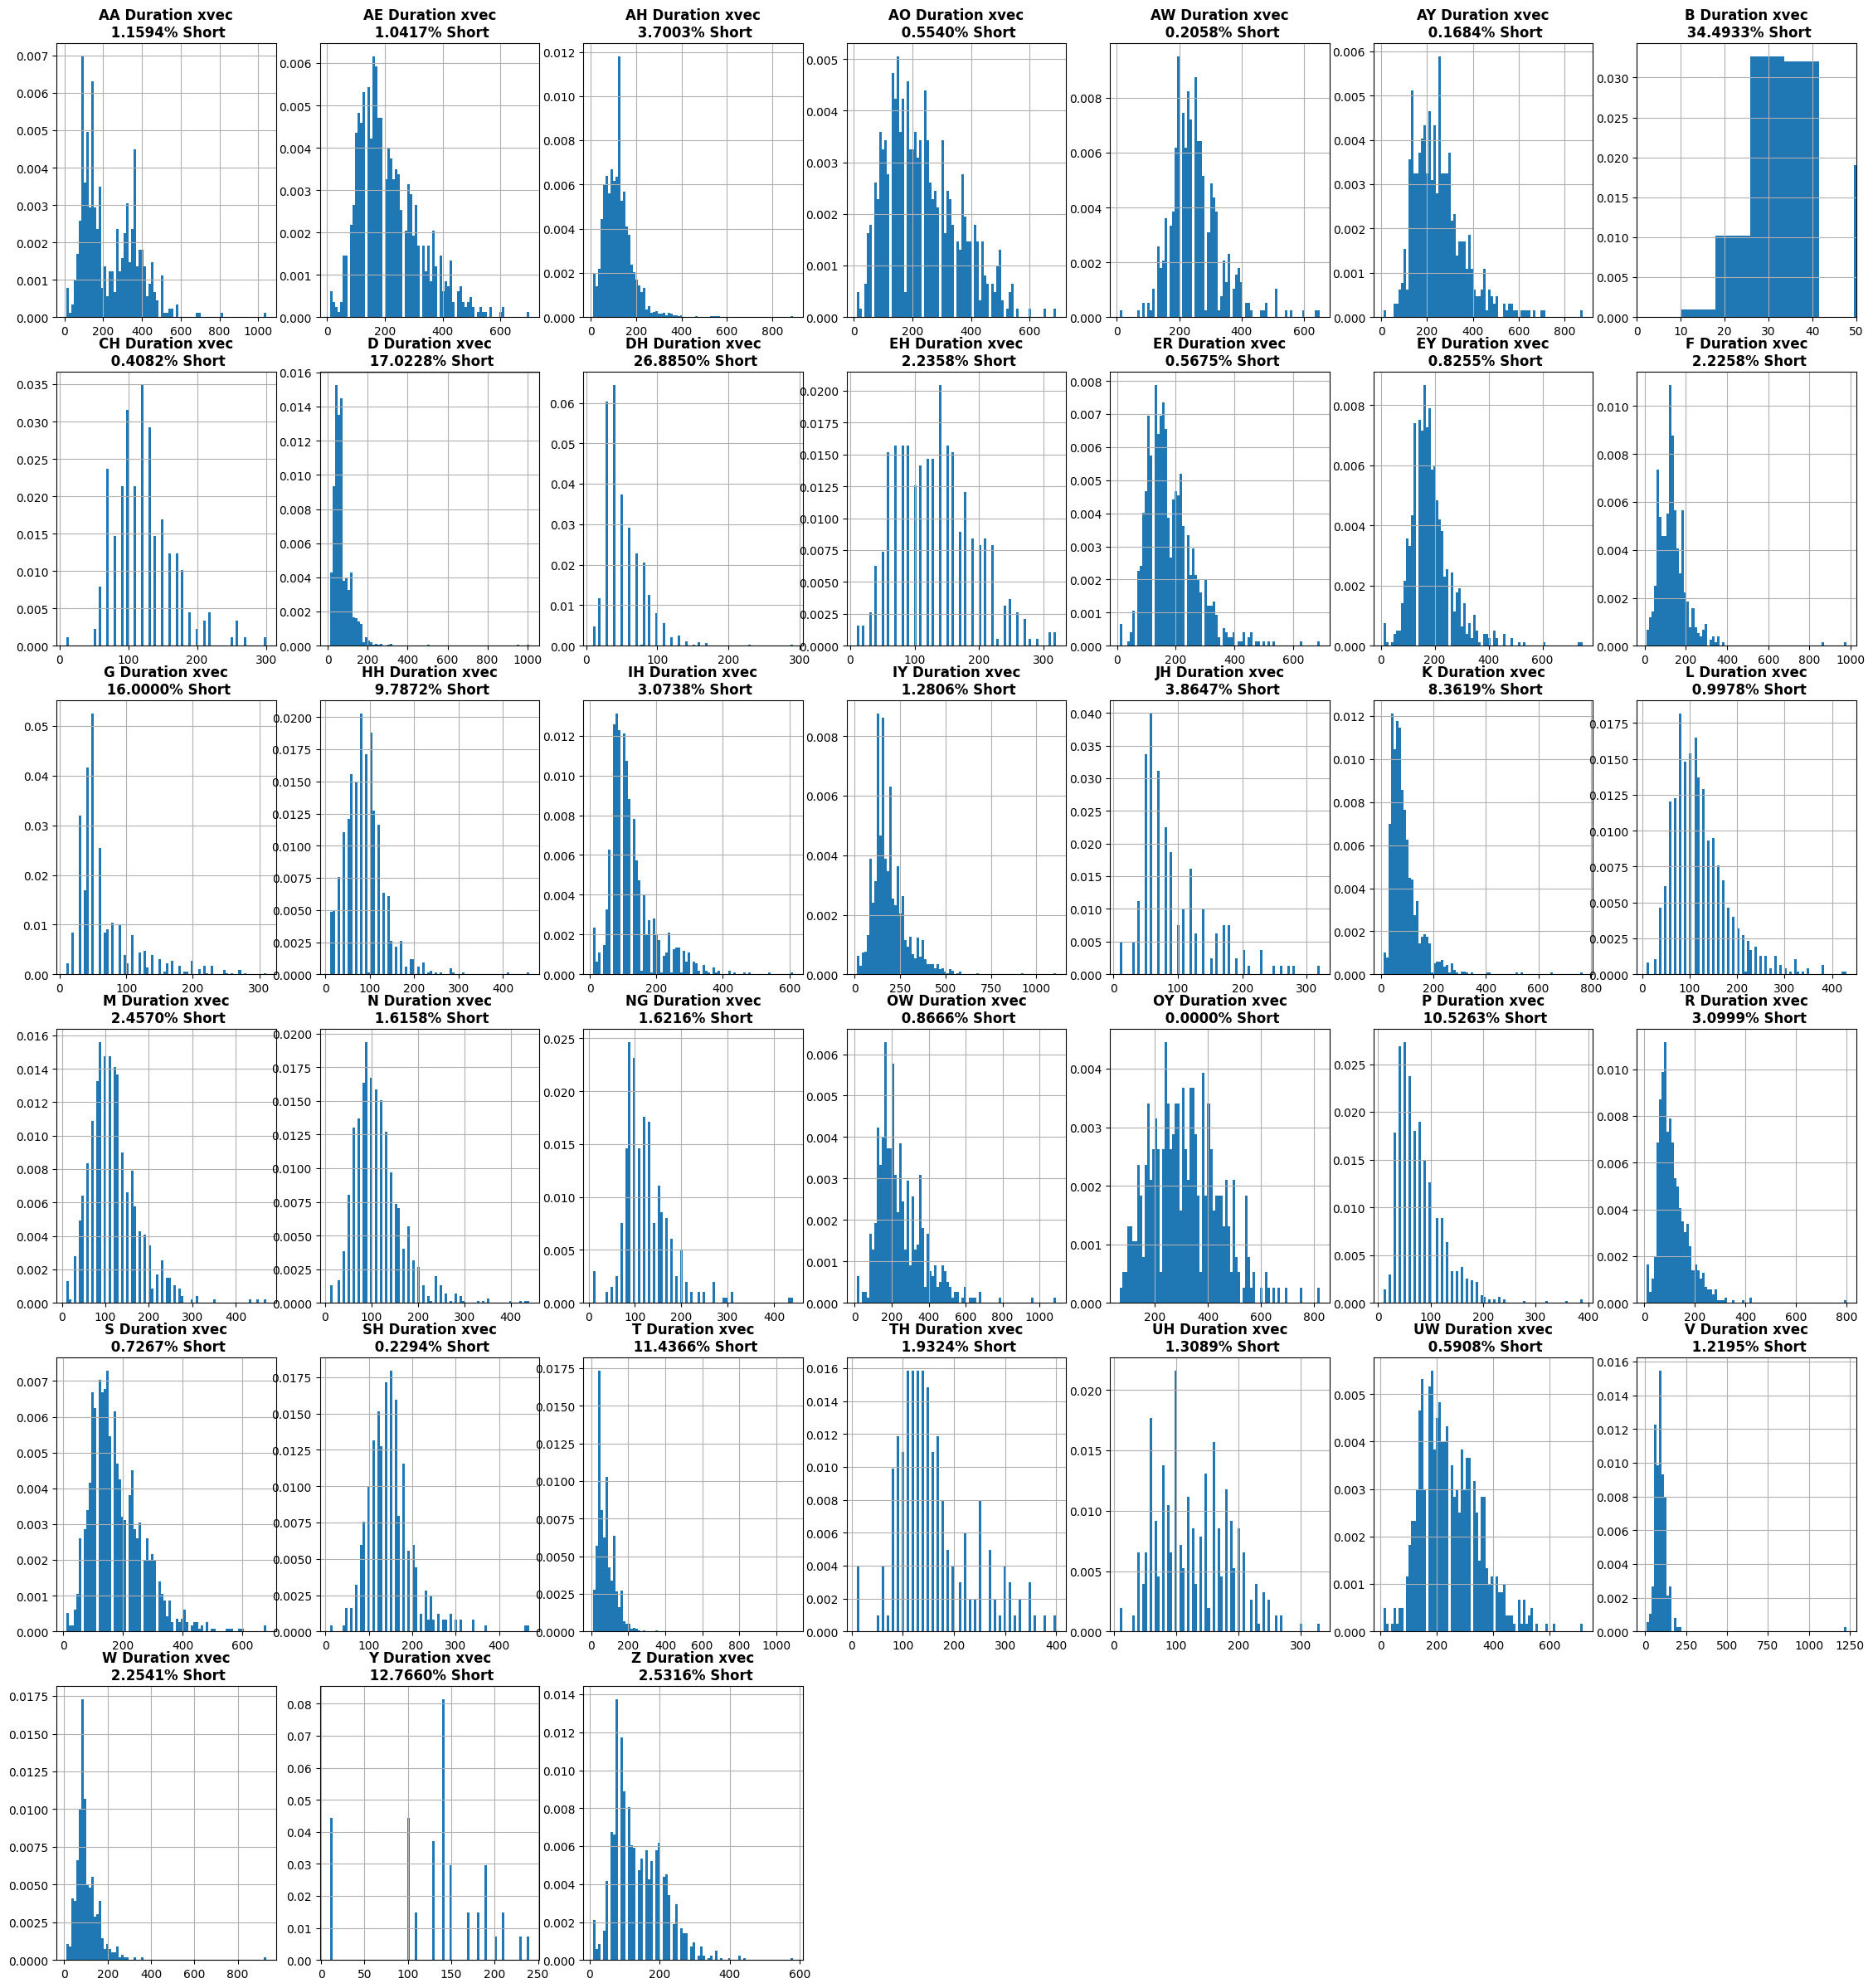

In [65]:
pct_short_xvec = []
plt.figure(figsize=(28, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    durations = phone_dfs[phone]['xvector']['duration_est_xvector'].values
    durations = durations[~np.isnan(durations)]
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(durations, bins=80, density=True)
    if phone=='B':
        print(sum(durations<30)/len(durations))
        print(sum(durations<50)/len(durations))
        plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(durations<=35))/sum(~np.isnan(durations))
    plt.title(f"{phone} Duration xvec\n {pct_short:.4f}% Short", fontweight='bold')
    pct_short_xvec.append(pct_short)
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [374]:
import math
def calc_alignment_cost(ref, test, silence_phone='sil', return_all_metrics=False):
    score_func = functools.partial(overlap_scoring)
    ref_len = len(ref)
    alignment = pairwise2.align.globalcs(ref, test, score_func, GAP_START_SCORE, GAP_CONTINUE_SCORE, gap_char=['-'], one_alignment_only=True)
    overlap_count = 0
    overlap_cost = 0
    num_insertions = 0
    num_deletions = 0
    num_substitutions = 0
    num_matched = 0
    matched_overlap_cost = 0
    for a in alignment:
        for i, sa in enumerate(a.seqA):
            sb = a.seqB[i]
            # print(sa, sb)
            if sa == '-':
                if not silence_check(sb):
                    num_insertions += 1
                else:
                    continue
            elif sb == '-':
                if not silence_check(sb):
                    num_deletions += 1
                else:
                    continue
            else:
                item_cost = abs(sa[0] - sb[0]) + abs(sa[1] - sb[1])
                overlap_cost += item_cost
                overlap_count += 1

                if compare_labels(sa[2], sb[2], silence_phone) > 0:
                    num_substitutions += 1
                elif compare_labels(sa[2], sb[2], silence_phone)==0:
                    matched_overlap_cost += item_cost
                    num_matched += 1

        overlap_cost = -overlap_cost
        alignment_score = overlap_cost/2
        phone_error_rate = (num_insertions + num_deletions + 2 * num_substitutions)/ref_len
        matched_alignment_score = math.nan if num_matched==0 else matched_overlap_cost/num_matched
        rslts = {'OverlapCost': overlap_cost, 'MatchedOverlapCost': matched_overlap_cost,
                 'AlignmentScore': alignment_score, 'MatchedAlignmentScore': matched_alignment_score,
                 'NumInsertions': num_insertions, 'NumDeletions': num_deletions, 'NumSubstitutions': num_substitutions,
                 'PhoneErrorRate': phone_error_rate}
        return rslts

In [381]:
metricdf = pd.DataFrame(per_file_rslts)

In [387]:
np.mean(metricdf.AlignmentScore)

-0.4474160210805418

In [12]:
def add_before_after_silence(tgdf, manualdf):
    if tgdf.start.iloc[0]>0:
        silence_row_df = pd.DataFrame({'start':tgdf.end.iloc[-1], 'end': manualdf.end.iloc[-1], 'phone': 'sil'}, index=[0])
        tgdf = pd.concat([silence_row_df, tgdf]).reset_index(drop=True)
    
    if tgdf.end.iloc[-1]<manualdf.end.iloc[-1] and tgdf.phone.iloc[-1]!='sil':
        silence_row_df = pd.DataFrame({'start':tgdf.end.iloc[-1], 'end': manualdf.end.iloc[-1], 'phone': 'sil'}, index=[max(tgdf.index)+1])
        tgdf = pd.concat([tgdf, silence_row_df]).reset_index(drop=True)
    return tgdf

In [13]:
''' for calculating alignment statistics '''
alltgs = {'manual':allmanual_tgs , 'xvector_tgs':xvector_tgs, 'mfa_tgs':mfa_tgs}


def evaluate_aligner_metrics(ground_truth_textgrids, estimated_textgrids, FILTER_SILENCE = True):
    # params: ground_truth_textgrids, estimated_textgrids
    per_file_rslts = []
    for gt_tgpth, est_tgpth in tqdm.tqdm(zip(ground_truth_textgrids, estimated_textgrids)):
        transcript = get_transcript_from_tgfile(gt_tgpth)
        _gttg = textgridpath_to_phonedf(gt_tgpth, phone_key='ha phones', remove_numbers=True)

        _esttg = textgridpath_to_phonedf(est_tgpth, phone_key='phones', remove_numbers=True)    

        _esttg = add_before_after_silence(_esttg, _gttg)

        if FILTER_SILENCE:
            _esttg = process_silences(_esttg, transcript)
        _gt = get_df_rows_as_tuples(_gttg)
        _est = get_df_rows_as_tuples(_esttg)
        _rslts = calc_alignment_cost(_gt, _est)
        per_file_rslts.append(_rslts)
    return pd.DataFrame(per_file_rslts)

In [14]:
allmanual_tgs[1]

'/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/0407_M_SJ/0407_M_SJs2T05.TextGrid'

In [20]:
allmanual_tgs[0].split('/')[-2]

'0407_M_SJ'

In [15]:
metricdf_xvec = evaluate_aligner_metrics(allmanual_tgs, xvector_tgs)
metricdf_ivec = evaluate_aligner_metrics(allmanual_tgs, ivector_tgs)
metricdf_mfa = evaluate_aligner_metrics(allmanual_tgs, mfa_tgs)


3762it [00:14, 253.08it/s]
3762it [00:18, 203.80it/s]
3762it [00:23, 161.66it/s]


In [480]:
f'{np.mean(np.random.randn(1000)):.2f}'

'0.04'

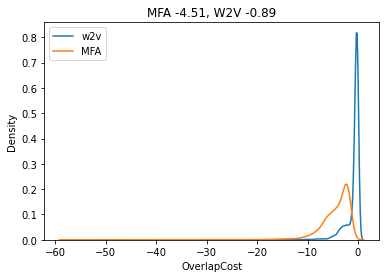

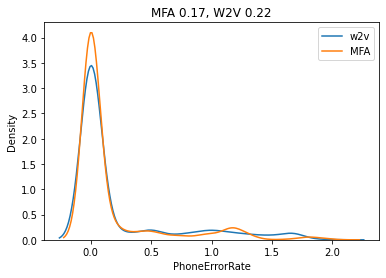

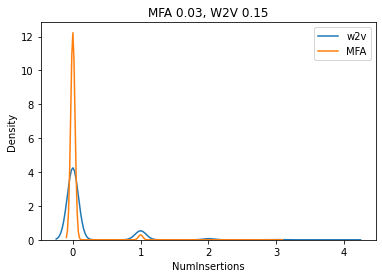

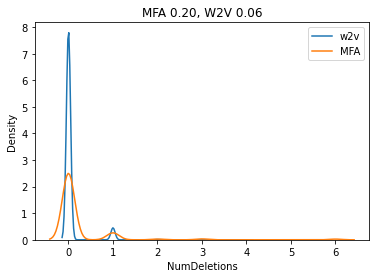

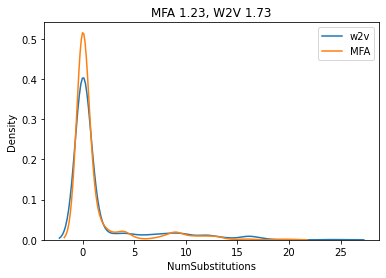

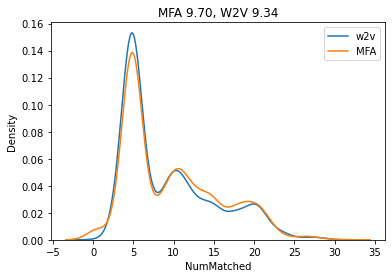

In [487]:
plt.figure()
sns.kdeplot(data=metricdf_xvec, x='OverlapCost', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='OverlapCost', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['OverlapCost']):.2f}, W2V {np.mean(metricdf_xvec['OverlapCost']):.2f}")
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='PhoneErrorRate', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='PhoneErrorRate', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['PhoneErrorRate']):.2f}, W2V {np.mean(metricdf_xvec['PhoneErrorRate']):.2f}")
plt.legend()


plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumInsertions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumInsertions', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['NumInsertions']):.2f}, W2V {np.mean(metricdf_xvec['NumInsertions']):.2f}")
plt.legend()


plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumDeletions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumDeletions', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['NumDeletions']):.2f}, W2V {np.mean(metricdf_xvec['NumDeletions']):.2f}")
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumSubstitutions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumSubstitutions', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['NumSubstitutions']):.2f}, W2V {np.mean(metricdf_xvec['NumSubstitutions']):.2f}")
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumMatched', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumMatched', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['NumMatched']):.2f}, W2V {np.mean(metricdf_xvec['NumMatched']):.2f}")
plt.legend()


In [ ]:
plt.figure()
sns.kdeplot(data=metricdf_xvec, x='OverlapCost', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='OverlapCost', label='MFA')
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='PhoneErrorRate', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='PhoneErrorRate', label='MFA')
plt.legend()


plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumInsertions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumInsertions', label='MFA')
plt.legend()


plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumDeletions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumDeletions', label='MFA')
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumSubstitutions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumSubstitutions', label='MFA')
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumMatched', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumMatched', label='MFA')
plt.legend()


In [231]:
gt_dfs['AA']['Duration'] = gt_dfs['AA']['end_time'] - gt_dfs['AA']['start_time']

In [ ]:
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    plt.subplot(6, 7, ii+1)
    duration = gt_dfs[phone]['end_time'] - gt_dfs[phone]['start_time']
    plt.hist(duration, bins=100, density=True)    
    plt.xlim([0, 10])
    plt.grid()
    plt.title('%s Duration GT' % phone, fontweight='bold')
plt.savefig('./saved_figures/phone_durations_manual.png')

In [ ]:
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['duration_est_xvector'].values, bins=100)
    plt.xlim([0, 10])
    plt.grid()
    plt.title('%s Duration xVec' % phone, fontweight='bold')
plt.show()

----------------------------------------------------------------------------------------------------------------------
Durations


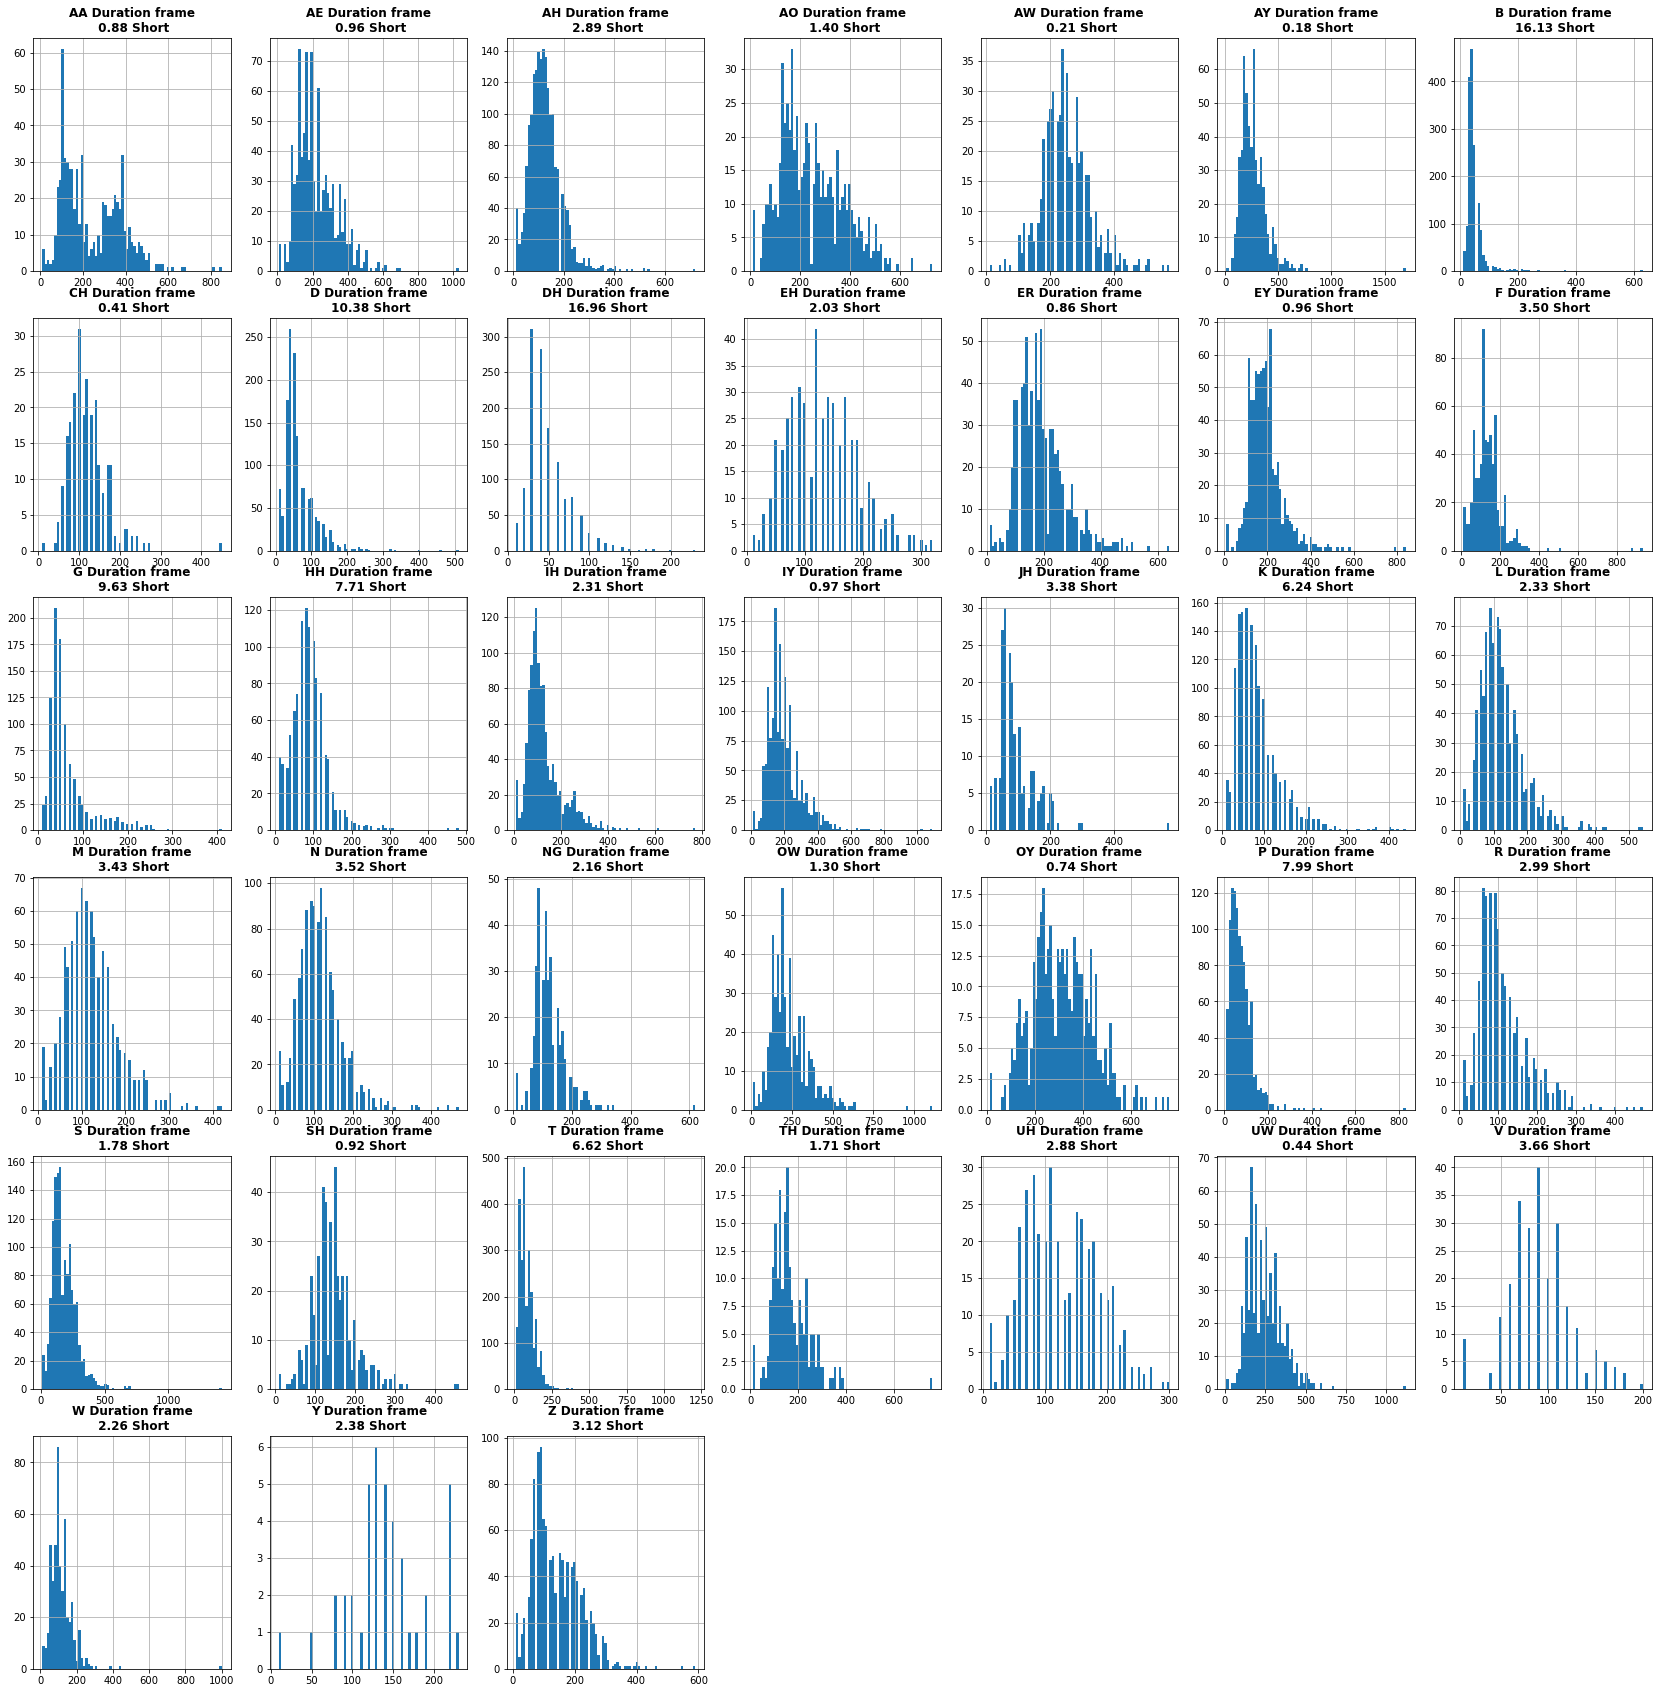

----------------------------------------------------------------------------------------------------------------------
Onset Error


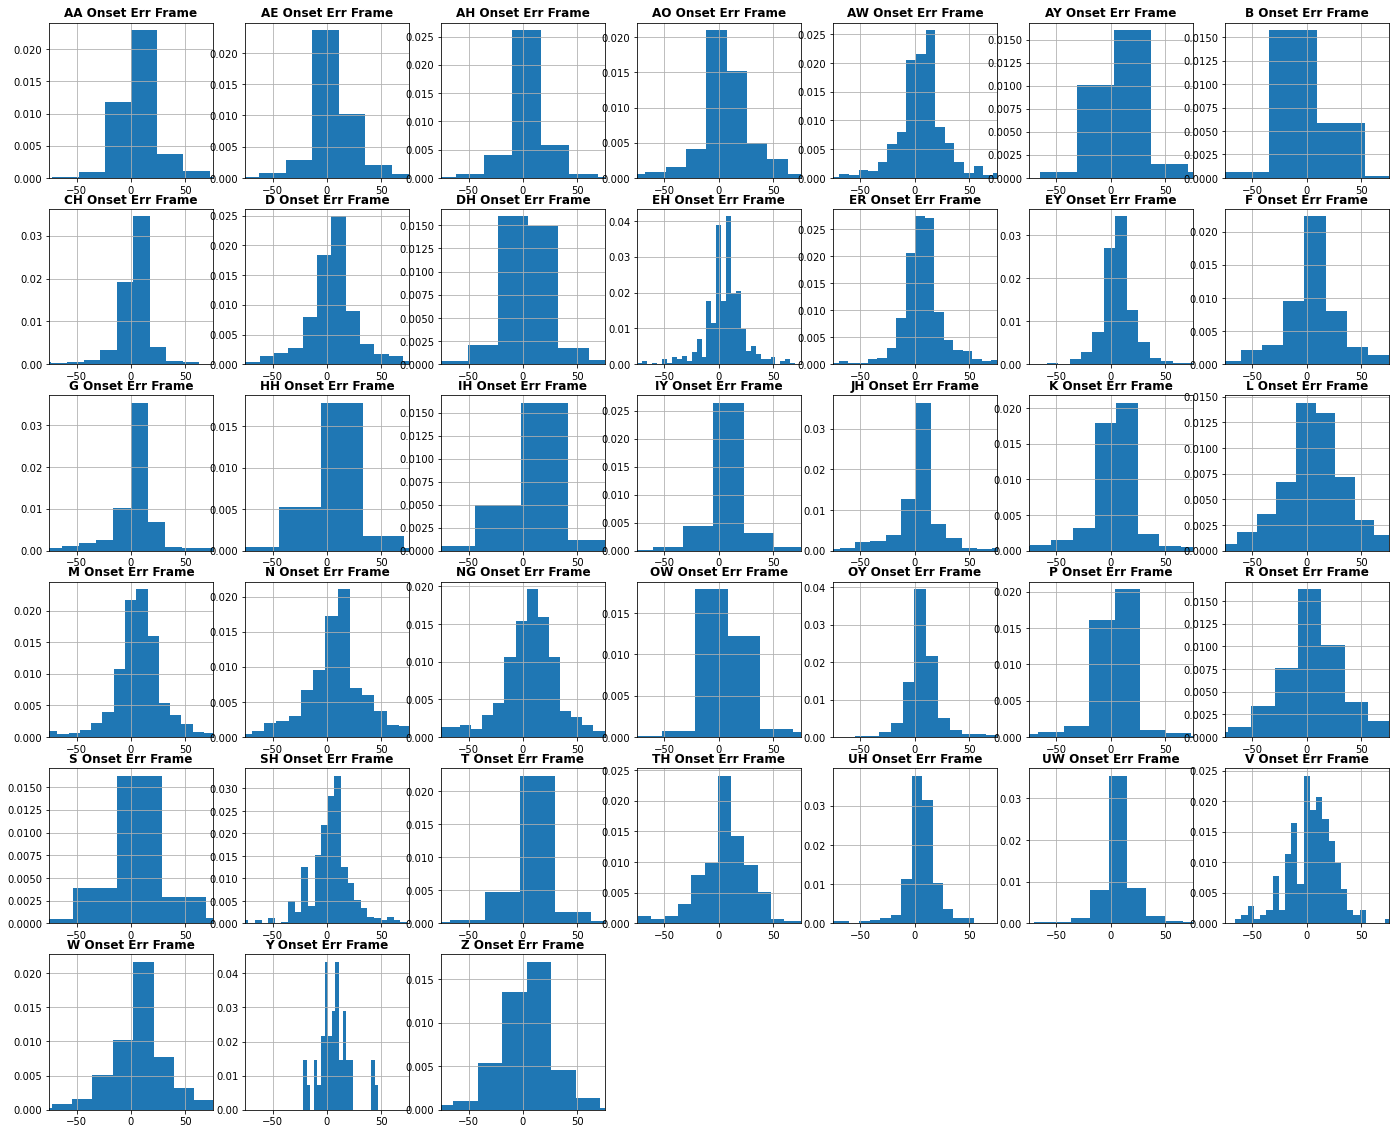

----------------------------------------------------------------------------------------------------------------------
Offset Error


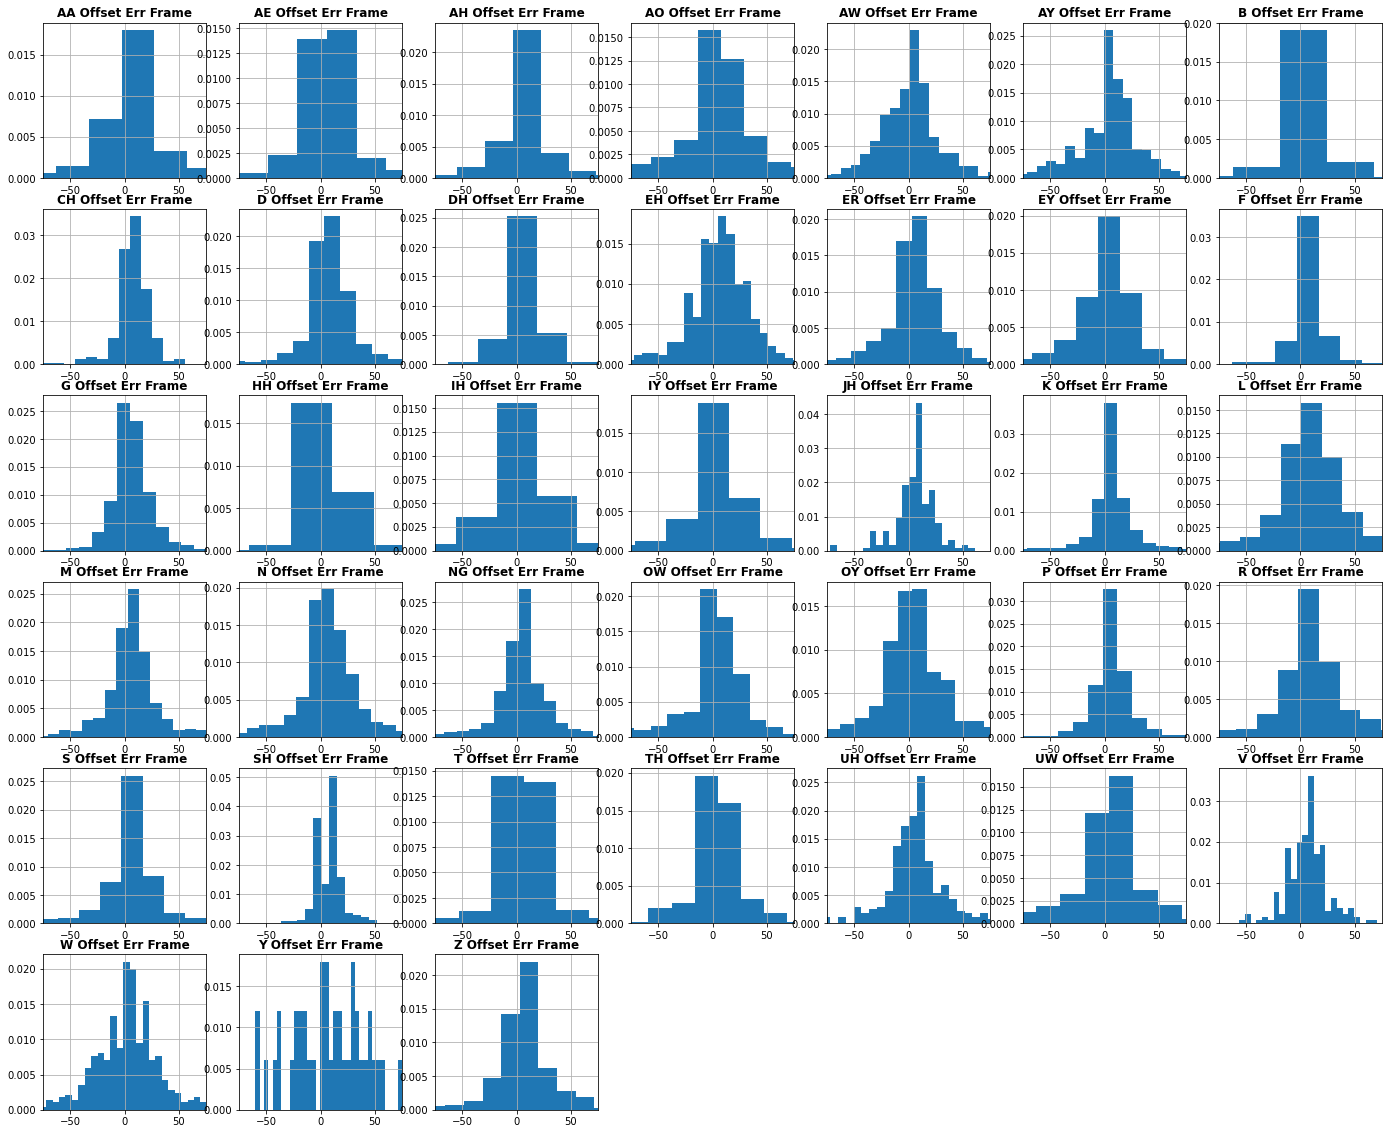

In [326]:
print('----------------------------------------------------------------------------------------------------------------------')
plt.figure(figsize=(29, 30))
print('Durations')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    durations = _df['duration_est'].values
    plt.hist(durations, bins=75)
    pct_short = 100*sum((durations<30))/len(durations)

    plt.grid()
    plt.title('%s Duration frame\n %.2f Short' % (phone, pct_short), fontweight='bold')
plt.savefig('./saved_figures/phone_durations_frame.png')
plt.show()

plt.figure(figsize=(24, 20))
print('----------------------------------------------------------------------------------------------------------------------')
print('Onset Error')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_frame'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err Frame' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_frame.png')
plt.show()

plt.figure(figsize=(24, 20))
print('----------------------------------------------------------------------------------------------------------------------')
print('Offset Error')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_frame'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err Frame' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_frame.png')
plt.show()


----------------------------------------------------------------------------------------------------------------------
Duration


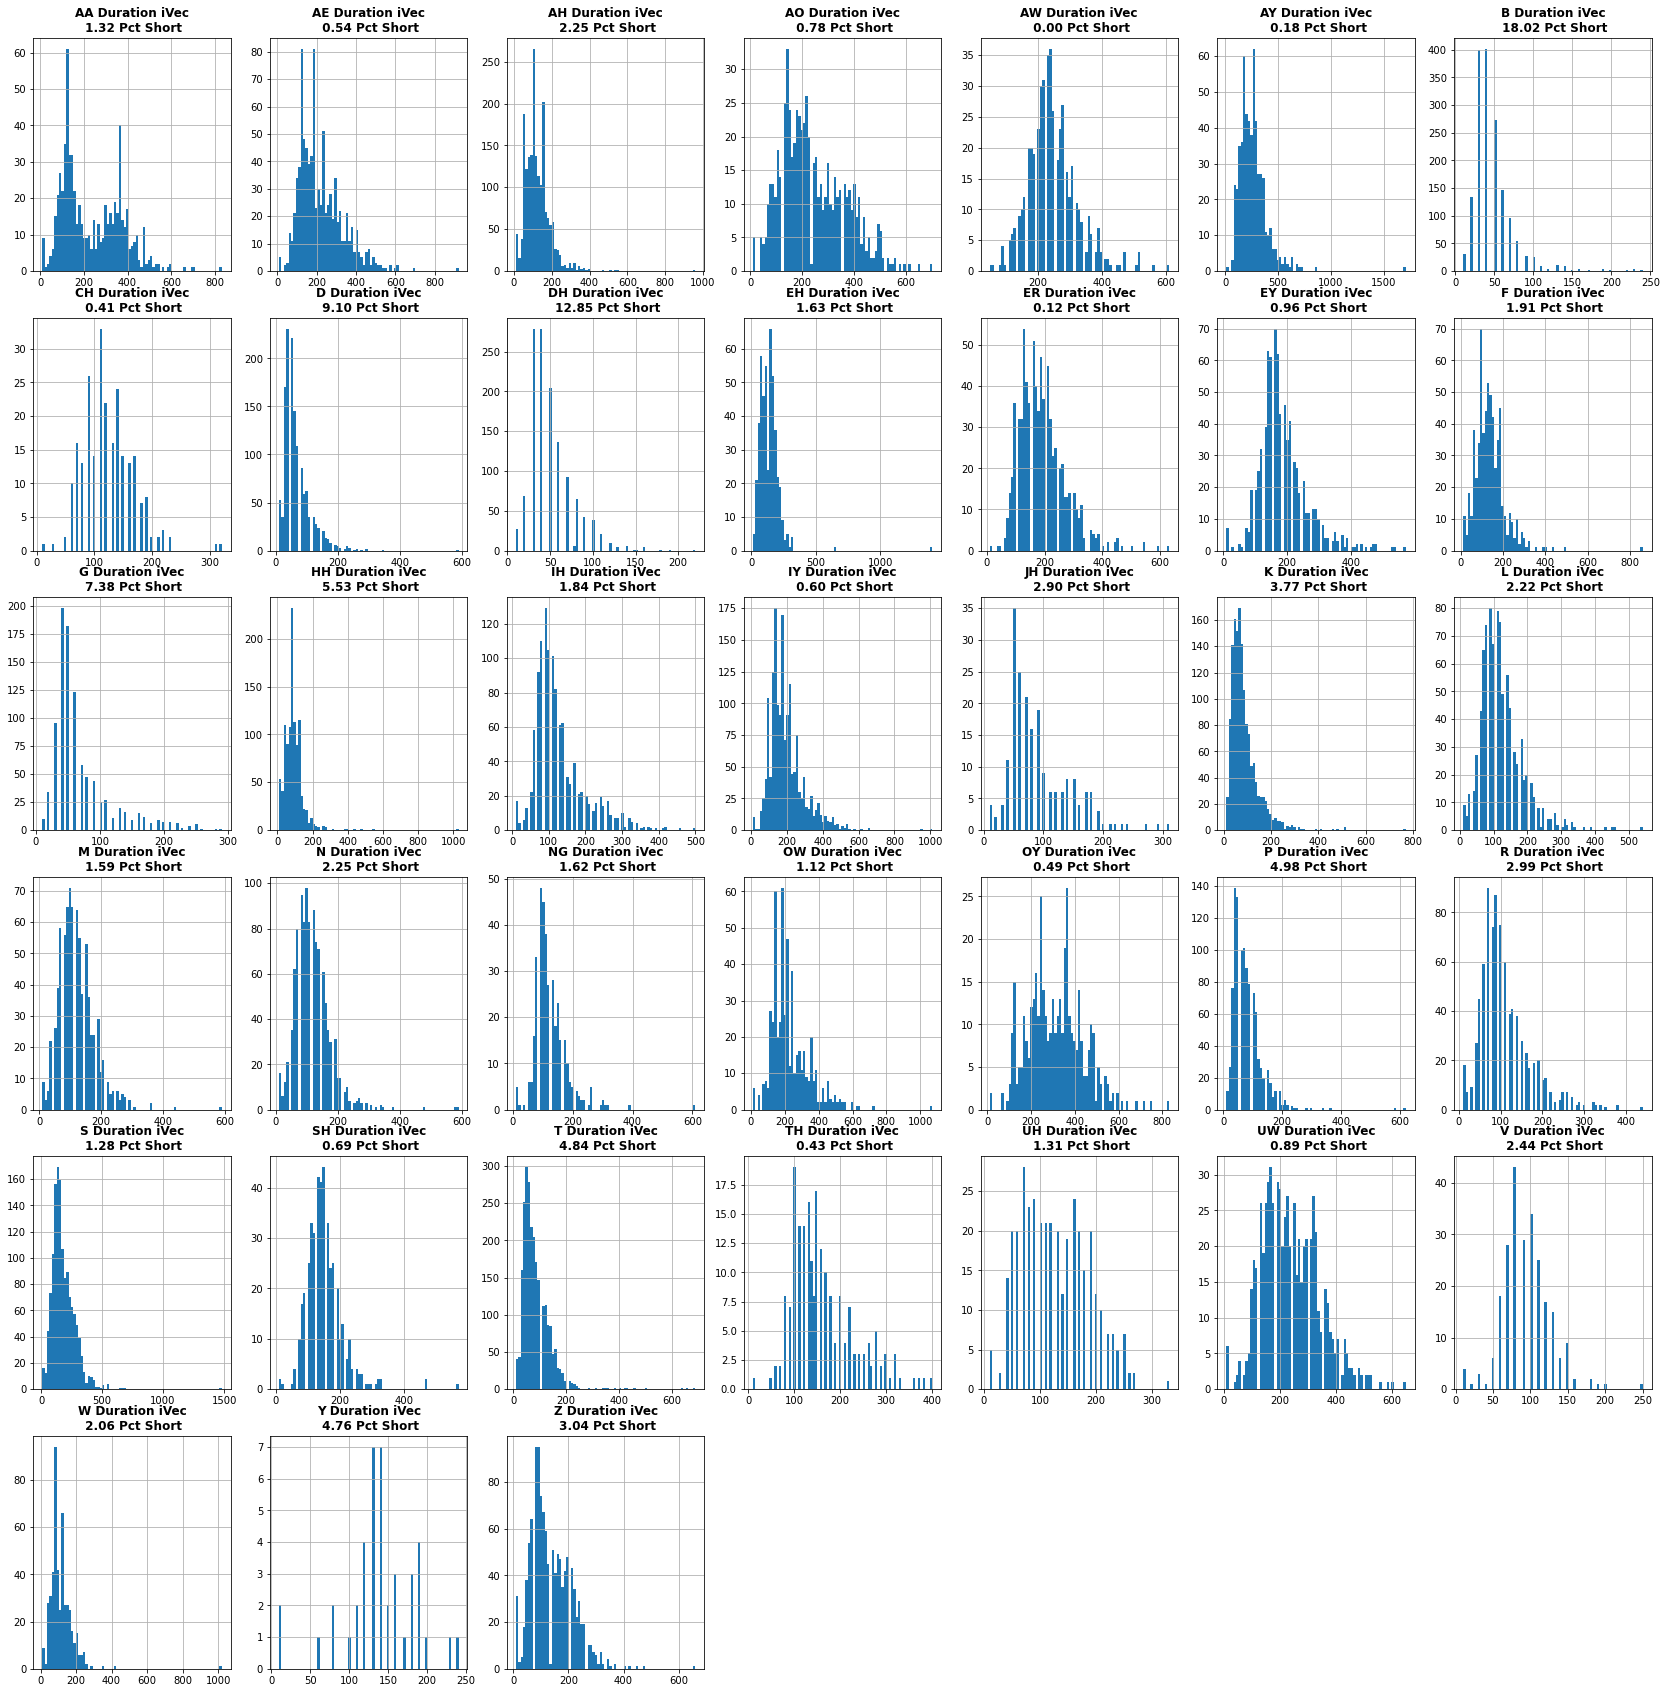

----------------------------------------------------------------------------------------------------------------------
Onset Error


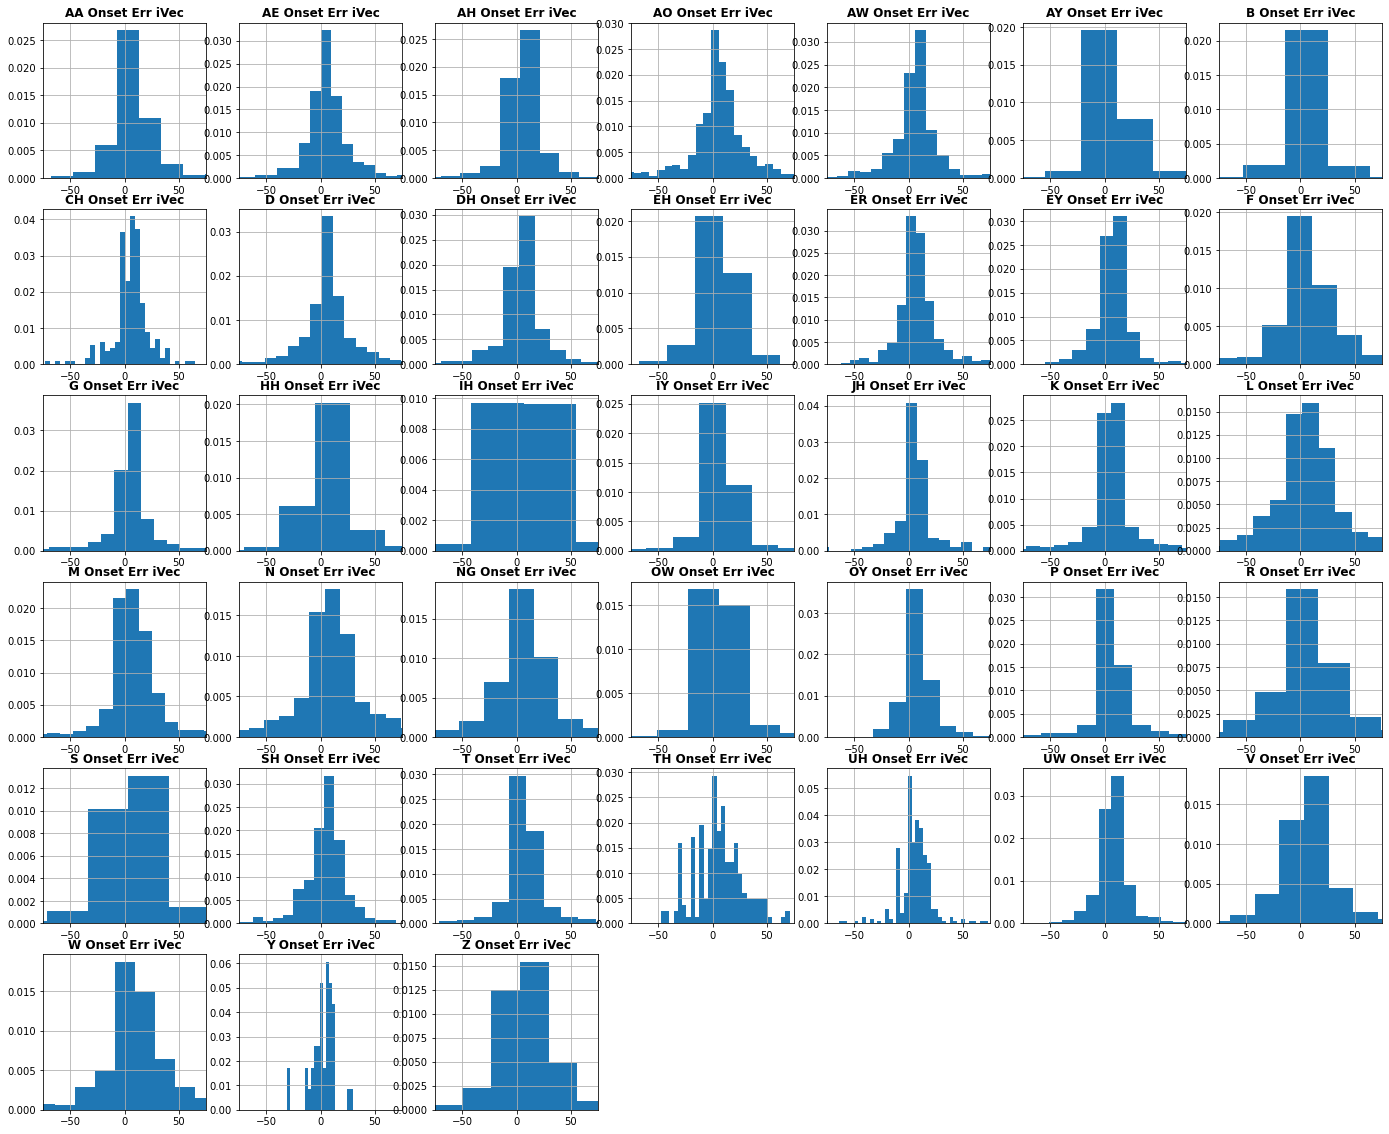

----------------------------------------------------------------------------------------------------------------------
Offset Error


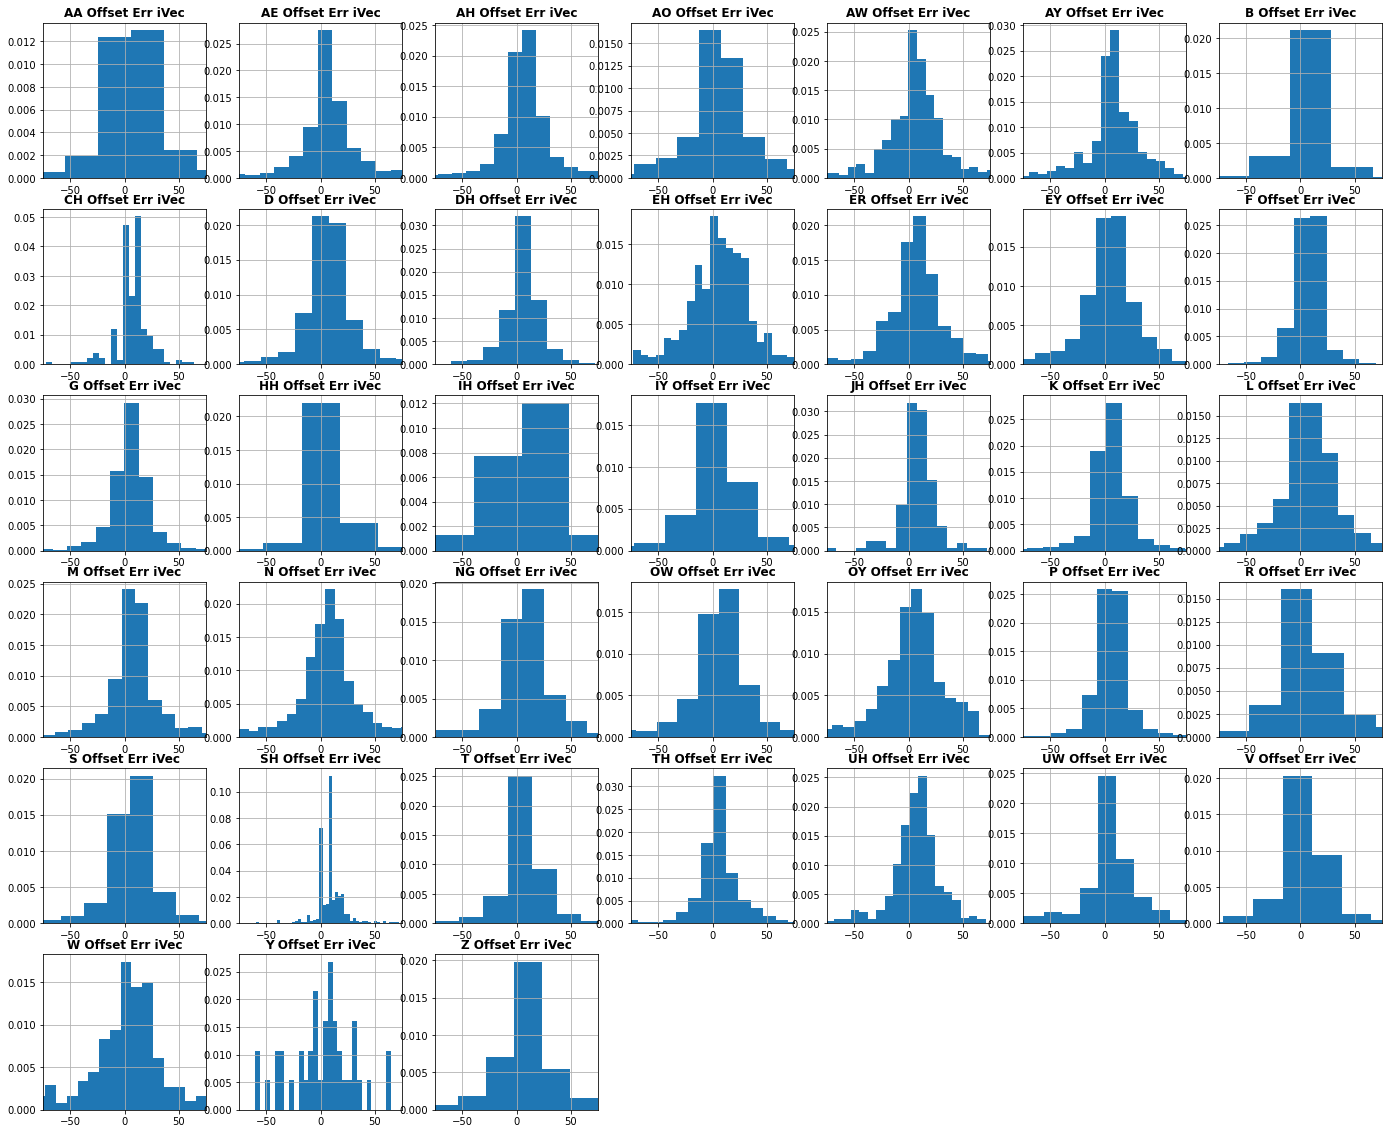

In [325]:
print('----------------------------------------------------------------------------------------------------------------------')
print('Duration')
plt.figure(figsize=(29, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    durations = _df['duration_est_ivector'].values
    plt.hist(durations, bins=75)
    # plt.xlim([0, 80])
    pct_short = 100*sum((durations<30))/len(durations)

    plt.grid()
    plt.title('%s Duration iVec\n %.2f Pct Short' % (phone, pct_short), fontweight='bold')
plt.savefig('./saved_figures/phone_durations_ivec.png')
plt.show()
print('----------------------------------------------------------------------------------------------------------------------')
print('Onset Error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_ivector'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err iVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_ivec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Offset Error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_ivector'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err iVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_ivec.png')
plt.show()


----------------------------------------------------------------------------------------------------------------------
duration


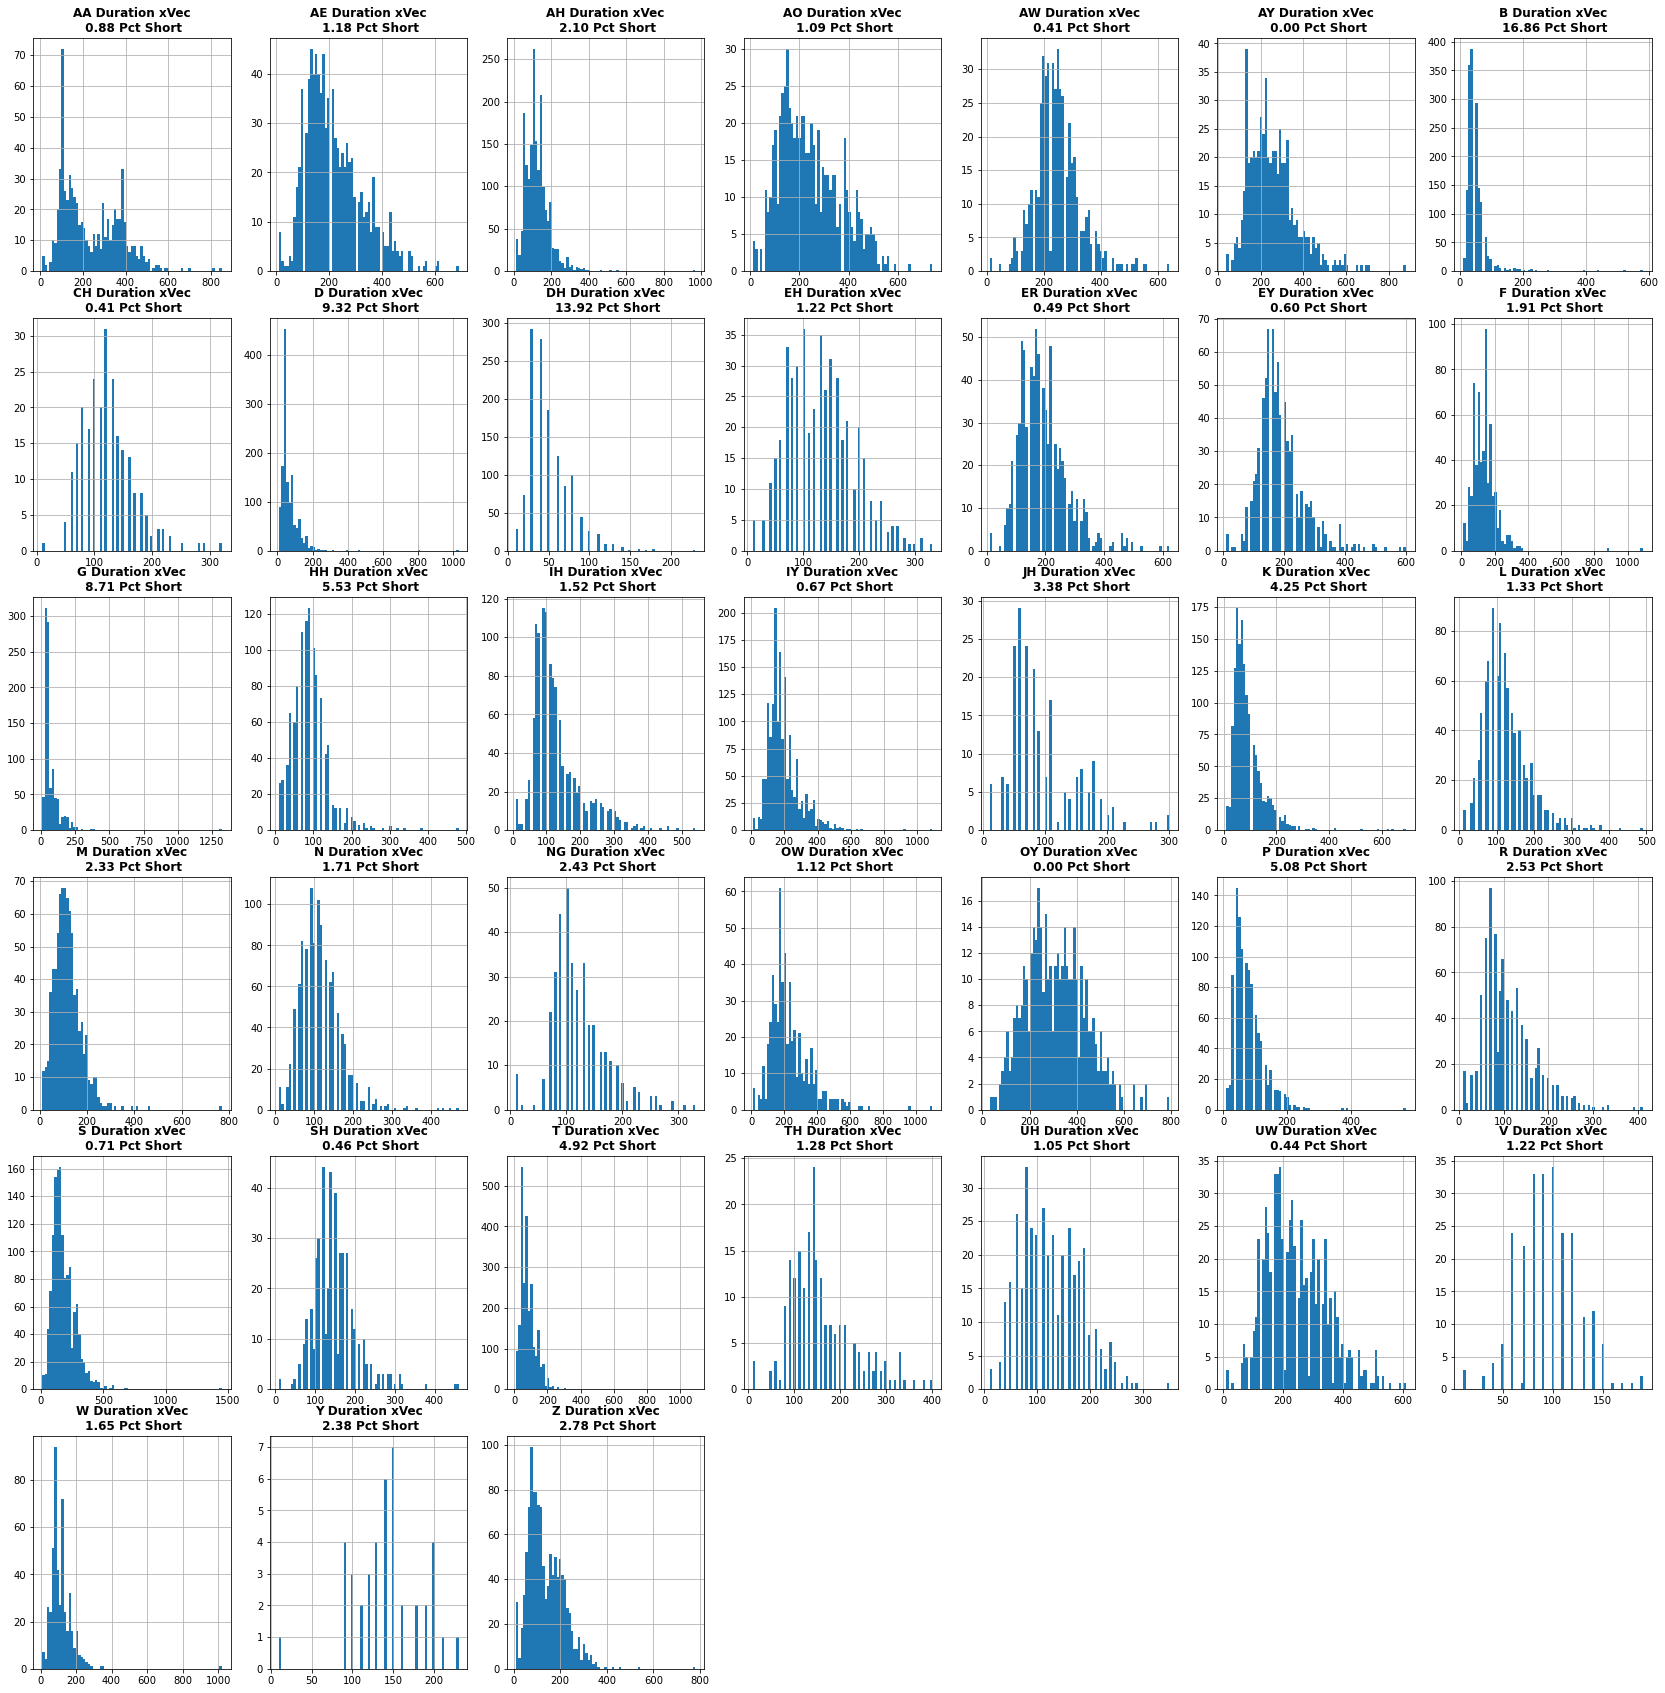

----------------------------------------------------------------------------------------------------------------------
Onset error


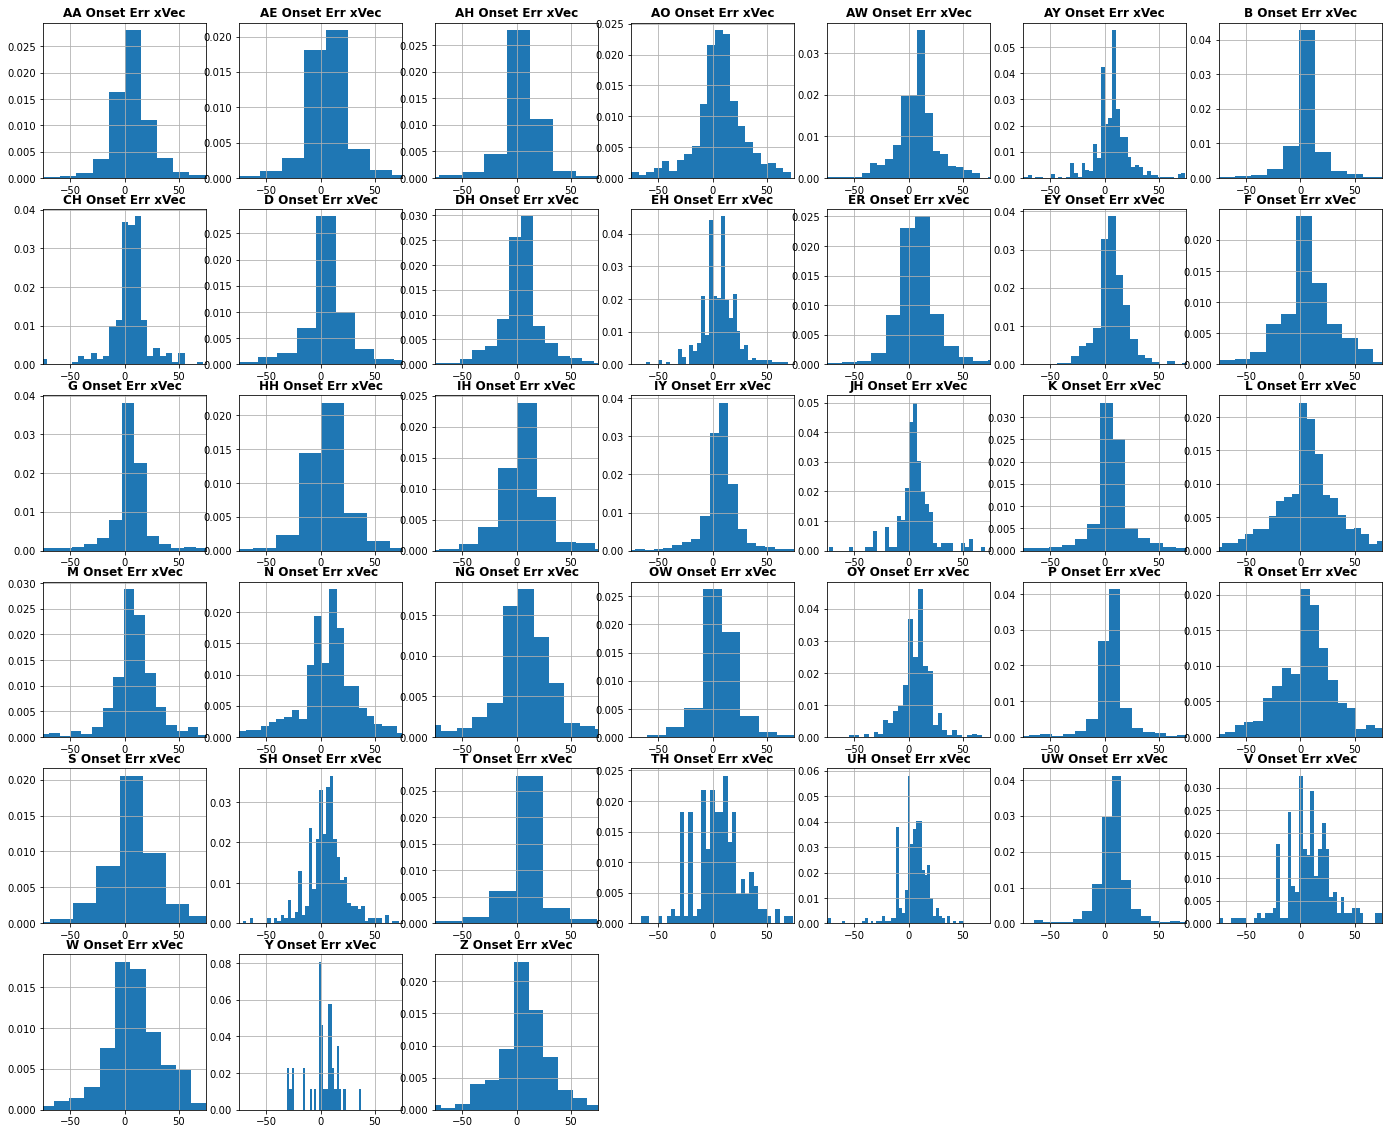

----------------------------------------------------------------------------------------------------------------------
Offset error


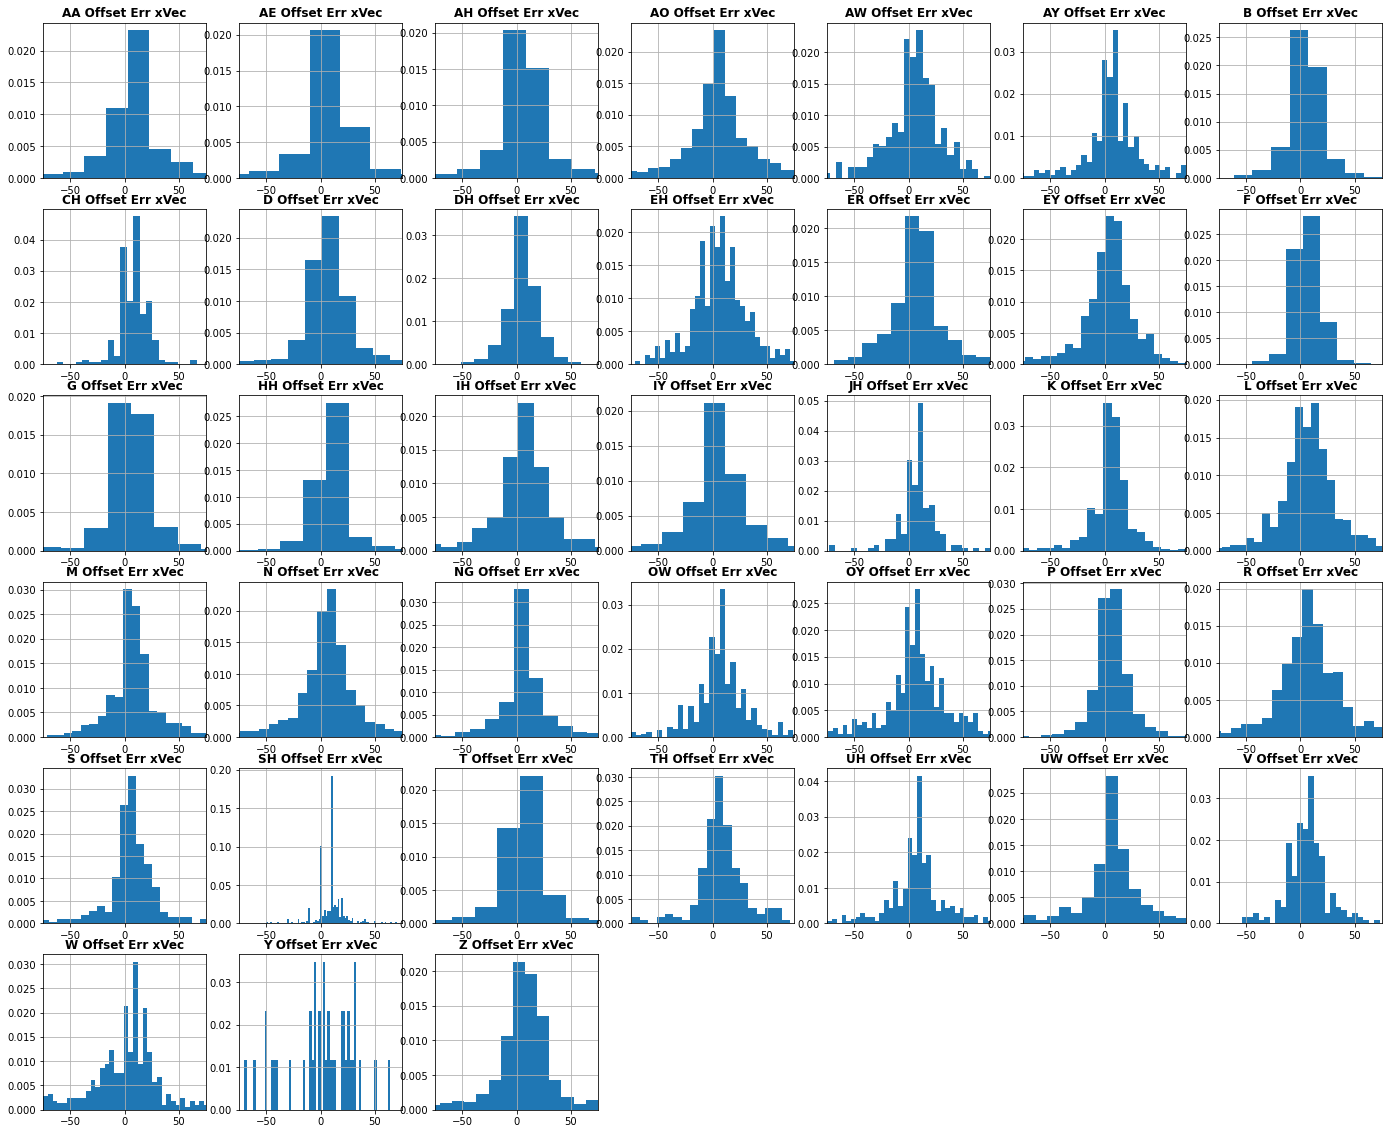

In [324]:
print('----------------------------------------------------------------------------------------------------------------------')
print('duration')
plt.figure(figsize=(29, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    durations = _df['duration_est_xvector'].values
    plt.hist(durations, bins=75)
    # plt.xlim([0, 80])
    pct_short = 100*sum((durations<30))/len(durations)

    plt.grid()
    plt.title('%s Duration xVec\n %.2f Pct Short' % (phone, pct_short), fontweight='bold')
plt.savefig('./saved_figures/phone_durations_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Onset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_xvector'].values, bins=75, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err xVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Offset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_xvector'].values, bins=75, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err xVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_xvec.png')
plt.show()

----------------------------------------------------------------------------------------------------------------------
duration


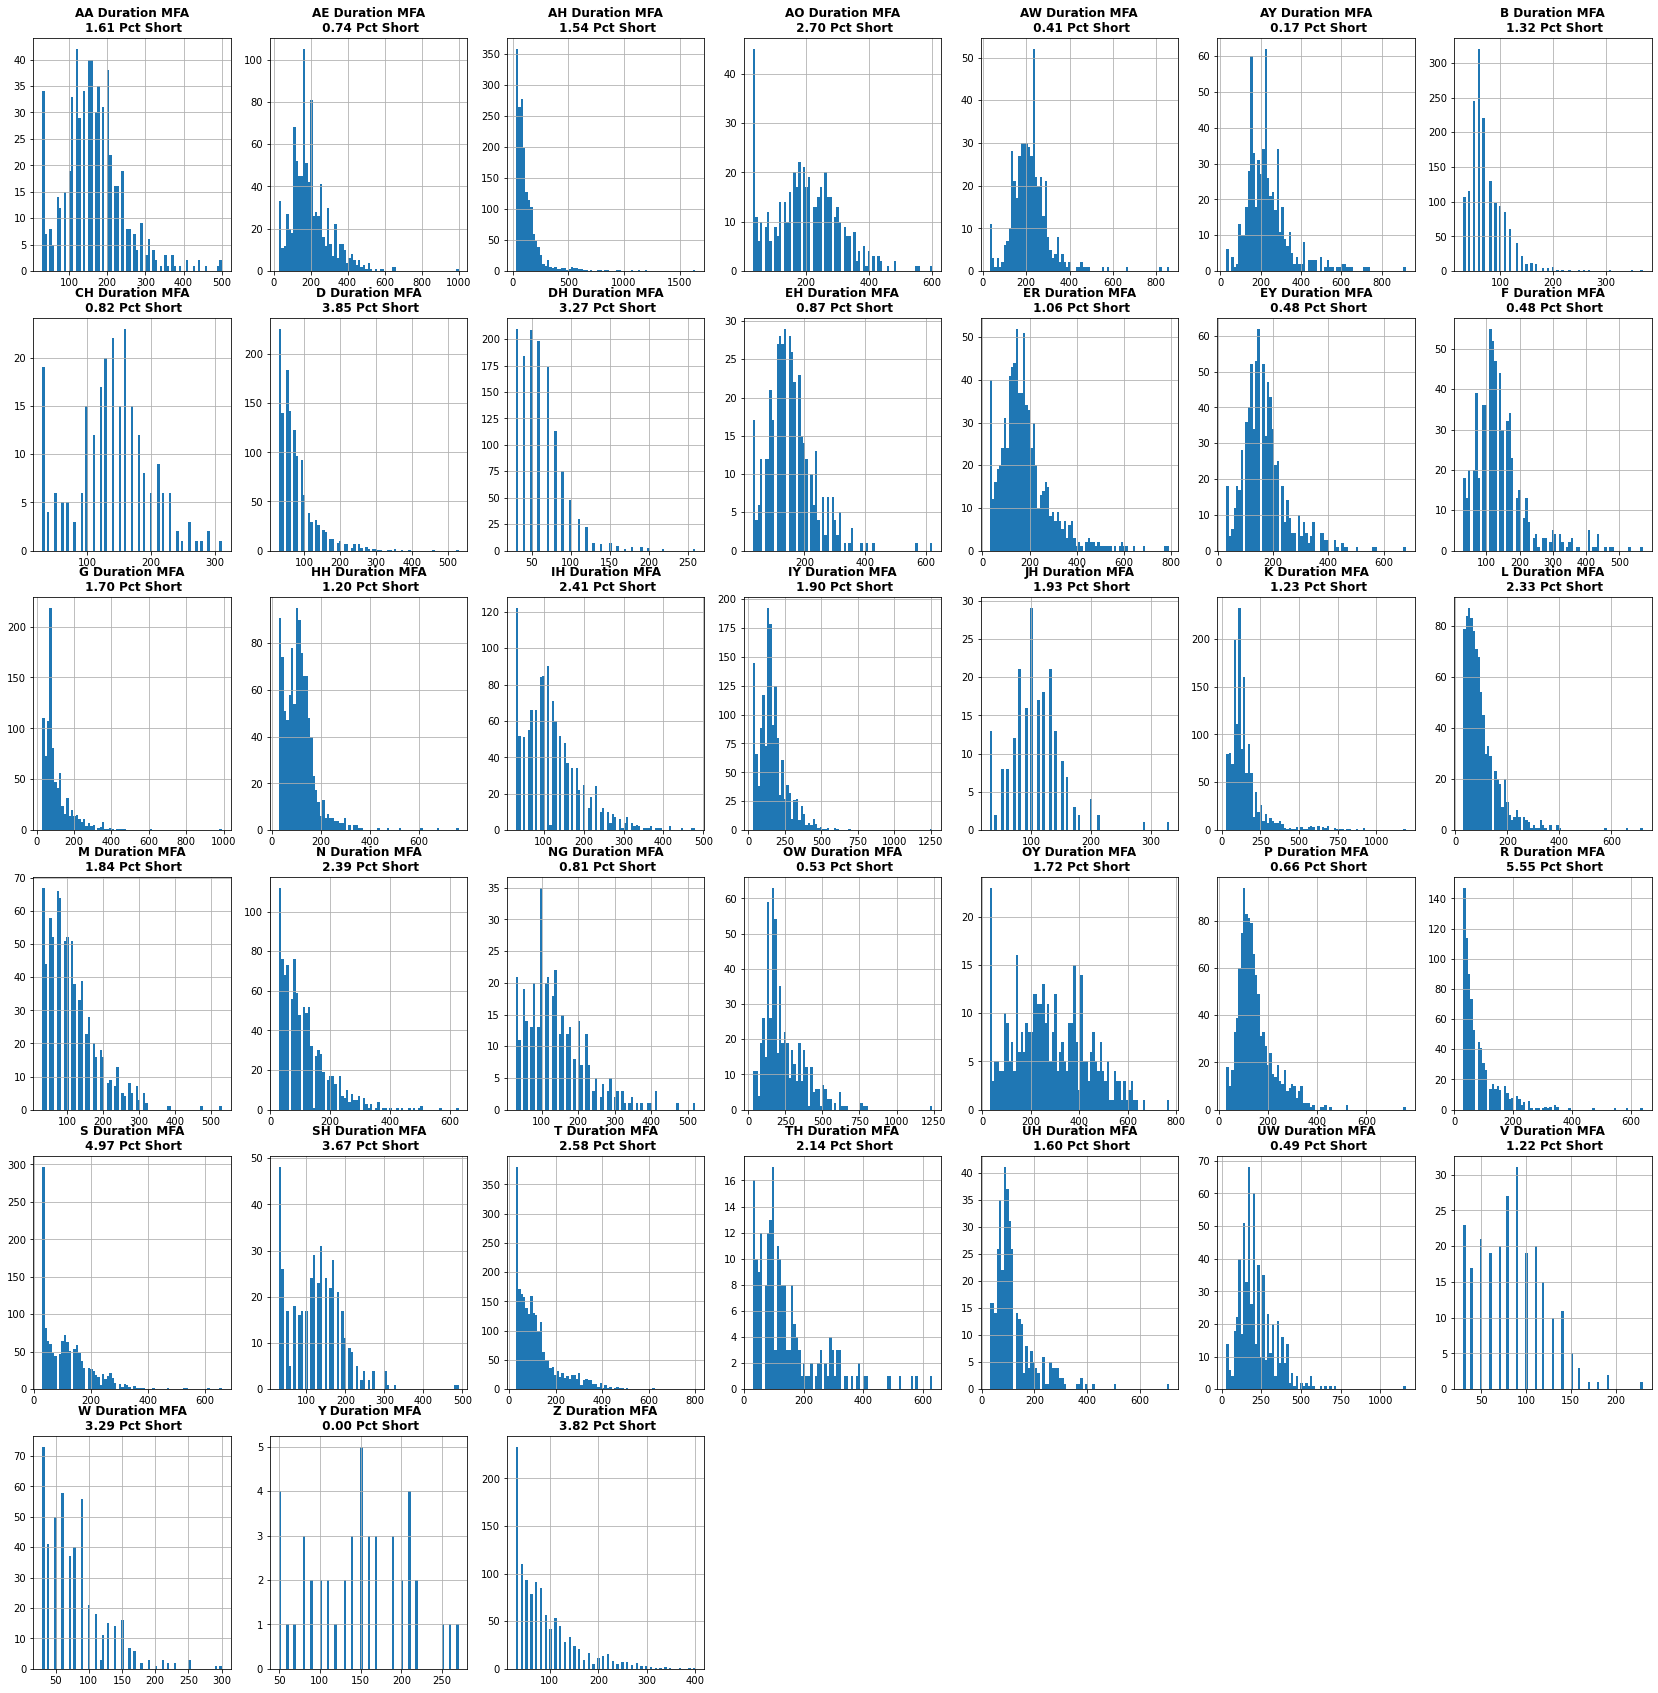

----------------------------------------------------------------------------------------------------------------------
Onset error


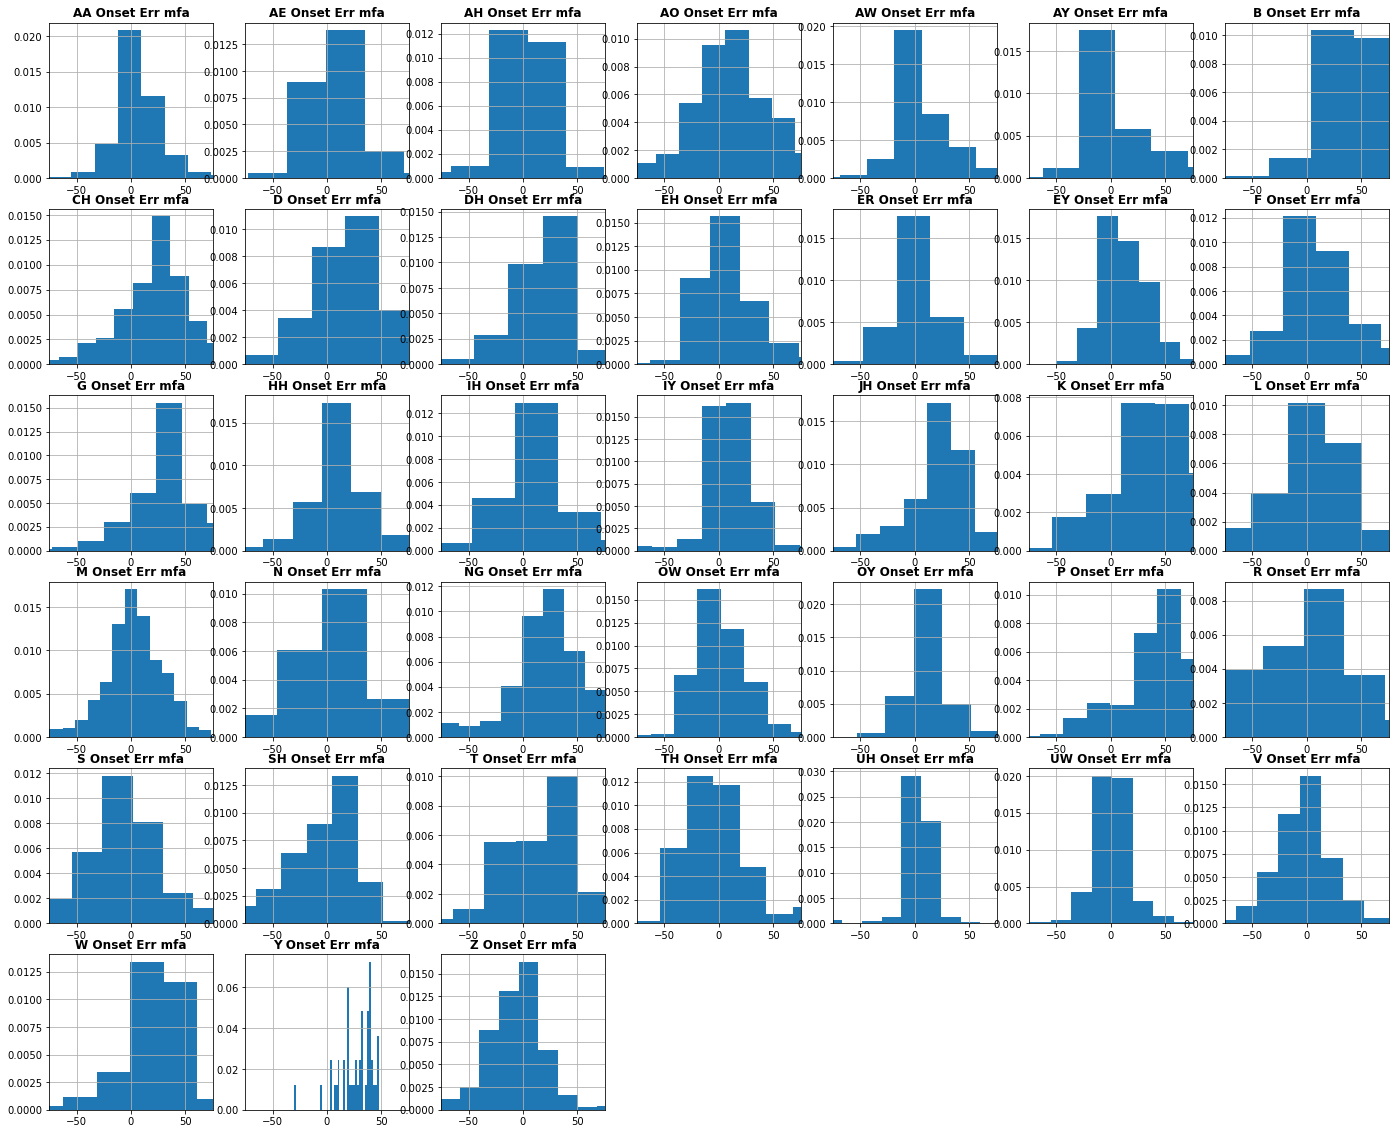

----------------------------------------------------------------------------------------------------------------------
Offset error


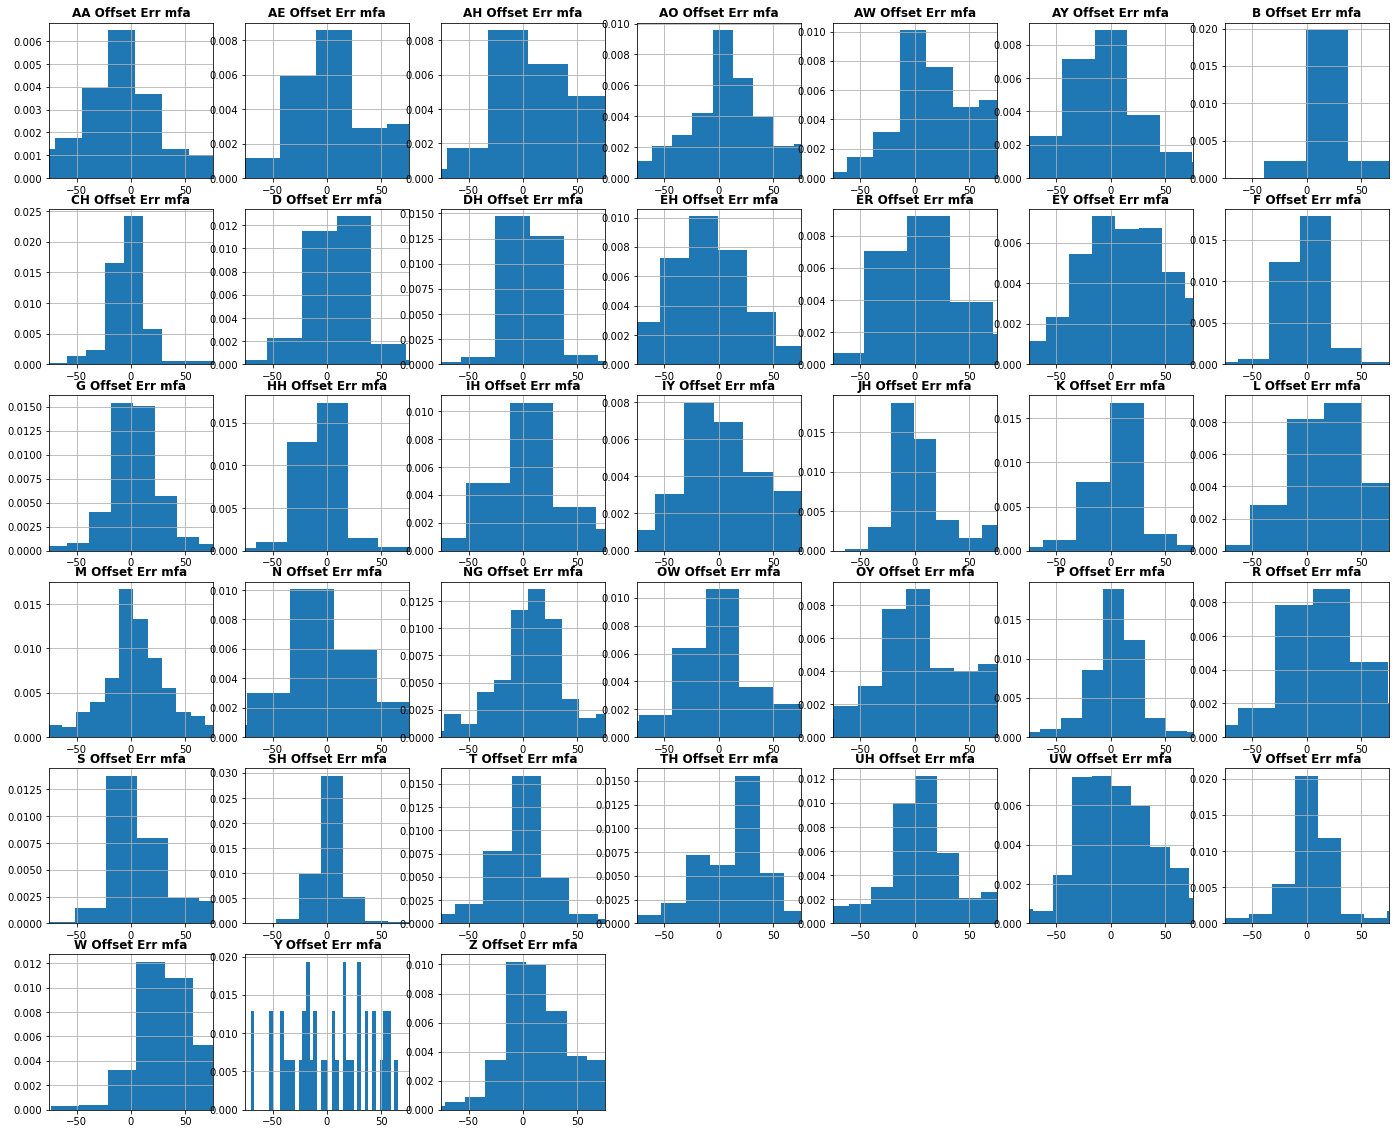

In [323]:
print('----------------------------------------------------------------------------------------------------------------------')
print('duration')
plt.figure(figsize=(29, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['mfa']
    plt.subplot(6, 7, ii+1)
    durations = _df['duration_est_mfa'].values
    plt.hist(durations, bins=75)
    # plt.xlim([0, 80])
    pct_short = 100*sum((durations<30))/len(durations)

    plt.grid()
    plt.title('%s Duration MFA\n %.2f Pct Short' % (phone, pct_short), fontweight='bold')
plt.savefig('./saved_figures/phone_durations_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Onset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['mfa']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_mfa'].values, bins=75, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err mfa' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Offset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['mfa']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_mfa'].values, bins=75, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err mfa' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_mfa .png')
plt.show()

In [89]:
plt.figure(figsize=(20, 24))

dct = {}
phones = []

onset_error_mean_frame = []
onset_error_std_frame = []

onset_error_mean_ivec = []
onset_error_std_ivec = []

onset_error_mean_xvec = []
onset_error_std_xvec = []

onset_error_mean_mfa = []
onset_error_std_mfa = []


offset_error_mean_frame = []
offset_error_std_frame = []

offset_error_mean_xvec = []
offset_error_std_xvec = []

offset_error_mean_ivec = []
offset_error_std_ivec = []

offset_error_mean_mfa = []
offset_error_std_mfa = []

for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    
    df_dct = phone_dfs[phone]
    fdf = df_dct['frame']
    idf = df_dct['ivector']
    xdf = df_dct['xvector']
    mdf = df_dct['mfa']
    
    if len(fdf['onset_err_frame'].values)==1:
        onset_error_mean_frame.append(np.nanmean(np.abs(fdf['onset_err_frame'].values)))
        onset_error_std_frame.append(0)
        offset_error_mean_frame.append(np.nanmean(np.abs(fdf['offset_err_frame'].values)))
        offset_error_std_frame.append(0)
    else:
        onset_error_mean_frame.append(np.nanmean(np.abs(fdf['onset_err_frame'].values)))
        onset_error_std_frame.append(np.nanstd(np.abs(fdf['onset_err_frame'].values)))
        offset_error_mean_frame.append(np.nanmean(np.abs(fdf['offset_err_frame'].values)))
        offset_error_std_frame.append(np.nanstd(np.abs(fdf['offset_err_frame'].values)))
        
    if len(idf['onset_err_ivector'].values)==1:
        onset_error_mean_ivec.append(np.nanmean(np.abs(idf['onset_err_ivector'].values)))
        onset_error_std_ivec.append(0)
        offset_error_mean_ivec.append(np.nanmean(np.abs(idf['offset_err_ivector'].values)))
        offset_error_std_ivec.append(0)       
    else:
        onset_error_mean_ivec.append(np.nanmean(np.abs(idf['onset_err_ivector'].values)))
        onset_error_std_ivec.append(np.nanstd(np.abs(idf['onset_err_ivector'].values)))
        offset_error_mean_ivec.append(np.nanmean(np.abs(idf['offset_err_ivector'].values)))
        offset_error_std_ivec.append(np.nanstd(np.abs(idf['offset_err_ivector'].values)))
    
    if len(xdf['offset_err_xvector'].values)==1:
        onset_error_mean_xvec.append(np.nanmean(np.abs(xdf['onset_err_xvector'].values)))
        onset_error_std_xvec.append(0)
        offset_error_mean_xvec.append(np.nanmean(xdf['offset_err_xvector'].values))
        offset_error_std_xvec.append(0)
    else:
        onset_error_mean_xvec.append(np.nanmean(np.abs(xdf['onset_err_xvector'].values)))
        onset_error_std_xvec.append(np.nanstd(np.abs(xdf['onset_err_xvector'].values)))
        offset_error_mean_xvec.append(np.nanmean(np.abs(xdf['offset_err_xvector'].values)))
        offset_error_std_xvec.append(np.nanstd(np.abs(xdf['offset_err_xvector'].values)))
        
        
    if len(mdf['offset_err_mfa'].values)==1:
        onset_error_mean_mfa.append(np.nanmean(np.abs(mdf['onset_err_mfa'].values)))
        onset_error_std_mfa.append(0)
        offset_error_mean_mfa.append(np.nanmean(mdf['offset_err_mfa'].values))
        offset_error_std_mfa.append(0)
    else:
        onset_error_mean_mfa.append(np.nanmean(np.abs(mdf['onset_err_mfa'].values)))
        onset_error_std_mfa.append(np.nanstd(np.abs(mdf['onset_err_mfa'].values)))
        offset_error_mean_mfa.append(np.nanmean(np.abs(mdf['offset_err_mfa'].values)))
        offset_error_std_mfa.append(np.nanstd(np.abs(mdf['offset_err_mfa'].values)))

    phones.append(phone)

    
datadf = pd.DataFrame.from_dict({'phone':phones, 'onset_err_frame':onset_error_mean_frame, 'onset_err_std_frame':onset_error_std_frame, 
                        'offset_err_frame': offset_error_mean_frame, 'offset_err_std_frame': offset_error_std_frame,
                        'onset_err_ivec': onset_error_mean_ivec, 'onset_err_std_ivec': onset_error_std_ivec, 
                        'offset_err_ivec': offset_error_mean_ivec, 'offset_err_std_ivec': offset_error_std_ivec, 
                        'onset_err_xvec': onset_error_mean_xvec, 'onset_err_std_xvec': onset_error_std_xvec, 
                        'offset_err_xvec': offset_error_mean_xvec, 'offset_err_std_xvec': offset_error_std_xvec, 
                        'onset_err_mfa': onset_error_mean_mfa, 'onset_err_std_mfa': onset_error_std_mfa, 
                        'offset_err_mfa': offset_error_mean_mfa, 'offset_err_std_mfa': offset_error_std_mfa}, orient='columns')

<Figure size 2000x2400 with 0 Axes>

In [234]:
import seaborn as sns
print('------------------------------------------------------------')
print('Onset Error(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_frame'].values), np.nanmean(datadf['onset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['onset_err_ivec'].values),  np.nanmean(datadf['onset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_xvec'].values), np.nanmean(datadf['onset_err_std_xvec'].values)))
print('MFA\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_mfa'].values), np.nanmean(datadf['onset_err_std_mfa'].values)))

print('------------------------------------------------------------')

print('Offset errors(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_frame'].values),  np.nanmean(datadf['offset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['offset_err_ivec'].values),  np.nanmean(datadf['offset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_xvec'].values),  np.nanmean(datadf['offset_err_std_xvec'].values)))
print('MFA\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_mfa'].values),  np.nanmean(datadf['offset_err_std_mfa'].values)))

------------------------------------------------------------
Onset Error(ms)
FT	 19.33, Std (37.09)
Ivec	 18.70, Std (35.61)
Xvec	 18.41, Std (31.53)
MFA	 47.31, Std (95.13)
------------------------------------------------------------
Offset errors(ms)
FT	 22.97, Std (38.62)
Ivec	 22.20, Std (36.62)
Xvec	 21.92, Std (35.10)
MFA	 54.30, Std (98.97)


In [236]:
import seaborn as sns
print('------------------------------------------------------------')
print('Onset Error(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_frame'].values), np.nanmean(datadf['onset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['onset_err_ivec'].values),  np.nanmean(datadf['onset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_xvec'].values), np.nanmean(datadf['onset_err_std_xvec'].values)))
print('MFA\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_mfa'].values), np.nanmean(datadf['onset_err_std_mfa'].values)))

print('------------------------------------------------------------')

print('Offset errors(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_frame'].values),  np.nanmean(datadf['offset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['offset_err_ivec'].values),  np.nanmean(datadf['offset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_xvec'].values),  np.nanmean(datadf['offset_err_std_xvec'].values)))
print('MFA\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_mfa'].values),  np.nanmean(datadf['offset_err_std_mfa'].values)))

------------------------------------------------------------
Onset Error(ms)
FT	 19.33, Std (37.09)
Ivec	 18.70, Std (35.61)
Xvec	 18.41, Std (31.53)
MFA	 47.31, Std (95.13)
------------------------------------------------------------
Offset errors(ms)
FT	 22.97, Std (38.62)
Ivec	 22.20, Std (36.62)
Xvec	 21.92, Std (35.10)
MFA	 54.30, Std (98.97)


In [ ]:
plt.figure(figsize=(28, 30))

for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    plt.subplot(6, 7, ii+1)
    plt.hist(phonedurations[phone], bins=80, density=True)
    plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(phonedurations[phone])<30)/len(phonedurations[phone])
    plt.title(f"{phone} Duration xVec\n {pct_short:.4f}% Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [ ]:
for phone in phones:
    print('-----------------------------')
    print('Phone: \t %s' % phone)
    print()

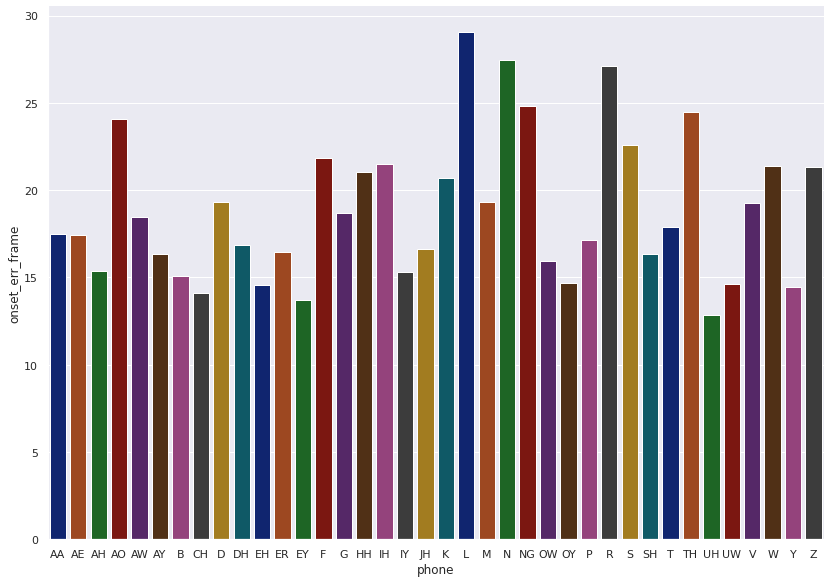

In [39]:
sns.catplot(data=datadf, kind='bar', x='phone', y='onset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

(array([4., 7., 8., 4., 3., 5., 2., 2., 2., 1.]), array([12.84420289, 14.46739048, 16.09057807, 17.71376566, 19.33695325,
       20.96014084, 22.58332843, 24.20651602, 25.82970361, 27.4528912 ,
       29.07607879]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

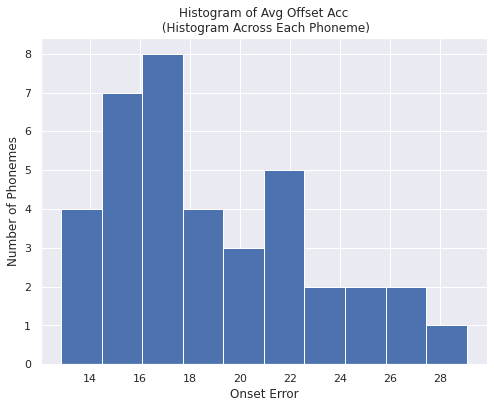

In [63]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_frame']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([ 2.,  3., 10.,  3.,  7.,  1.,  4.,  1.,  4.,  3.]), array([11.01294032, 12.63184582, 14.25075131, 15.86965681, 17.4885623 ,
       19.1074678 , 20.72637329, 22.34527879, 23.96418428, 25.58308977,
       27.20199527]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

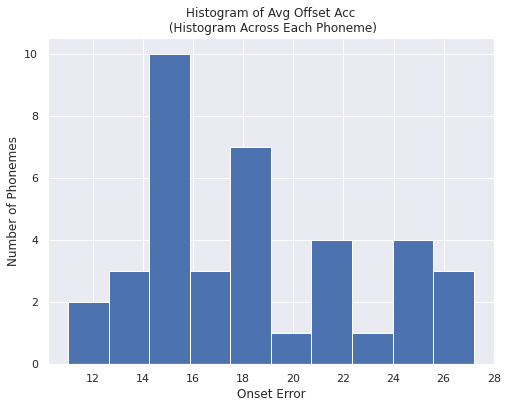

In [64]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_ivec']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([2., 6., 7., 5., 3., 5., 4., 0., 4., 2.]), array([11.36525213, 12.95279979, 14.54034746, 16.12789513, 17.7154428 ,
       19.30299047, 20.89053813, 22.4780858 , 24.06563347, 25.65318114,
       27.24072881]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

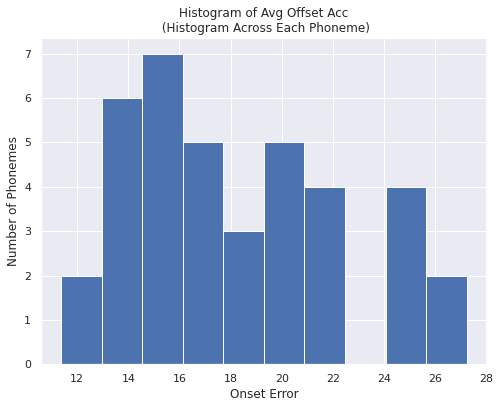

In [65]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_xvec']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([4., 7., 8., 4., 3., 5., 2., 2., 2., 1.]), array([12.84420289, 14.46739048, 16.09057807, 17.71376566, 19.33695325,
       20.96014084, 22.58332843, 24.20651602, 25.82970361, 27.4528912 ,
       29.07607879]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

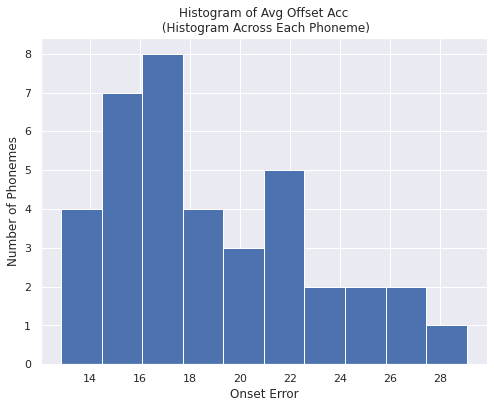

In [66]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_frame']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([1., 0., 2., 4., 4., 1., 4., 4., 9., 2., 3., 0., 2., 1.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

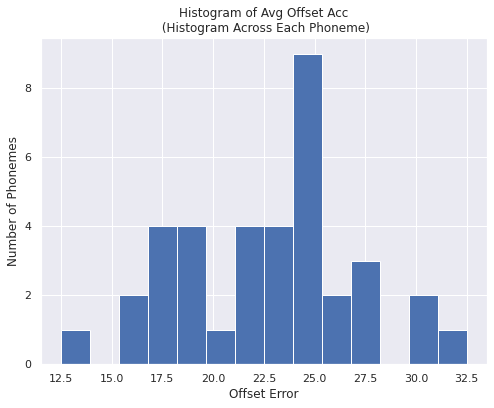

In [81]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_frame'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

(array([2., 2., 2., 2., 1., 3., 6., 4., 2., 7., 3., 2., 0., 1.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

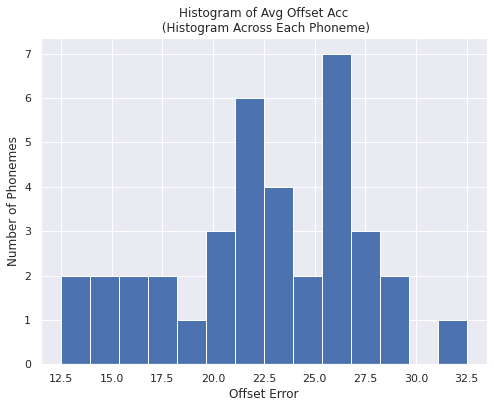

In [79]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_ivec'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

(array([3., 0., 2., 1., 3., 1., 6., 5., 6., 6., 1., 1., 1., 0.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

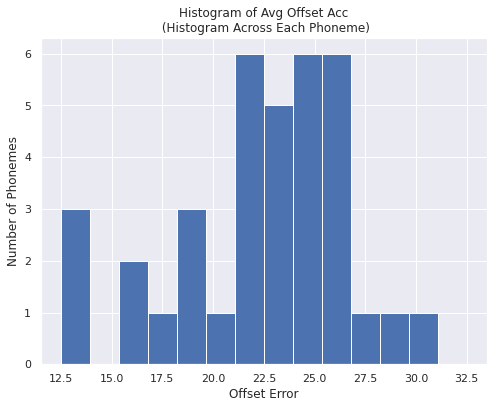

In [80]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_xvec'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

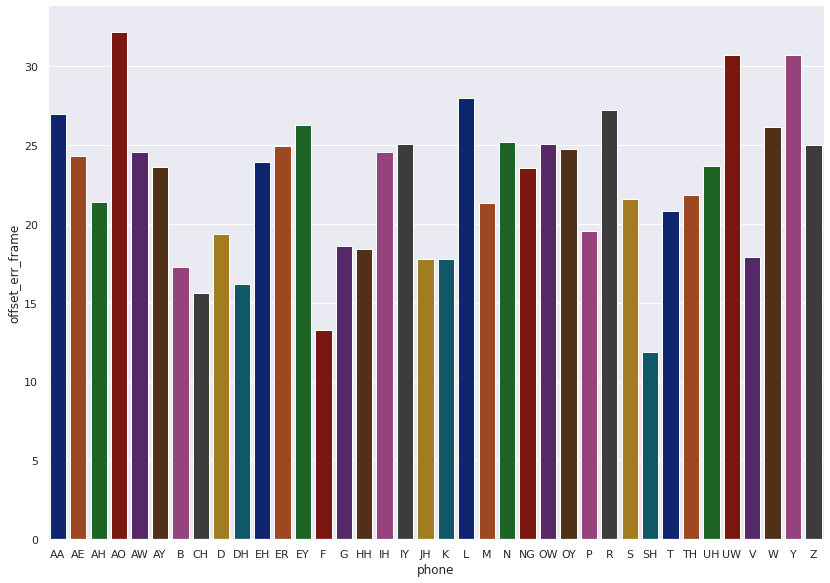

In [38]:
# plt.figure(figsize=(12,36))
# fig, ax = plt.subplots(figsize=(12,36))
# sns.set(rc={'figure.figsize':(12, 36)})
sns.catplot(data=datadf, kind='bar', x='phone', y='offset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

In [ ]:
# plt.figure(figsize=(12,36))
# fig, ax = plt.subplots(figsize=(12,36))
# sns.set(rc={'figure.figsize':(12, 36)})
sns.catplot(data=datadf, kind='bar', x='phone', y='offset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

In [13]:
np.mean(datadf['onset_err_frame'])

5.90656516910839

Start with a dictionary where the keys are all phonemes including silence
Then loop across speakers to calculate the following
Then loop through each phoneme in the textgrid

Average Phoneme Length plotting to find which ones get deleted often
- calculate the length of the phoneme for each case [manual, ivector, xvector, frame]

Onset/offset times
- create a function that compares the alignment accuracy in terms of onset/offset time
- for each phoneme 
- in a dictionary keep two lists for each phoneme: onset_time_errror and ofset_time_error
    
    
    

This thing should be easily parallelizable, you should learn how to parallelize it




In [ ]:
''' extract dictionary (speaker-wise) of the performance information'''

speaker_tgs = {}

for speaker_id in list(satdf.index):
    
    _results = {}
    tg_dct = {}

    tg_dct['Manual'] = manual_tgs_path
    tg_dct['iVec'] = finetuned_tgs_ivec
    tg_dct['xVec'] = finetuned_tgs_xvec
    tg_dct['Frame'] = finetuned_tgs_frame

In [ ]:
for speaker_id_in list(satdf.index):
    manual_tgs_path = [tgpath for tgpath in unmatched_manual_textgrid_files if speaker_id in tgpath]
    finetuned_tgs_ivec = get_all_textgrids_in_directory(results_dir_ivec, )

In [18]:
os.path.join(results_dir_frame, tgpath.split('/')[-2], tgpath.split('/')[-1])

'./results_frame_10epochs/results_sat/'

In [17]:
rslts_df.to_csv('./accuracy_results_ft_and_sat_methods.csv')

In [13]:
print(np.mean(rslts_df['PerfDiffiVec']))
print(np.mean(rslts_df['PerfDiffxVec']))

0.013917636604036807
0.014661981089438305


In [14]:
print(np.mean(rslts_df['iVecSATAccuracy']))
print(np.mean(rslts_df['xVecSATAccuracy']))

0.9184989953136226
0.9192433397990243


(array([1., 0., 0., 1., 0., 0., 1., 1., 0., 2.]),
 array([4.33333333, 4.575     , 4.81666667, 5.05833333, 5.3       ,
        5.54166667, 5.78333333, 6.025     , 6.26666667, 6.50833333,
        6.75      ]),
 <a list of 10 Patch objects>)

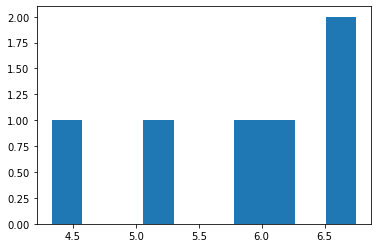

In [27]:
''' Plot histogram of Decliners'''
decliners_ivec = list(rslts_df[rslts_df['PerfDiffiVec']<0].index)
decliners_xvec = list(rslts_df[rslts_df['PerfDiffiVec']<0].index)

agedec_ivec = [int(spk[:2]) + float(spk[2:4])/12 for spk in decliners_ivec]
agedec_xvec = [int(spk[:2]) + float(spk[2:4])/12 for spk in decliners_xvec]
plt.hist(agedec_ivec)
# ydec_iv, xage1   = np.histogram(agedec_ivec)
# ydec_xv, xage2 = np.histogram(agedec_xvec)


# fig, ax = plt.subplots()
# rects1 = ax.bar(xage1[:-1], ydec_iv, width=0.35, label='iVec')
# rects2 = ax.bar(xage2[:-1], ydec_xv, width=0.35, label='xVec')
# ax.set_ylabel('Num Speakers')
# ax.set_title('Age of Speaker')
# ax.set_xticks(xage1, [str(ag) for ag in xage1[:-1]])
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# # rects1 = ax.bar(agedec,  width, label='Men')
# # rects2 = ax.bar(x + width/2, women_means, width, label='Women')


# plt.legend()
# plt.title('Age of Decliners')

Text(0, 0.5, 'Num Speakers')

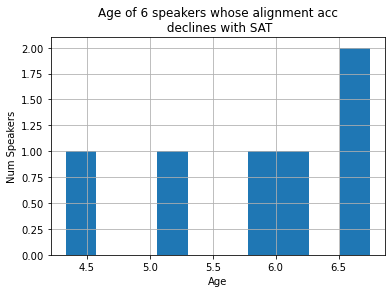

In [28]:
plt.hist(agedec_ivec)
plt.grid()
plt.title('Age of 6 speakers whose alignment acc\n declines with SAT')
plt.xlabel('Age')
plt.ylabel('Num Speakers')

In [17]:
decliners_xvec

['0609_F_AK', '0502_F_KM', '0603_M_LS', '0607_M_CE', '0404_M_TC', '0511_F_IG']

In [ ]:
improvers

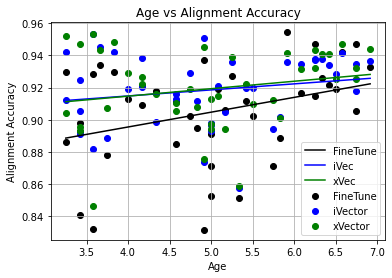

In [21]:
''' Scatter Age vs Alignment Accuracy'''
from sklearn.linear_model import LinearRegression

ages = [int(spk[:2]) + float(spk[2:4])/12 for spk in list(rslts_df.index)]
ages_lm = np.linspace(min(ages), max(ages), 100).reshape(-1, 1)

lmframe = LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['FrameWise_Acc'])
lmivec =  LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['iVecSATAccuracy'])
lmxvec =  LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['xVecSATAccuracy'])
plt.scatter(ages, rslts_df['FrameWise_Acc'], c='k', label='FineTune')
plt.scatter(ages, rslts_df['iVecSATAccuracy'], c='b', label='iVector')
plt.scatter(ages, rslts_df['xVecSATAccuracy'], c='g', label='xVector')


plt.plot(ages_lm, lmframe.predict(ages_lm), 'k', label='FineTune')
plt.plot(ages_lm, lmivec.predict(ages_lm),'b', label='iVec')
plt.plot(ages_lm, lmxvec.predict(ages_lm), 'g', label='xVec')


plt.legend()
plt.title('Age vs Alignment Accuracy')
plt.xlabel('Age')
plt.ylabel('Alignment Accuracy')
plt.grid()

In [22]:
improvers_ivec = list(rslts_df[rslts_df['PerfDiffiVec']>.03].index)
improvers_xvec =  list(rslts_df[rslts_df['PerfDiffxVec']>.03].index)
print(improvers_ivec)
print(improvers_xvec)

['0500_M_QA', '0305_F_AN', '0411_M_LM', '0407_M_SJ', '0307_F_IC']
['0500_M_QA', '0305_F_AN', '0411_M_LM', '0305_F_MB', '0509_F_ES']


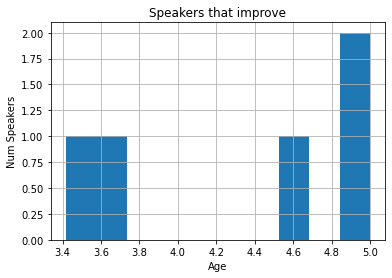

In [33]:
improvers=list(rslts_df[rslts_df['PerfDiffiVec']>.03].index)
plt.hist([int(imp[:2])+float(imp[2:4])/12 for imp in improvers])
plt.title('Speakers that improve')
plt.ylabel('Num Speakers')
plt.xlabel('Age')

plt.grid()

In [25]:
np.mean(rslts_df['SAT_Accuracy'])

0.9184989953136228

In [26]:
print(np.mean(rslts_df['PerfDiff']))
print(np.max(rslts_df['PerfDiff']))

0.013917636604036807
0.04988344988344984


Text(0, 0.5, 'Number of Speakers')

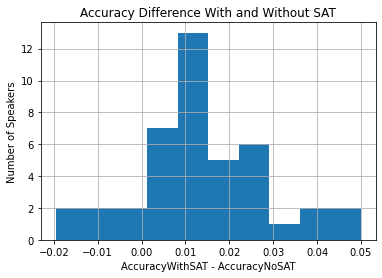

In [28]:
plt.figure()
plt.hist(rslts_df['PerfDiff'].values)
# plt.xlim([-.1, .25])
plt.grid()
plt.title('Accuracy Difference With and Without SAT')
plt.xlabel('AccuracyWithSAT - AccuracyNoSAT')
plt.ylabel('Number of Speakers')

In [ ]:
perf_dif = rslts_df['PerfDiff'].values[rslts_df['PerfDiff']<0]
np.mean(perf_dif)
np.max(perf_dif)

In [ ]:
strange_idxs = np.argwhere(np.array(perfdif)<0).ravel()
strange_speakers = [perf_diff[sidxs] for sidxs in strange_idxs]

In [ ]:
strange_speakers

In [ ]:
asdf = np.random.rand(1000)
xmin = -2.5
xmax = 7
plt.hist(asdf, bins=100)

In [62]:
''' 
create a 5 part dataset
'''

def piecewise_posterior(npoints=10000, n_components=5, priors=None, xmin=0, xmax=1):
    x = np.random.rand(npoints) 
    x = x  * (xmax - xmin) + xmin
    
    
    y = np.zeros_like(x) 
    posterior = np.zeros_like(x)
    
    
    